In [1]:
from postprocess import *

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


<Figure size 100x100 with 0 Axes>

In [86]:
from importlib import reload
from pathlib import Path

from plotnine import position_jitterdodge, coord_fixed
import apply_model
import postprocess
reload(postprocess)
reload(apply_model)
from postprocess import *
from apply_model import *

In [2]:
gs_sessions = [f'session_{i}_gs' for i in range(1, 5)]
nogs_sessions = [f'session_{i}_nogs' for i in range(1, 5)]

In [346]:
order_in_day_param_order = pd.read_csv(
    '/home/cezanne/t-haitani/hcp_data/derivatives/Python/fa_result/reliability/model_onlyFC_controlling_None_CovCor_lavaan_addMarker_MSST_OrderFactor_session.csv'
).iloc[:, 1:]

In [347]:
state_loadings_index = order_in_day_param_order.query('(lhs.isin(["o1", "o2"])) & (op == "=~")').index
method_loadings_index = order_in_day_param_order.query('(lhs.isin(["mf1", "mf2"])) & (op == "=~")').index

In [177]:
def visualize_boxplot(df, model_type=None, effect_type=None, gsr_type='nogs', fold=0, vis_df=False):
    df = add_diff_columns(df)
    
    long_df = create_long_df(df, gsr_type=gsr_type)
    long_df['effect'] = effect_type
    long_df['model'] = model_type
    long_df['gsr_type'] = gsr_type
    long_df['fold'] = fold
    
    if vis_df:
        g = create_boxplots(long_df, gsr_type=gsr_type)
        return g
    else:
        return long_df


def create_diff_fit_df(fit_index):
    fit_index_index = FIT_INDICES.index(fit_index)
    bifactor_df = pd.DataFrame(
        {
            'fold0_nogs': nogs_bifactor_fit_fold0[:, fit_index_index],
            'fold1_nogs': nogs_bifactor_fit_fold1[:, fit_index_index],
            'fold0_gs': gs_bifactor_fit_fold0[:, fit_index_index],
            'fold1_gs': gs_bifactor_fit_fold1[:, fit_index_index]
        }
    ).assign(
        model='Bifactor'
    ).reset_index().rename(columns={'index': 'edge'})
    
    msst_df = pd.DataFrame(
        {
            'fold0_nogs': nogs_msst_fit_fold0[:, fit_index_index],
            'fold1_nogs': nogs_msst_fit_fold1[:, fit_index_index],
            'fold0_gs': gs_msst_fit_fold0[:, fit_index_index],
            'fold1_gs': gs_msst_fit_fold1[:, fit_index_index]
        }
    ).assign(
        model='MSST'
    ).reset_index().rename(columns={'index': 'edge'})
    
    diff_fit_df = pd.concat(
        [msst_df, bifactor_df], axis=0
    ).melt(
        id_vars=['edge', 'model'],
        value_vars=['fold0_nogs', 'fold0_gs', 'fold1_nogs', 'fold1_gs'],
        value_name=fit_index
    ).assign(
        gsr=lambda x: x['variable'].str.split('_').str[1],
        fold=lambda x: x['variable'].str.split('_').str[0]
    ).drop(
        'variable', axis=1
    ).pivot(
        index=['edge', 'gsr', 'fold'],
        columns='model',
        values=fit_index
    ).reset_index().assign(
        diff_value=lambda x: x['MSST'] - x['Bifactor']
    )
    
    return diff_fit_df


def add_diff_columns(df):
    df['session_12_nogs_diff'] = df['session_1_nogs'] - df['session_2_nogs']
    df['session_34_nogs_diff'] = df['session_3_nogs'] - df['session_4_nogs']
    return df


def create_long_df(df, gsr_type):
    if gsr_type == '_nogs_':
        sessions = nogs_sessions
    elif gsr_type == '_gs_':
        sessions = gs_sessions
    else:
        raise Exception('gsr_type should be "_nogs_" or "_gs_".')
    
    long_df = df[['edge'] + sessions].melt(
        id_vars=['edge'],
        value_vars=sessions
    ).assign(
        session=lambda x: x['variable'].str.split('_').str[1]
    )
    return long_df


def create_boxplots(long_df):
    g = (
        ggplot(long_df, aes('session', 'value'))
        + geom_boxplot(outlier_color='')
        + geom_jitter(width=0.1, height=0, size=0.5, alpha=0.2)
        + scale_y_continuous(breaks=np.arange(0, 1, 0.1))
        + stat_summary(fun_y=np.mean, geom='point', color='red')
        + stat_summary(fun_data='mean_cl_boot', geom='errorbar', color='red', width=0.2)
    )
    return g


def get_latest_file_from_condition(
    msst=True, st=False, order_in_day=True, gsr_type='_nogs_', fold=0, select_cb=True, data_type='fit_indices', sample_n=199,
    bi_factor=False, seed=None
):
    search_path = Path(
        '/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability'
    ) / data_type / 'combined/split_half_cv'
    filepaths = [i for i in search_path.iterdir()]
    
    if msst:
        filepaths = [i for i in filepaths if 'MSST' in i.name]
    else:
        filepaths = [i for i in filepaths if not 'MSST' in i.name]
    
    if st:
        filepaths = [i for i in filepaths if 'SingleTrait' in i.name]
    else:
        filepaths = [i for i in filepaths if not 'SingleTrait' in i.name]
    
    if bi_factor:
        filepaths = [i for i in filepaths if 'Bifactor' in i.name]
    else:
        filepaths = [i for i in filepaths if not 'Bifactor' in i.name]
        
    filepaths = [i for i in filepaths if gsr_type in i.name]
    filepaths = [i for i in filepaths if f'Fold_{fold}' in i.name]
    filepaths = [i for i in filepaths if f'sampleN_{sample_n}' in i.name]
    
    if select_cb:
         filepaths = [i for i in filepaths if 'SelectCB' in i.name]
    else:
        filepaths = [i for i in filepaths if not 'SelectCB' in i.name]
    
    if order_in_day:
        filepaths = [i for i in filepaths if 'OrderInDay' in i.name]
    else:
        filepaths = [i for i in filepaths if not 'OrderInDay' in i.name]
    
    if seed is not None:
        filepaths = [i for i in filepaths if f'seed{seed}' in i.name]
    
    filepaths = [str(i) for i in filepaths]
    target_file = sort_list_by_time(filepaths)[-1]
    print(target_file)
    return Path(target_file)


def modify_output_df(output_df):
    effect_map = {'cons': 'Common consistency', 'spec': 'Occasional specificity', 'error': 'Random error'}
    session_map = {'1': 'Run 1 in day 1', '2': 'Run 2 in day 1', '3': 'Run 1 in day 2', '4': 'Run 2 in day 2'}
    gsr_map = {'_nogs_': 'Without GSR', '_gs_': 'With GSR'}
    fold_map = {0: 'Exploratory', 1: 'Validation'}
    
    output_df['effect'] = output_df['effect'].map(effect_map)
    output_df['session'] = output_df['session'].map(session_map)
    output_df['gsr_type'] = output_df['gsr_type'].map(gsr_map)
    output_df['fold'] = output_df['fold'].map(fold_map)
    
    output_df['gsr_type'] = pd.Categorical(
        output_df['gsr_type'],
        categories=['Without GSR', 'With GSR']
    )
    output_df['session'] = pd.Categorical(
        output_df['session'],
        categories=['Run 1 in day 1', 'Run 2 in day 1', 'Run 1 in day 2', 'Run 2 in day 2']
    )

    output_df['Day'] = np.where(
        output_df['session'].isin(['Run 1 in day 1', 'Run 2 in day 1']), 'Day 1', 'Day 2'
    )
    output_df['Run'] = np.where(
        output_df['session'].isin(['Run 1 in day 1', 'Run 1 in day 2']), 'Run 1', 'Run 2'
    )
    output_df['day_effect'] = output_df['Day'].astype(str) + '_' + output_df['effect'].astype(str)
    
    return output_df

## Revision in Scientific Reports

### Bifactor model

In [201]:
create_combined_files_from_slurm_array(
    bi_factor=True,
    controls=None,
    data_type_list=['factor_scores'],
    family_fold=1,
    controls_before='',
    random_seed=0,
    search_trash=False,
    over_write=False,
    **{'sample_n': 204, 'edge_n': 93096},
)

Processing /home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/factor_scores in _nogs_.
(93096, 204, 3)
Saving factor_scores_Model_onlyFC_Trait_None_Scale_None_sampleN_204_Fold_1_nogs_edgeN_93096_Est_MLR_z_Bifactor_OutStd_lavaan_session_split_half_family_seed0_2025-05-29 08:10:54_combined.npy.
Saving completed.
Processing /home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/factor_scores in _gs_.
(93096, 204, 3)
Saving factor_scores_Model_onlyFC_Trait_None_Scale_None_sampleN_204_Fold_1_gs_edgeN_93096_Est_MLR_z_Bifactor_OutStd_lavaan_session_split_half_family_seed0_2025-05-29 08:16:14_combined.npy.
Saving completed.
Completed.


In [199]:
create_combined_files_from_slurm_array(
    bi_factor=True,
    controls=None,
    data_type_list=['factor_scores'],
    family_fold=0,
    controls_before='',
    random_seed=0,
    search_trash=True,
    over_write=True,
    **{'sample_n': 203, 'edge_n': 93096},
)

Processing /home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/factor_scores/trash in _nogs_.
(93096, 203, 3)
Saving factor_scores_Model_onlyFC_Trait_None_Scale_None_sampleN_203_Fold_0_nogs_edgeN_93096_Est_MLR_z_Bifactor_OutStd_lavaan_session_split_half_family_seed0_2025-05-29 08:09:33_combined.npy.
Saving completed.
Processing /home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/factor_scores/trash in _gs_.
(93096, 203, 3)
Saving factor_scores_Model_onlyFC_Trait_None_Scale_None_sampleN_203_Fold_0_gs_edgeN_93096_Est_MLR_z_Bifactor_OutStd_lavaan_session_split_half_family_seed0_2025-05-29 08:14:50_combined.npy.
Saving completed.
Completed.


In [127]:
for i in range(1, 2):
    create_combined_files_from_slurm_array(
        bi_factor=True,
        controls=None,
        data_type_list=['fit_indices', 'parameters'],
        family_fold=i,
        controls_before='',
        random_seed=0,
        search_trash=False,
        over_write=True,
        select_cb=True,
        **{'sample_n': 199, 'edge_n': 93096},
)

Processing /home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices in _nogs_.
(93096, 15)
Saving fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_1_nogs_edgeN_93096_Est_MLR_z_Bifactor_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-06-03 16:02:13_combined.npy.
Saving completed.
Processing /home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/parameters in _nogs_.
(93096, 18, 5)
Saving params_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_1_nogs_edgeN_93096_Est_MLR_z_Bifactor_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-06-03 16:02:13_combined.npy.
Saving completed.
Processing /home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices in _gs_.
(93096, 15)
Saving fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_1_gs_edgeN_93096_Est_MLR_z_Bifactor_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-06-03 16:0

In [115]:
create_combined_files_from_slurm_array(
    bi_factor=True,
    controls=None,
    data_type_list=['fit_indices', 'parameters'],
    family_fold=0,
    controls_before='',
    random_seed=0,
    search_trash=True,
    over_write=True,
    **{'sample_n': 203, 'edge_n': 93096},
)

Processing /home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/trash in _nogs_.
(93096, 15)
Saving fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_203_Fold_0_nogs_edgeN_93096_Est_MLR_z_Bifactor_OutStd_lavaan_session_split_half_family_seed0_2025-05-29 08:09:33_combined.npy.
Saving completed.
Processing /home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/parameters/trash in _nogs_.
(93096, 18, 5)
Saving params_Model_onlyFC_Trait_None_Scale_None_sampleN_203_Fold_0_nogs_edgeN_93096_Est_MLR_z_Bifactor_OutStd_lavaan_session_split_half_family_seed0_2025-05-29 08:09:33_combined.npy.
Saving completed.
Processing /home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/trash in _gs_.
(93096, 15)
Saving fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_203_Fold_0_gs_edgeN_93096_Est_MLR_z_Bifactor_OutStd_lavaan_session_split_half_family_seed0_2025-05-29 08:14:50_comb

In [105]:
create_combined_files_from_slurm_array(
    bi_factor=True,
    controls=None,
    data_type_list=['fit_indices', 'parameters'],
    family_fold=1,
    controls_before='',
    random_seed=0,
    **{'sample_n': 204, 'edge_n': 93096},
)

Processing /home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices in _nogs_.
(93096, 15)
Saving fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_204_Fold_1_nogs_edgeN_93096_Est_MLR_z_Bifactor_OutStd_lavaan_session_split_half_family_seed0_2025-05-29 08:10:54_combined.npy.
Saving completed.
Processing /home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/parameters in _nogs_.
(93096, 18, 5)
Saving params_Model_onlyFC_Trait_None_Scale_None_sampleN_204_Fold_1_nogs_edgeN_93096_Est_MLR_z_Bifactor_OutStd_lavaan_session_split_half_family_seed0_2025-05-29 08:10:54_combined.npy.
Saving completed.
Processing /home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices in _gs_.
(93096, 15)
Saving fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_204_Fold_1_gs_edgeN_93096_Est_MLR_z_Bifactor_OutStd_lavaan_session_split_half_family_seed0_2025-05-29 08:16:14_combined.npy.
Saving c

In [13]:
get_latest_file_from_condition(
    msst=True, order_in_day=False, bi_factor=False, sample_n=203, fold=0, select_cb=False, seed=0
)

/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/split_half_cv/fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_203_Fold_0_nogs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_seed0_2024-12-12 13:17:41_combined.npy


PosixPath('/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/split_half_cv/fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_203_Fold_0_nogs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_seed0_2024-12-12 13:17:41_combined.npy')

In [79]:
FIT_INDICES.index('chi2')

2

In [92]:
def create_fit_df(fit_index, plot=False, exclude_invalid_edges=False, fit_index_label=None, 
                  save_filename=None, xlim=None, ylim=None, title=None):
    fit_index_index = FIT_INDICES.index(fit_index)
    
    output_df_msst = pd.DataFrame()
    output_df_bifactor = pd.DataFrame()
    
    sample_n_dict = {0: 203, 1: 204}
    
    for fold in [0, 1]:
        for gsr_type in ['_nogs_', '_gs_']:
            # MSST
            fit_array_msst = np.load(
                get_latest_file_from_condition(
                    msst=True, order_in_day=False, bi_factor=False, 
                    sample_n=sample_n_dict[fold], 
                    fold=fold, select_cb=False, gsr_type=gsr_type, seed=0
                )
            )[:, fit_index_index]
            fit_df_msst = pd.DataFrame(fit_array_msst, columns=[fit_index])
            fit_df_msst['gsr_type'] = gsr_type
            fit_df_msst['fold'] = fold
            
            if exclude_invalid_edges:
                invalid_edges = np.loadtxt(
                    f'/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/invalid_edges/Fold_{fold}/errorNone{gsr_type}invalid_edges_SRMR_0.08_RMSEA_0.08_CFI_0.9_loadings_from_0.4_to_0.9_2ndLoadings_from_0.7_to_1_controlling__.csv'
                ).astype(int)
                fit_df_msst.drop(index=invalid_edges, inplace=True)
            
            output_df_msst = pd.concat([output_df_msst, fit_df_msst], axis=0)
            
            # Bi-factor
            fit_array_bf = np.load(
                get_latest_file_from_condition(
                    msst=False,
                    order_in_day=False, 
                    bi_factor=True,
                    sample_n=sample_n_dict[fold], 
                    fold=fold, 
                    select_cb=False,
                    gsr_type=gsr_type
                    )
            )[:, fit_index_index]
            fit_df_bf = pd.DataFrame(fit_array_bf, columns=[fit_index])
            fit_df_bf['gsr_type'] = gsr_type
            fit_df_bf['fold'] = fold
            output_df_bifactor = pd.concat([output_df_bifactor, fit_df_bf], axis=0)
    
    output_df_msst['model'] = 'MSST'
    output_df_bifactor['model'] = 'Bifactor'

    concat_df_fit = pd.concat([convert_df(output_df_bifactor), convert_df(output_df_msst)], axis=0)
    concat_df_fit = concat_df_fit.reset_index().rename(columns={'index': 'edge'})    

    wide_concat_df_fit = concat_df_fit.pivot(
        index=['edge', 'gsr_type', 'fold'],
        values=fit_index,
        columns='model'
    ).reset_index()
    
    if plot:
        if fit_index_label is not None:
            fit_index = fit_index_label
        g = (
            ggplot(wide_concat_df_fit, aes('MSST', 'Bifactor'))
            + geom_point(size=0.5, alpha=0.2)
            + facet_grid('gsr_type ~ fold')
            + theme_bw()
            + labs(x=f'{fit_index} in multistate single-trait model', y=f'{fit_index} in bi-factor model')
            + geom_abline(intercept=0, slope=1, linetype='dashed')
            + coord_cartesian(xlim=xlim, ylim=ylim)
        )
        if title is not None:
            g = g + labs(title=title)
        if save_filename is not None:
            g.save(f'/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/figures/{save_filename}.png')
        return g
    
    return wide_concat_df_fit

/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/split_half_cv/fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_203_Fold_0_nogs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_seed0_2024-12-12 13:17:41_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/split_half_cv/fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_203_Fold_0_nogs_edgeN_93096_Est_MLR_z_Bifactor_OutStd_lavaan_session_split_half_family_seed0_2025-05-29 08:09:33_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/split_half_cv/fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_203_Fold_0_gs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_seed0_2024-12-12 13:33:38_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combin

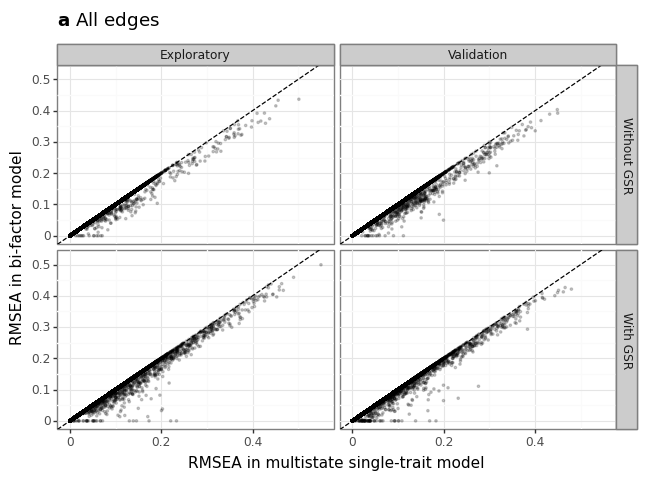

<Figure Size: (640 x 480)>

In [286]:
create_fit_df('RMSEA', plot=True, exclude_invalid_edges=False, fit_index_label='RMSEA',
#               xlim=[0, 70], ylim=[0, 70],
#              save_filename='scatter_chi2_msst_bifactor_with_all_edges',
             title=r'$\bf{a}$' + ' All edges')

/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/split_half_cv/fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_203_Fold_0_nogs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_seed0_2024-12-12 13:17:41_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/split_half_cv/fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_203_Fold_0_nogs_edgeN_93096_Est_MLR_z_Bifactor_OutStd_lavaan_session_split_half_family_seed0_2025-05-29 08:09:33_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/split_half_cv/fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_203_Fold_0_gs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_seed0_2024-12-12 13:33:38_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combin

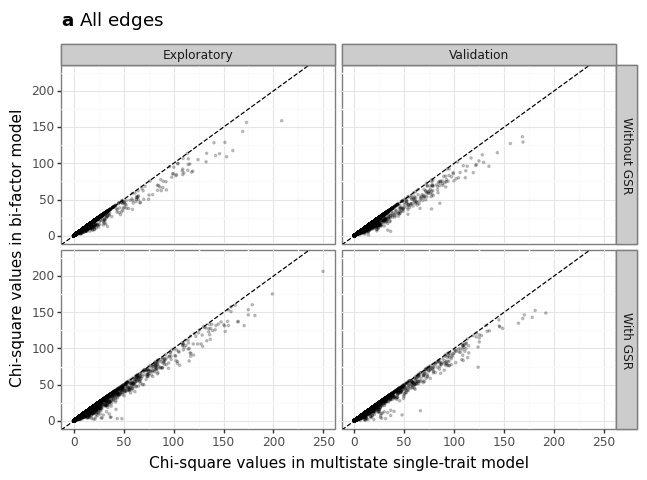

<Figure Size: (640 x 480)>

In [94]:
create_fit_df('chi2', plot=True, exclude_invalid_edges=False, fit_index_label='Chi-square values',
#               xlim=[0, 70], ylim=[0, 70],
             save_filename='scatter_chi2_msst_bifactor_with_all_edges',
             title=r'$\bf{a}$' + ' All edges')

/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/split_half_cv/fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_203_Fold_0_nogs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_seed0_2024-12-12 13:17:41_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/split_half_cv/fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_203_Fold_0_nogs_edgeN_93096_Est_MLR_z_Bifactor_OutStd_lavaan_session_split_half_family_seed0_2025-05-29 08:09:33_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/split_half_cv/fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_203_Fold_0_gs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_seed0_2024-12-12 13:33:38_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combin

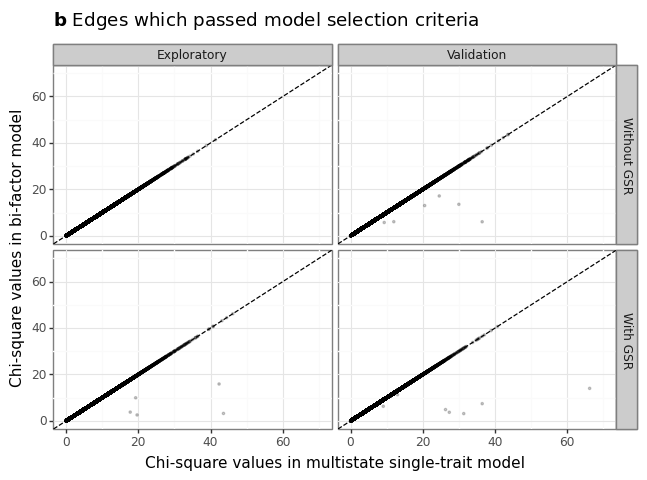

<Figure Size: (640 x 480)>

In [93]:
create_fit_df('chi2', plot=True, exclude_invalid_edges=True, fit_index_label='Chi-square values', xlim=[0, 70], ylim=[0, 70],
             save_filename='scatter_chi2_msst_bifactor_removed_invalid_edges_inmsst',
             title=r'$\bf{b}$' + ' Edges which passed model selection criteria')

/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/split_half_cv/fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_203_Fold_0_nogs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_seed0_2024-12-12 13:17:41_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/split_half_cv/fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_203_Fold_0_nogs_edgeN_93096_Est_MLR_z_Bifactor_OutStd_lavaan_session_split_half_family_seed0_2025-05-29 08:09:33_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/split_half_cv/fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_203_Fold_0_gs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_seed0_2024-12-12 13:33:38_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combin

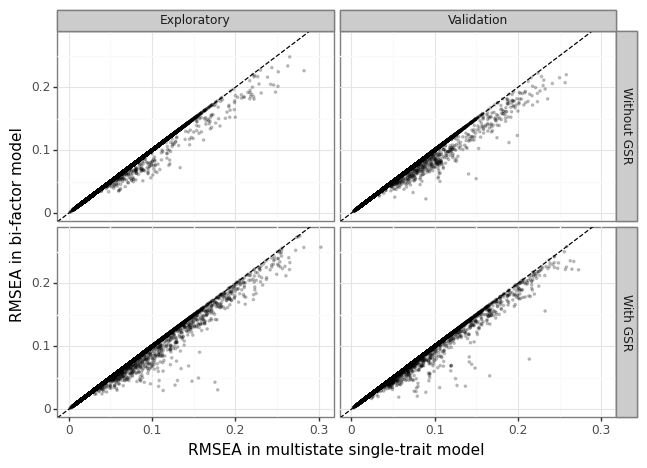

<Figure Size: (640 x 480)>

In [67]:
create_fit_df('RMSEA', plot=True)

In [64]:
srmr_df = create_fit_df('SRMR')

/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/split_half_cv/fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_203_Fold_0_nogs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_seed0_2024-12-12 13:17:41_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/split_half_cv/fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_203_Fold_0_nogs_edgeN_93096_Est_MLR_z_Bifactor_OutStd_lavaan_session_split_half_family_seed0_2025-05-29 08:09:33_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/split_half_cv/fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_203_Fold_0_gs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_seed0_2024-12-12 13:33:38_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combin

In [437]:
output_df_msst_cb = convert_df(output_df_msst_cb).reset_index().rename(columns={'index': 'edge'})

In [433]:
output_df_msst = convert_df(output_df_msst).reset_index().rename(columns={'index': 'edge'})

In [438]:
output_df_msst_cb['model'] = 'CB'

In [435]:
output_df_msst['model'] = 'NotCB'

In [440]:
concat_df_chi2 = pd.concat([output_df_msst_cb, output_df_msst], axis=0)

In [444]:
wide_concat_df_chi2 = concat_df_chi2.pivot(index=['edge', 'gsr_type', 'fold'], values='chi2', columns='model').reset_index()

In [445]:
wide_concat_df_chi2

model    edge     gsr_type         fold         CB      NotCB
0           0  Without GSR  Exploratory   0.628377   2.193756
1           0  Without GSR   Validation  13.772850   0.589802
2           0     With GSR  Exploratory   5.720056   2.417409
3           0     With GSR   Validation   4.634938   3.354554
4           1  Without GSR  Exploratory   0.902716   8.607510
...       ...          ...          ...        ...        ...
372379  93094     With GSR   Validation   9.072855  12.165841
372380  93095  Without GSR  Exploratory   4.385862   4.164074
372381  93095  Without GSR   Validation   3.646438  10.591252
372382  93095     With GSR  Exploratory   1.002097   5.929819
372383  93095     With GSR   Validation   3.388305   1.701122

[372384 rows x 5 columns]

In [448]:
concat_df_chi2

edge       chi2     gsr_type         fold  model
0           0   0.628377  Without GSR  Exploratory     CB
1           1   0.902716  Without GSR  Exploratory     CB
2           2   0.700432  Without GSR  Exploratory     CB
3           3   4.825203  Without GSR  Exploratory     CB
4           4   5.157140  Without GSR  Exploratory     CB
...       ...        ...          ...          ...    ...
372379  93091   5.187479     With GSR   Validation  NotCB
372380  93092  15.015286     With GSR   Validation  NotCB
372381  93093  10.753865     With GSR   Validation  NotCB
372382  93094  12.165841     With GSR   Validation  NotCB
372383  93095   1.701122     With GSR   Validation  NotCB

[744768 rows x 5 columns]

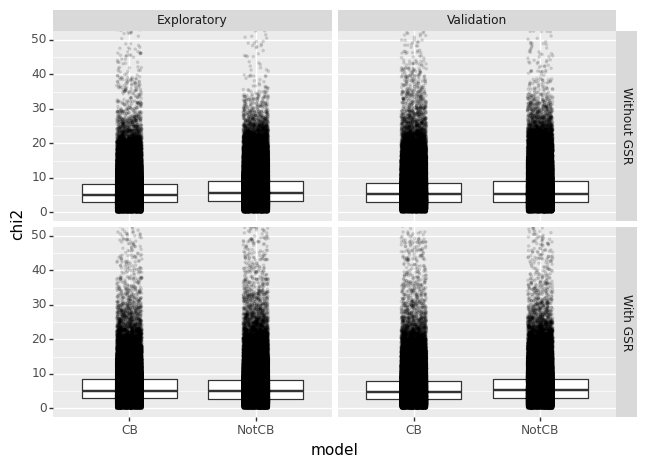

<Figure Size: (640 x 480)>

In [455]:
g = (
    ggplot(concat_df_chi2, aes('model', 'chi2'))
    + geom_boxplot(outlier_color='')
    + geom_jitter(height=0, width=0.1, size=0.5, alpha=0.1)
    + facet_grid('gsr_type ~ fold')
    + coord_cartesian(ylim=[0, 50])
)
g

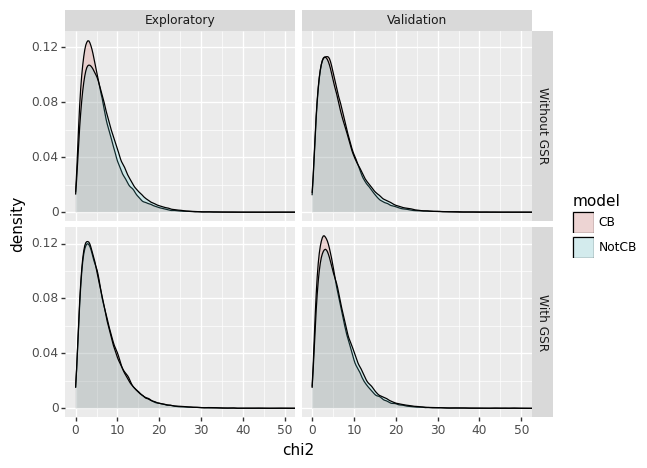

<Figure Size: (640 x 480)>

In [450]:
g = (
    ggplot(concat_df_chi2, aes('chi2', fill='model'))
    + geom_density(size=0.5, alpha=0.2)
    + facet_grid('gsr_type ~ fold')
    + coord_cartesian(xlim=[0, 50])
#     + geom_abline(slope=1, intercept=0, linetype='dashed')
)
g

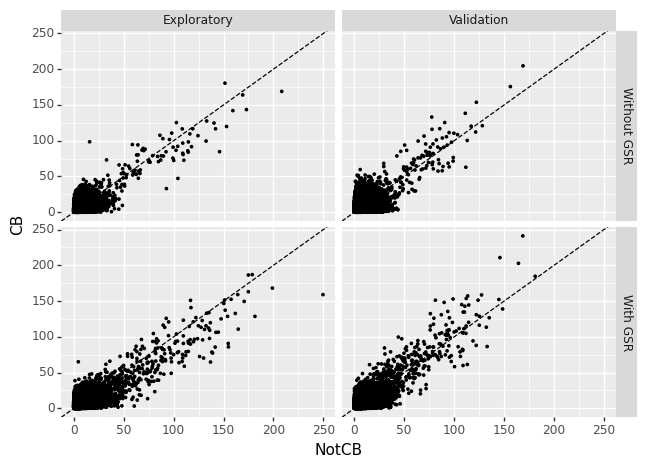

<Figure Size: (640 x 480)>

In [447]:
g = (
    ggplot(wide_concat_df_chi2, aes('NotCB', 'CB'))
    + geom_point(size=0.5)
    + facet_grid('gsr_type ~ fold')
    + geom_abline(slope=1, intercept=0, linetype='dashed')
)
g

In [436]:
output_df_msst_cb = pd.DataFrame()
sample_n_dict = {0: 199, 1: 199}
for fold in [0, 1]:
    for gsr_type in ['_nogs_', '_gs_']:
        chi2_array = np.load(
            get_latest_file_from_condition(
                msst=True, order_in_day=False, bi_factor=False, sample_n=sample_n_dict[fold], 
                fold=fold, select_cb=True, gsr_type=gsr_type, seed=0
            )
        )[:, 2]
        chi2_df = pd.DataFrame(chi2_array, columns=['chi2'])
        chi2_df['gsr_type'] = gsr_type
        chi2_df['fold'] = fold
        output_df_msst_cb = pd.concat([output_df_msst_cb, chi2_df], axis=0)
#         set_trace()

/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/split_half_cv/fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_0_nogs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-06-01 06:46:29_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/split_half_cv/fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_0_gs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-06-01 06:48:35_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/split_half_cv/fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_1_nogs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-06-01 06:48:17_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliabi

In [432]:
output_df_msst = pd.DataFrame()
sample_n_dict = {0: 203, 1: 204}
for fold in [0, 1]:
    for gsr_type in ['_nogs_', '_gs_']:
        chi2_array = np.load(
            get_latest_file_from_condition(
                msst=True, order_in_day=False, bi_factor=False, sample_n=sample_n_dict[fold], 
                fold=fold, select_cb=False, gsr_type=gsr_type, seed=0
            )
        )[:, 2]
        chi2_df = pd.DataFrame(chi2_array, columns=['chi2'])
        chi2_df['gsr_type'] = gsr_type
        chi2_df['fold'] = fold
        output_df_msst = pd.concat([output_df_msst, chi2_df], axis=0)
#         set_trace()

/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/split_half_cv/fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_203_Fold_0_nogs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_seed0_2024-12-12 13:17:41_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/split_half_cv/fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_203_Fold_0_gs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_seed0_2024-12-12 13:33:38_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/split_half_cv/fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_204_Fold_1_nogs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_seed0_2024-12-12 13:32:33_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/s

In [37]:
output_df_bifactor = pd.DataFrame()
sample_n_dict = {0: 203, 1: 204}
for fold in [0, 1]:
    for gsr_type in ['_nogs_', '_gs_']:
        chi2_array = np.load(
            get_latest_file_from_condition(
        msst=False, order_in_day=False, bi_factor=True, sample_n=sample_n_dict[fold], 
                fold=fold, select_cb=True, gsr_type=gsr_type
            )
        )[:, 2]
        chi2_df = pd.DataFrame(chi2_array, columns=['chi2'])
        chi2_df['gsr_type'] = gsr_type
        chi2_df['fold'] = fold
        output_df_bifactor = pd.concat([output_df_bifactor, chi2_df], axis=0)
#         set_trace()

/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/split_half_cv/fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_203_Fold_0_nogs_edgeN_93096_Est_MLR_z_Bifactor_OutStd_lavaan_session_split_half_family_seed0_2025-05-29 08:09:33_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/split_half_cv/fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_203_Fold_0_gs_edgeN_93096_Est_MLR_z_Bifactor_OutStd_lavaan_session_split_half_family_seed0_2025-05-29 08:14:50_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/split_half_cv/fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_204_Fold_1_nogs_edgeN_93096_Est_MLR_z_Bifactor_OutStd_lavaan_session_split_half_family_seed0_2025-05-29 08:10:54_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indice

In [38]:
output_df_msst['model'] = 'MSST'
output_df_bifactor['model'] = 'Bifactor'

concat_df_chi2 = pd.concat([convert_df(output_df_bifactor), convert_df(output_df_msst)], axis=0)

In [42]:
concat_df_chi2

chi2     gsr_type         fold     model
0       2.193756  Without GSR  Exploratory  Bifactor
1       8.607510  Without GSR  Exploratory  Bifactor
2       7.648904  Without GSR  Exploratory  Bifactor
3      10.556317  Without GSR  Exploratory  Bifactor
4      12.196931  Without GSR  Exploratory  Bifactor
...          ...          ...          ...       ...
93091   5.187479     With GSR   Validation      MSST
93092  15.015286     With GSR   Validation      MSST
93093  10.753865     With GSR   Validation      MSST
93094  12.165841     With GSR   Validation      MSST
93095   1.701122     With GSR   Validation      MSST

[744768 rows x 4 columns]

In [43]:
concat_df_chi2 = concat_df_chi2.reset_index().rename(columns={'index': 'edge'})

In [51]:
wide_concat_df_chi2 = concat_df_chi2.pivot(
    index=['edge', 'gsr_type', 'fold'],
    values='chi2',
    columns='model'
).reset_index()

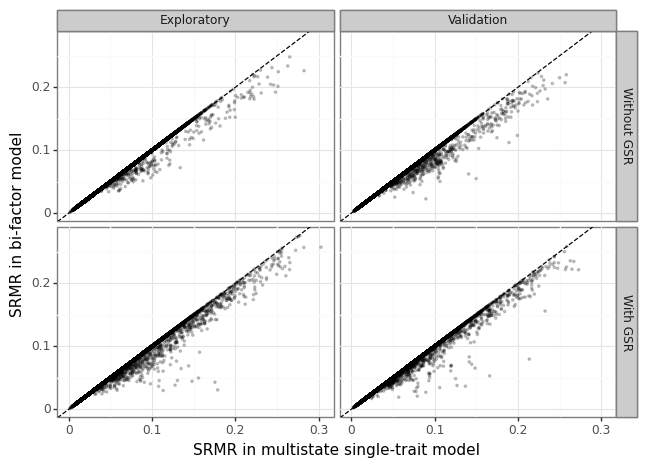

<Figure Size: (640 x 480)>

In [65]:
g = (
    ggplot(srmr_df, aes('MSST', 'Bifactor'))
    + geom_point(size=0.5, alpha=0.2)
    + facet_grid('gsr_type ~ fold')
    + theme_bw()
    + labs(x='SRMR in multistate single-trait model', y='SRMR in bi-factor model')
    + geom_abline(intercept=0, slope=1, linetype='dashed')
)
# g.save('/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/figures/scatter_msst_bifactor_chi2.png')
g


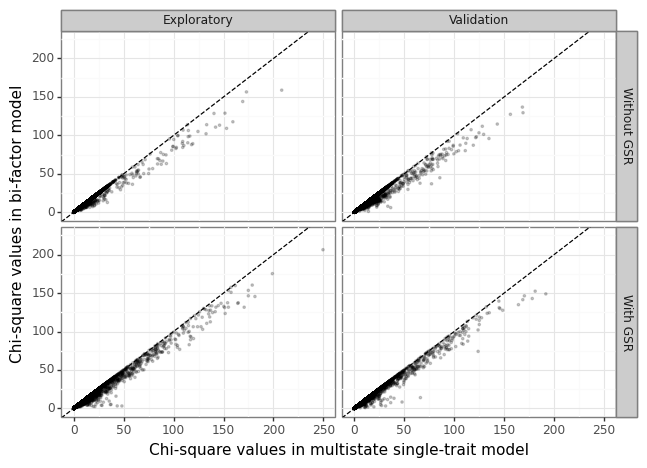

<Figure Size: (640 x 480)>

In [57]:
g = (
    ggplot(wide_concat_df_chi2, aes('MSST', 'Bifactor'))
    + geom_point(size=0.5, alpha=0.2)
    + facet_grid('gsr_type ~ fold')
    + theme_bw()
    + labs(x='Chi-square values in multistate single-trait model', y='Chi-square values in bi-factor model')
    + geom_abline(intercept=0, slope=1, linetype='dashed')
)
g.save('/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/figures/scatter_msst_bifactor_chi2.png')
g


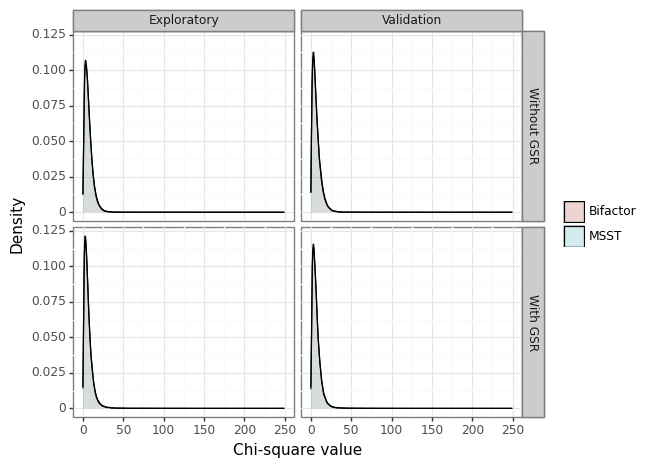

<Figure Size: (640 x 480)>

In [47]:
g = (
    ggplot(concat_df_chi2, aes('chi2', fill='model'))
    + geom_density(alpha=0.2)
    + facet_grid('gsr_type ~ fold')
    + theme_bw()
    + theme(
        legend_title=element_blank()
    )
    + labs(x='Chi-square value', y='Density')
)
g

In [285]:
nogs_bifactor_fit_fold0 = np.load(
    '/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_203_Fold_0_nogs_edgeN_93096_Est_MLR_z_Bifactor_OutStd_lavaan_session_split_half_family_seed0_2025-05-29 08:09:33_combined.npy'
)

In [281]:
nogs_bifactor_fit_fold1 = np.load(
    '/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_204_Fold_1_nogs_edgeN_93096_Est_MLR_z_Bifactor_OutStd_lavaan_session_split_half_family_seed0_2025-05-29 08:10:54_combined.npy'
)

In [282]:
gs_bifactor_fit_fold0 = np.load(
    '/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_203_Fold_0_gs_edgeN_93096_Est_MLR_z_Bifactor_OutStd_lavaan_session_split_half_family_seed0_2025-05-29 08:14:50_combined.npy'
)

In [284]:
gs_bifactor_fit_fold1 = np.load(
    '/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_204_Fold_1_gs_edgeN_93096_Est_MLR_z_Bifactor_OutStd_lavaan_session_split_half_family_seed0_2025-05-29 08:16:14_combined.npy'
)

In [337]:
FIT_INDICES.index('SRMR')

14

In [342]:
diff_srmr_df = create_diff_fit_df('SRMR')

In [346]:
diff_srmr_df

model    edge   gsr   fold  Bifactor      MSST    diff_value
0           0    gs  fold0  0.037928  0.037928  1.117587e-08
1           0    gs  fold1  0.023570  0.023570  3.725290e-09
2           0  nogs  fold0  0.041367  0.041367  0.000000e+00
3           0  nogs  fold1  0.021286  0.021286  1.862645e-09
4           1    gs  fold0  0.060415  0.060415  0.000000e+00
...       ...   ...    ...       ...       ...           ...
372379  93094  nogs  fold1  0.069013  0.069013  1.490116e-08
372380  93095    gs  fold0  0.059416  0.059416  0.000000e+00
372381  93095    gs  fold1  0.031905  0.031905  0.000000e+00
372382  93095  nogs  fold0  0.048900  0.048900  2.607703e-08
372383  93095  nogs  fold1  0.077510  0.077510 -5.960464e-08

[372384 rows x 6 columns]

In [291]:
bifactor_df = pd.DataFrame(
    {
        'fold0_nogs': nogs_bifactor_fit_fold0[:, 2],
        'fold1_nogs': nogs_bifactor_fit_fold1[:, 2],
        'fold0_gs': gs_bifactor_fit_fold0[:, 2],
        'fold1_gs': gs_bifactor_fit_fold1[:, 2]
    }
).assign(
    model='Bifactor'
).reset_index().rename(columns={'index': 'edge'})

In [298]:
msst_df = pd.DataFrame(
    {
        'fold0_nogs': nogs_msst_fit_fold0[:, 2],
        'fold1_nogs': nogs_msst_fit_fold1[:, 2],
        'fold0_gs': gs_msst_fit_fold0[:, 2],
        'fold1_gs': gs_msst_fit_fold1[:, 2]
    }
).assign(
    model='MSST'
).reset_index().rename(columns={'index': 'edge'})

In [310]:
diff_chi2_df = pd.concat(
    [msst_df, bifactor_df], axis=0
).melt(
    id_vars=['edge', 'model'],
    value_vars=['fold0_nogs', 'fold0_gs', 'fold1_nogs', 'fold1_gs'],
    value_name='chi2'
).assign(
    gsr=lambda x: x['variable'].str.split('_').str[1],
    fold=lambda x: x['variable'].str.split('_').str[0]
).drop(
    'variable', axis=1
).pivot(
    index=['edge', 'gsr', 'fold'],
    columns='model',
    values='chi2'
).reset_index().assign(
    diff_chi2=lambda x: x['MSST'] - x['Bifactor']
)

In [321]:
long_df_chi2 = diff_chi2_df.melt(
    id_vars=['edge', 'gsr', 'fold'],
    value_vars=['Bifactor', 'MSST'],
    value_name='chi2'
)

In [322]:
long_df_chi2

edge   gsr   fold     model       chi2
0           0    gs  fold0  Bifactor   2.417409
1           0    gs  fold1  Bifactor   3.354554
2           0  nogs  fold0  Bifactor   2.193756
3           0  nogs  fold1  Bifactor   0.589802
4           1    gs  fold0  Bifactor   9.585262
...       ...   ...    ...       ...        ...
744763  93094  nogs  fold1      MSST  10.551322
744764  93095    gs  fold0      MSST   5.929819
744765  93095    gs  fold1      MSST   1.701122
744766  93095  nogs  fold0      MSST   4.164074
744767  93095  nogs  fold1      MSST  10.591252

[744768 rows x 5 columns]

In [330]:
diff_chi2_df

model    edge   gsr   fold   Bifactor       MSST  diff_chi2
0           0    gs  fold0   2.417409   2.417409        0.0
1           0    gs  fold1   3.354554   3.354554        0.0
2           0  nogs  fold0   2.193756   2.193756        0.0
3           0  nogs  fold1   0.589802   0.589802        0.0
4           1    gs  fold0   9.585262   9.585262        0.0
...       ...   ...    ...        ...        ...        ...
372379  93094  nogs  fold1  10.551322  10.551322        0.0
372380  93095    gs  fold0   5.929819   5.929819        0.0
372381  93095    gs  fold1   1.701122   1.701122        0.0
372382  93095  nogs  fold0   4.164074   4.164074        0.0
372383  93095  nogs  fold1  10.591252  10.591252        0.0

[372384 rows x 6 columns]

Text(0.5, 1.0, 'Chi-square difference (MSST - Bifactor)')

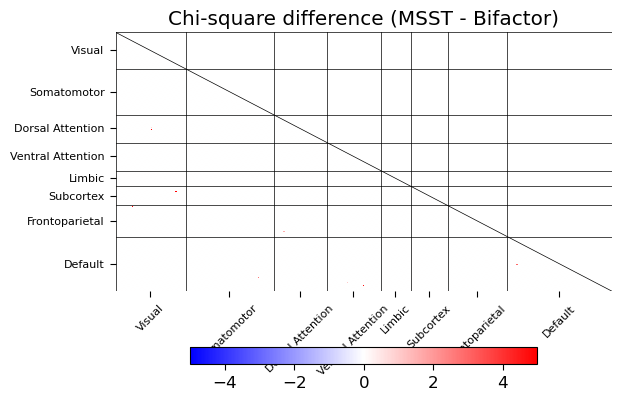

In [334]:
mat_df = get_empty_df_for_hmap('Schaefer')
edges_df = get_edge_summary(network_hem_order=True)
edges_df = generate_set_of_networks(edges_df)
edges_df.sort_values("edge", inplace=True)
edges_df['chi2_diff'] = diff_chi2_df.query('(fold == "fold0") & (gsr == "nogs")')['diff_chi2']
wide_df = get_wide_df_hmap(edges_df, value_col_name='chi2_diff')
mat_df = fill_mat_df(mat_df, wide_df, 'nogs')
fig, ax = plt.subplots()
draw_hmaps_fcs(
    mat_df,
    get_nodes_df('Schaefer'),
    'bwr',
    vmin=-5, vmax=5,
    ax=ax
)
ax.set_title('Chi-square difference (MSST - Bifactor)')

In [ ]:
long_df_chi2 = 

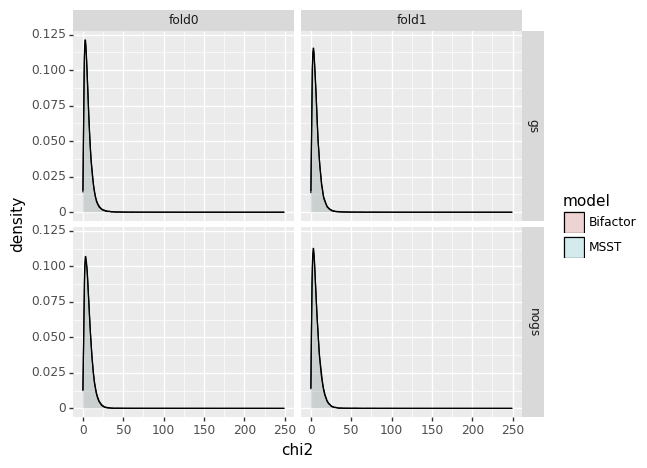

<Figure Size: (640 x 480)>

In [326]:
g = (
    ggplot(long_df_chi2, aes('chi2', fill='model'))
    + geom_density(alpha=0.2)
    + facet_grid('gsr ~ fold')
)
g

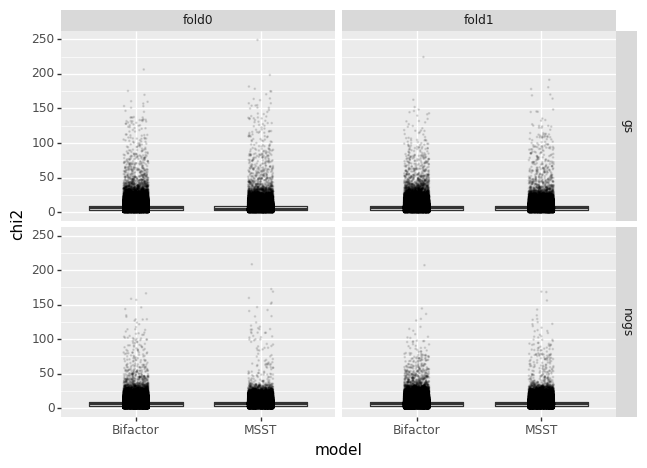

<Figure Size: (640 x 480)>

In [325]:
g = (
    ggplot(long_df_chi2, aes('model', 'chi2'))
    + geom_boxplot(outlier_color='')
    + geom_jitter(width=0.1, size=0.1, alpha=0.1)
    + facet_grid('gsr ~ fold')
)
g

In [329]:
diff_chi2_df.groupby(['gsr', 'fold']).apply(lambda x: wilcoxon(x['Bifactor'], x['MSST'], nan_policy='omit'))

gsr   fold 
gs    fold0    (0.0, 3.754355485402132e-175)
      fold1    (0.0, 2.113777616974171e-171)
nogs  fold0      (0.0, 5.78868443344458e-67)
      fold1    (0.0, 3.475166342526359e-120)
dtype: object

In [328]:
diff_chi2_df.groupby(['gsr', 'fold']).apply(lambda x: ttest_rel(x['Bifactor'], x['MSST'], nan_policy='omit'))

gsr   fold 
gs    fold0     (-20.050146708376218, 3.32838631783535e-89)
      fold1    (-17.220873178188913, 2.456586967889754e-66)
nogs  fold0    (-11.734946456840646, 8.933739227481257e-32)
      fold1    (-17.062325027591378, 3.630143220772852e-65)
dtype: object

In [317]:
diff_chi2_df.groupby(['gsr', 'fold'])['diff_chi2'].agg(['mean', 'std', 'median'])

mean       std  median
gsr  fold                             
gs   fold0  0.062592  0.885392     0.0
     fold1  0.046894  0.761080     0.0
nogs fold0  0.025918  0.640685     0.0
     fold1  0.046131  0.790840     0.0

(array([0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        3.26232e+05, 3.83000e+02, 2.50000e+02, 2.08000e+02, 1.79000e+02,
        1.53000e+02, 1.08000e+02, 1.12000e+02, 8.20000e+01, 9.70000e+01,
        6.80000e+01, 5.80000e+01, 4.40000e+01, 4.60000e+01, 2.30000e+01,
        3.10000e+01, 2.10000e+01, 3.10000e+01, 1.30000e+01]),
 array([-20., -19., -18., -17., -16., -15., -14., -13., -12., -11., -10.,
         -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,
         13.,  14.,  15.,  16.,  17.,  18.,  19.]),
 <BarContainer object of 39 artists>)

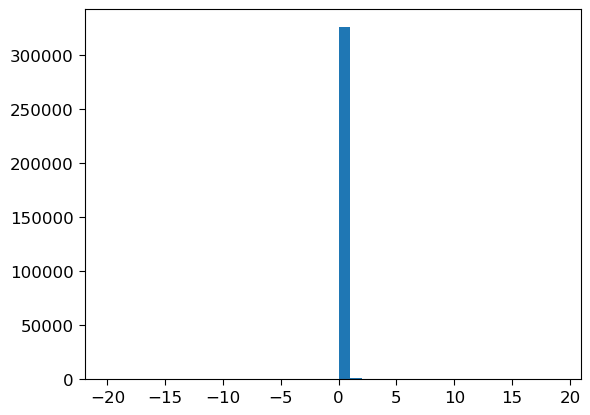

In [314]:
plt.hist(diff_chi2_df['diff_chi2'], bins=np.arange(-20, 20, 1))

In [292]:
bifactor_df

edge  fold0_nogs  fold1_nogs   fold0_gs   fold1_gs     model
0          0    2.193756    0.589802   2.417409   3.354554  Bifactor
1          1    8.607510    0.746197   9.585262  14.066281  Bifactor
2          2    7.648904    0.690813   1.641846   6.061693  Bifactor
3          3   10.556317    2.937423   8.476197   5.688819  Bifactor
4          4   12.196931    3.797905  14.127872  24.271173  Bifactor
...      ...         ...         ...        ...        ...       ...
93091  93091    2.695391    6.099390   3.533390   5.187479  Bifactor
93092  93092    2.088919    5.276545   1.392049  15.015286  Bifactor
93093  93093    3.672352   19.374231  22.536442  10.753865  Bifactor
93094  93094   14.390624   10.551322  14.895329  12.165841  Bifactor
93095  93095    4.164074   10.591252   5.929819   1.701122  Bifactor

[93096 rows x 6 columns]

In [283]:
nogs_bifactor_fit.shape

(93096, 15)

In [294]:
nogs_msst_fit_fold0 = np.load(
    '/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/split_half_cv/fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_203_Fold_0_nogs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_seed0_2024-12-12 13:17:41_combined.npy'
)

In [293]:
gs_msst_fit_fold0 = np.load(
    '/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/split_half_cv/fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_203_Fold_0_gs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_seed0_2024-12-12 13:33:38_combined.npy'
)

In [295]:
nogs_msst_fit_fold1 = np.load(
    '/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/split_half_cv/fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_204_Fold_1_nogs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_seed0_2024-12-12 13:32:33_combined.npy'
)

In [296]:
gs_msst_fit_fold1 = np.load(
    '/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/split_half_cv/fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_204_Fold_1_gs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_seed0_2024-12-12 13:44:24_combined.npy'
)

In [266]:
from scipy.stats import wilcoxon
wilcoxon(nogs_msst_fit[:, 2], nogs_bifactor_fit[:, 2], nan_policy='omit')

WilcoxonResult(statistic=1433086289.0, pvalue=9.045701859528231e-173)

In [274]:
long_chi2_df = pd.concat(
    [
        pd.DataFrame(nogs_msst_fit[:, 2], columns=['chi2']).assign(model='MSST'),
        pd.DataFrame(nogs_bifactor_fit[:, 2], columns=['chi2']).assign(model='Bifactor'),
    ],
    axis=0
)

In [20]:
fit_list = ['CFI', 'RMSEA', 'SRMR']

In [16]:
fit_index = [FIT_INDICES.index(i) for i in ['CFI', 'RMSEA', 'SRMR']]

In [22]:
msst_nogs_fit_df = pd.DataFrame(nogs_msst_fit[:, fit_index], columns=fit_list)
msst_nogs_fit_df['model'] = 'MSST'

In [23]:
bifactor_nogs_fit_df = pd.DataFrame(nogs_bifactor_fit[:, fit_index], columns=fit_list)
bifactor_nogs_fit_df['model'] = 'Bifactor'

In [24]:
concat_df = pd.concat([msst_nogs_fit_df, bifactor_nogs_fit_df], axis=0)

In [230]:
long_concat_df = concat_df.reset_index().rename(
    columns={'index': 'edge'}
).melt(
    id_vars=['edge', 'model'],
    value_vars=fit_list, var_name='fit_index'
)

In [245]:
from scipy.stats import ttest_rel
long_concat_df.pivot(
    index=['edge', 'fit_index'], columns='model', values='value'
).reset_index().dropna().groupby('fit_index').apply(
    lambda x: ttest_rel(x['MSST'], x['Bifactor'], nan_policy='omit').statistic
)

fit_index
CFI     -21.516544
RMSEA   -29.109099
SRMR    -28.164664
dtype: float64

In [246]:
wide_fits_df = long_concat_df.pivot(
    index=['edge', 'fit_index'], columns='model', values='value'
).reset_index()

In [248]:
wide_fits_df['diff_value'] = wide_fits_df['Bifactor'] - wide_fits_df['MSST']

In [249]:
wide_fits_df

model    edge fit_index  Bifactor      MSST  diff_value
0           0       CFI  1.000000  1.000000    0.000000
1           0     RMSEA  0.000000  0.000000    0.000000
2           0      SRMR  0.041367  0.037928    0.003439
3           1       CFI  0.988441  0.987789    0.000651
4           1     RMSEA  0.075328  0.082936   -0.007608
...       ...       ...       ...       ...         ...
279283  93094     RMSEA  0.113121       NaN         NaN
279284  93094      SRMR  0.086948       NaN         NaN
279285  93095       CFI  0.999487  0.995965    0.003522
279286  93095     RMSEA  0.014215  0.048751   -0.034536
279287  93095      SRMR  0.048900  0.059416   -0.010515

[279288 rows x 5 columns]

In [ ]:
mat_df = get_empty_df_for_hmap('Schaefer')
wide_df = get_wide_df_hmap(wide_fits_df.query('fit_index == "RMSEA"'), value_col_name='icc2')
mat_df = fill_mat_df(mat_df, wide_df, 'nogs')

In [ ]:
draw_hmaps_fcs()

In [34]:
nogs_msst_params = np.load(
    '/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/parameters/combined/split_half_cv/params_Model_onlyFC_Trait_None_Scale_None_sampleN_203_Fold_0_nogs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_seed0_2024-12-12 13:17:41_combined.npy'
)

In [116]:
nogs_bf_params_fold0 = np.load(
    '/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/parameters/combined/params_Model_onlyFC_Trait_None_Scale_None_sampleN_203_Fold_0_nogs_edgeN_93096_Est_MLR_z_Bifactor_OutStd_lavaan_session_split_half_family_seed0_2025-05-29 08:09:33_combined.npy'
)

In [179]:
nogs_bf_params_fold1 = np.load(
    '/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/parameters/combined/split_half_cv/params_Model_onlyFC_Trait_None_Scale_None_sampleN_204_Fold_1_nogs_edgeN_93096_Est_MLR_z_Bifactor_OutStd_lavaan_session_split_half_family_seed0_2025-05-29 08:10:54_combined.npy'
)

In [ ]:
single_trait_loadings = np.load(
    '/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/parameters/combined/split_half_cv/params_Model_onlyFC_Trait_None_Scale_None_sampleN_203_Fold_0_nogs_edgeN_93096_Est_MLR_z_controlling_none_OutStd_session_split_half_family_2024-11-25 14:23:56_combined.npy'
)

In [122]:
bifactor_params = pd.read_csv(
    '/home/cezanne/t-haitani/hcp_data/derivatives/Python/fa_result/reliability/model_onlyFC_controlling_None_CovCor_lavaan_Bifactor_session.csv'
).iloc[:, 1:]

In [93]:
nogs_msst_params.shape

(93096, 13, 5)

In [92]:
single_trait_loadings.shape

(93096, 8, 3)

In [123]:
bifactor_params

lhs  op rhs
0   o1  =~  s1
1   o1  =~  s2
2   o2  =~  s3
3   o2  =~  s4
4   ff  =~  s1
5   ff  =~  s2
6   ff  =~  s3
7   ff  =~  s4
8   s1  ~~  s1
9   s2  ~~  s2
10  s3  ~~  s3
11  s4  ~~  s4
12  o1  ~~  o2
13  o1  ~~  ff
14  o2  ~~  ff
15  o1  ~~  o1
16  o2  ~~  o2
17  ff  ~~  ff

In [128]:
item_error_vars = bifactor_params.query('(lhs.isin(["s1", "s2", "s3", "s4"])) & (op == "~~")').index

In [129]:
item_error_vars

Index([8, 9, 10, 11], dtype='int64')

In [125]:
cf_loadings_index = bifactor_params.query('(lhs == "ff") & (op == "=~")').index

In [126]:
cf_loadings_index

Index([4, 5, 6, 7], dtype='int64')

In [135]:
nogs_bf_params_fold0.shape

(93096, 18, 5)

In [ ]:
icc2s_fold1 = np.empty(shape=nogs_bf_params_fold1.shape[0])
icc2s[:] = np.nan
for i in range(nogs_bf_params_fold1.shape[0]):
    eff_error = 1 / np.sum(nogs_bf_params_fold1[i, cf_loadings_index, 0] ** 2 / nogs_bf_params_fold1[i, item_error_vars, 0])
    icc2s[i] = 1 / (1 + eff_error)

In [176]:
icc2s = np.empty(shape=nogs_bf_params_fold0.shape[0])
icc2s[:] = np.nan
for i in range(nogs_bf_params_fold0.shape[0]):
    eff_error = 1 / np.sum(nogs_bf_params_fold0[i, cf_loadings_index, 0] ** 2 / nogs_bf_params_fold0[i, item_error_vars, 0])
    icc2s[i] = 1 / (1 + eff_error)

In [3]:
def get_icc2(params_array):
    icc2s = np.empty(shape=params_array.shape[0])
    icc2s[:] = np.nan
    for i in range(params_array.shape[0]):
        eff_error = 1 / np.sum(params_array[i, cf_loadings_index, 0] ** 2 / params_array[i, item_error_vars, 0])
        icc2s[i] = 1 / (1 + eff_error)
    return icc2s

In [181]:
icc2s_fold1 = get_icc2(nogs_bf_params_fold1)

In [182]:
icc2s

array([0.80769906, 0.88476373, 0.8442112 , ..., 0.84220412, 0.82732644,
       0.84884843])

In [184]:
np.corrcoef(icc2s_fold1, icc2s)

array([[1.        , 0.91577237],
       [0.91577237, 1.        ]])

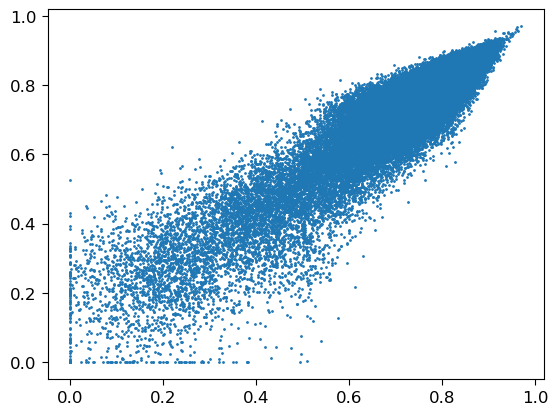

In [183]:
plt.scatter(icc2s_fold1, icc2s, s=1)

In [142]:
reload(postprocess)
from postprocess import *

In [139]:
NODE_SUMMARY_PATH

'/home/cezanne/t-haitani/hcp_data/derivatives/parcellation/schaefer_s2_summary_xyz.csv'

In [143]:
NETWORK_ORDER_DICT_PUB_SCHAEFER

{'Visual': 0,
 'Somatomotor': 1,
 'Dorsal Attention': 2,
 'Ventral Attention': 3,
 'Limbic': 4,
 'Subcortex': 5,
 'Frontoparietal': 6,
 'Default': 7}

In [149]:
mat_df = get_empty_df_for_hmap('Schaefer')
edges_df = get_edge_summary(network_hem_order=True)
edges_df = generate_set_of_networks(edges_df)
edges_df.sort_values("edge", inplace=True)
edges_df['icc2'] = icc2s
wide_df = get_wide_df_hmap(edges_df, value_col_name='icc2')
mat_df = fill_mat_df(mat_df, wide_df, 'nogs')

In [173]:
mat_df_cons = get_empty_df_for_hmap('Schaefer')
wide_df_cons = get_wide_df_hmap(edges_df_cons, value_col_name='index_mean_nogs')
mat_df_cons = fill_mat_df(mat_df_cons, wide_df_cons, 'nogs')

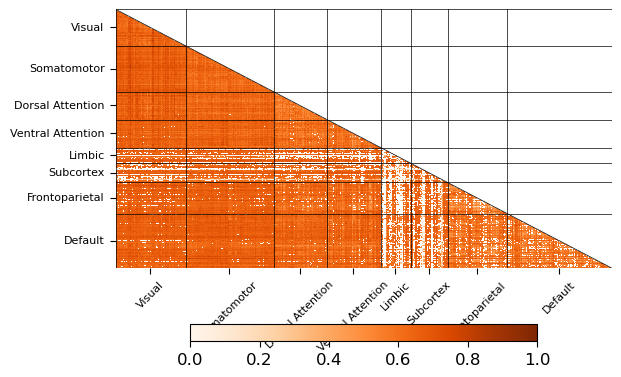

In [175]:
draw_hmaps_fcs(
    mat_df - mat_df_cons,
    get_nodes_df('Schaefer'),
    'Oranges'
)

In [174]:
mat_df - mat_df_cons

node                            7Networks_LH_Vis_1  7Networks_LH_Vis_2  \
node                                                                     
7Networks_LH_Vis_1                             NaN                 NaN   
7Networks_LH_Vis_2                        0.363277                 NaN   
7Networks_LH_Vis_3                        0.332825            0.368396   
7Networks_LH_Vis_4                        0.368105            0.378081   
7Networks_LH_Vis_5                        0.357108            0.364045   
...                                            ...                 ...   
7Networks_RH_Default_pCunPCC_5            0.366098            0.330803   
7Networks_RH_Default_pCunPCC_6            0.357175            0.325443   
7Networks_RH_Default_pCunPCC_7            0.364564            0.349423   
7Networks_RH_Default_pCunPCC_8            0.345570            0.357787   
7Networks_RH_Default_pCunPCC_9            0.381073            0.335433   

node                            7Networks_LH_Vis_3  7Networks_LH_Vis_4  \
node                                                                     
7Networks_LH_Vis_1                             NaN                 NaN   
7Networks_LH_Vis_2                             NaN                 NaN   
7Networks_LH_Vis_3                             NaN                 NaN   
7Networks_LH_Vis_4                        0.345032                 NaN   
7Networks_LH_Vis_5                        0.358194            0.364847   
...                                            ...                 ...   
7Networks_RH_Default_pCunPCC_5            0.336645            0.326569   
7Networks_RH_Default_pCunPCC_6                 NaN            0.330874   
7Networks_RH_Default_pCunPCC_7            0.332961            0.357681   
7Networks_RH_Default_pCunPCC_8                 NaN            0.333036   
7Networks_RH_Default_pCunPCC_9            0.340330            0.313227   

node                            7Networks_LH_Vis_5  7Networks_LH_Vis_6  \
node                                                                     
7Networks_LH_Vis_1                             NaN                 NaN   
7Networks_LH_Vis_2                             NaN                 NaN   
7Networks_LH_Vis_3                             NaN                 NaN   
7Networks_LH_Vis_4                             NaN                 NaN   
7Networks_LH_Vis_5                             NaN                 NaN   
...                                            ...                 ...   
7Networks_RH_Default_pCunPCC_5            0.304915            0.343331   
7Networks_RH_Default_pCunPCC_6            0.316778            0.330402   
7Networks_RH_Default_pCunPCC_7            0.339606                 NaN   
7Networks_RH_Default_pCunPCC_8            0.318059                 NaN   
7Networks_RH_Default_pCunPCC_9            0.339124            0.333355   

node                            7Networks_LH_Vis_7  7Networks_LH_Vis_8  \
node                                                                     
7Networks_LH_Vis_1                             NaN                 NaN   
7Networks_LH_Vis_2                             NaN                 NaN   
7Networks_LH_Vis_3                             NaN                 NaN   
7Networks_LH_Vis_4                             NaN                 NaN   
7Networks_LH_Vis_5                             NaN                 NaN   
...                                            ...                 ...   
7Networks_RH_Default_pCunPCC_5            0.350308            0.320728   
7Networks_RH_Default_pCunPCC_6            0.348084            0.321391   
7Networks_RH_Default_pCunPCC_7            0.350923            0.345039   
7Networks_RH_Default_pCunPCC_8            0.346670                 NaN   
7Networks_RH_Default_pCunPCC_9            0.357027            0.326561   

node                            7Networks_LH_Vis_9  7Networks_LH_Vis_10  ...  \
node                                                                

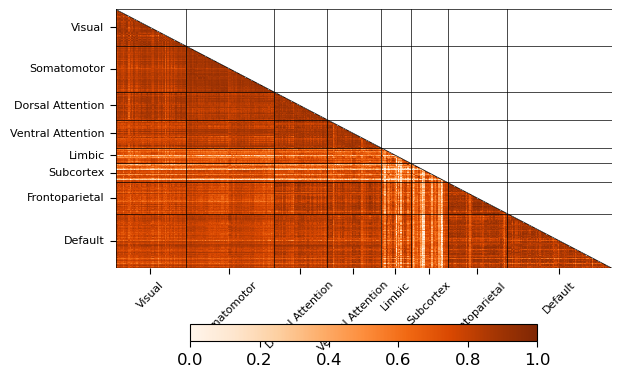

In [151]:
draw_hmaps_fcs(
    mat_df,
    get_nodes_df('Schaefer'),
    'Oranges'
)

In [150]:
mat_df

node                            7Networks_LH_Vis_1  7Networks_LH_Vis_2  \
node                                                                     
7Networks_LH_Vis_1                             NaN                 NaN   
7Networks_LH_Vis_2                        0.807699                 NaN   
7Networks_LH_Vis_3                        0.884764            0.803834   
7Networks_LH_Vis_4                        0.844211            0.794193   
7Networks_LH_Vis_5                        0.856851            0.811917   
...                                            ...                 ...   
7Networks_RH_Default_pCunPCC_5            0.769510            0.816310   
7Networks_RH_Default_pCunPCC_6            0.721868            0.752244   
7Networks_RH_Default_pCunPCC_7            0.703928            0.666630   
7Networks_RH_Default_pCunPCC_8            0.740720            0.754447   
7Networks_RH_Default_pCunPCC_9            0.806614            0.811467   

node                            7Networks_LH_Vis_3  7Networks_LH_Vis_4  \
node                                                                     
7Networks_LH_Vis_1                             NaN                 NaN   
7Networks_LH_Vis_2                             NaN                 NaN   
7Networks_LH_Vis_3                             NaN                 NaN   
7Networks_LH_Vis_4                        0.861425                 NaN   
7Networks_LH_Vis_5                        0.876600            0.883431   
...                                            ...                 ...   
7Networks_RH_Default_pCunPCC_5            0.795011            0.808075   
7Networks_RH_Default_pCunPCC_6            0.753864            0.739165   
7Networks_RH_Default_pCunPCC_7            0.739494            0.750560   
7Networks_RH_Default_pCunPCC_8            0.739345            0.757996   
7Networks_RH_Default_pCunPCC_9            0.831417            0.857934   

node                            7Networks_LH_Vis_5  7Networks_LH_Vis_6  \
node                                                                     
7Networks_LH_Vis_1                             NaN                 NaN   
7Networks_LH_Vis_2                             NaN                 NaN   
7Networks_LH_Vis_3                             NaN                 NaN   
7Networks_LH_Vis_4                             NaN                 NaN   
7Networks_LH_Vis_5                             NaN                 NaN   
...                                            ...                 ...   
7Networks_RH_Default_pCunPCC_5            0.834214            0.814982   
7Networks_RH_Default_pCunPCC_6            0.798334            0.783910   
7Networks_RH_Default_pCunPCC_7            0.774836            0.764868   
7Networks_RH_Default_pCunPCC_8            0.774492            0.761422   
7Networks_RH_Default_pCunPCC_9            0.849562            0.816617   

node                            7Networks_LH_Vis_7  7Networks_LH_Vis_8  \
node                                                                     
7Networks_LH_Vis_1                             NaN                 NaN   
7Networks_LH_Vis_2                             NaN                 NaN   
7Networks_LH_Vis_3                             NaN                 NaN   
7Networks_LH_Vis_4                             NaN                 NaN   
7Networks_LH_Vis_5                             NaN                 NaN   
...                                            ...                 ...   
7Networks_RH_Default_pCunPCC_5            0.755999            0.804391   
7Networks_RH_Default_pCunPCC_6            0.723680            0.772513   
7Networks_RH_Default_pCunPCC_7            0.670322            0.725343   
7Networks_RH_Default_pCunPCC_8            0.734059            0.765060   
7Networks_RH_Default_pCunPCC_9            0.795807            0.811043   

node                            7Networks_LH_Vis_9  7Networks_LH_Vis_10  ...  \
node                                                                

In [594]:
reload(postprocess)
from postprocess import *

In [185]:
edges_df_cons_fold1 = calc_rel_lst_network(
    filename_param_list=[
        'params_Model_onlyFC_Trait_None_Scale_None_sampleN_204_Fold_1_nogs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_seed0_2024-12-12 13:32:33_combined.npy',
        'params_Model_onlyFC_Trait_None_Scale_None_sampleN_204_Fold_1_gs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_seed0_2024-12-12 13:44:24_combined.npy'
    ],
    param_order_filename='model_onlyFC_controlling_None_CovCor_lavaan_MSST_session.csv',
    return_df=True
)

In [188]:
np.corrcoef(edges_df_cons_fold1['index_mean_nogs'], edges_df_cons['index_mean_nogs'])

array([[nan, nan],
       [nan, nan]])

In [189]:
ma.corrcoef(ma.masked_invalid(edges_df_cons_fold1['index_mean_nogs']), ma.masked_invalid(edges_df_cons['index_mean_nogs']))

masked_array(
  data=[[1.0, 0.8276054035355002],
        [0.8276054035355002, 1.0]],
  mask=[[False, False],
        [False, False]],
  fill_value=1e+20)

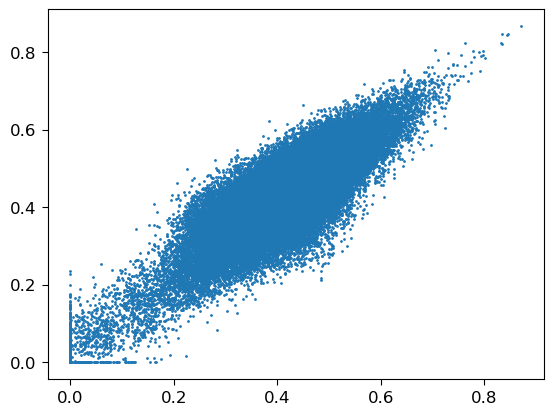

In [187]:
plt.scatter(edges_df_cons_fold1['index_mean_nogs'], edges_df_cons['index_mean_nogs'], s=1)

In [654]:
reload(postprocess)
from postprocess import *

In [670]:
edges_df_trait_all_ind_order_in_day_fold1 = calc_rel_lst_network(
    filename_param_list=[
        get_latest_file_from_condition(data_type='parameters', order_in_day=True, msst=True, select_cb=True, fold=1).name,
        get_latest_file_from_condition(data_type='parameters', order_in_day=True, msst=True, select_cb=True, gsr_type='_gs_', fold=1).name
    ],
    param_order_filename='model_onlyFC_controlling_None_CovCor_lavaan_addMarker_MSST_OrderFactor_session.csv',
    return_df=True,
    return_all_indicators=True,
    rel_type='cons'
)

/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/parameters/combined/split_half_cv/params_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_1_nogs_edgeN_93096_Est_MLR_z_controllingBefore__OrderInDay_MSST_OutStd_lavaan_addMarker_session_split_half_family_SelectCB_seed0_2025-06-01 06:57:07_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/parameters/combined/split_half_cv/params_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_1_gs_edgeN_93096_Est_MLR_z_controllingBefore__OrderInDay_MSST_OutStd_lavaan_addMarker_session_split_half_family_SelectCB_seed0_2025-06-01 07:01:08_combined.npy


In [668]:
edges_df_trait_all_ind_order_in_day = calc_rel_lst_network(
    filename_param_list=[
        get_latest_file_from_condition(data_type='parameters', order_in_day=True, msst=True, select_cb=True).name,
        get_latest_file_from_condition(data_type='parameters', order_in_day=True, msst=True, select_cb=True, gsr_type='_gs_').name
    ],
    param_order_filename='model_onlyFC_controlling_None_CovCor_lavaan_addMarker_MSST_OrderFactor_session.csv',
    return_df=True,
    return_all_indicators=True,
    rel_type='cons'
)

/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/parameters/combined/split_half_cv/params_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_0_nogs_edgeN_93096_Est_MLR_z_controllingBefore__OrderInDay_MSST_OutStd_lavaan_addMarker_session_split_half_family_SelectCB_seed0_2025-06-01 06:54:57_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/parameters/combined/split_half_cv/params_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_0_gs_edgeN_93096_Est_MLR_z_controllingBefore__OrderInDay_MSST_OutStd_lavaan_addMarker_session_split_half_family_SelectCB_seed0_2025-06-01 06:57:27_combined.npy


In [659]:
edges_df_error_all_ind_order_in_day = calc_rel_lst_network(
    filename_param_list=[
        get_latest_file_from_condition(data_type='parameters', order_in_day=True, msst=True, select_cb=True).name,
        get_latest_file_from_condition(data_type='parameters', order_in_day=True, msst=True, select_cb=True, gsr_type='_gs_').name
    ],
    param_order_filename='model_onlyFC_controlling_None_CovCor_lavaan_addMarker_MSST_OrderFactor_session.csv',
    return_df=True,
    return_all_indicators=True,
    rel_type='error'
)

/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/parameters/combined/split_half_cv/params_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_0_nogs_edgeN_93096_Est_MLR_z_controllingBefore__OrderInDay_MSST_OutStd_lavaan_addMarker_session_split_half_family_SelectCB_seed0_2025-06-01 06:54:57_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/parameters/combined/split_half_cv/params_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_0_gs_edgeN_93096_Est_MLR_z_controllingBefore__OrderInDay_MSST_OutStd_lavaan_addMarker_session_split_half_family_SelectCB_seed0_2025-06-01 06:57:27_combined.npy


In [655]:
edges_df_error_all_ind = calc_rel_lst_network(
    filename_param_list=[
        get_latest_file_from_condition(data_type='parameters', order_in_day=False, msst=True, select_cb=True).name,
        get_latest_file_from_condition(data_type='parameters', order_in_day=False, msst=True, select_cb=True, gsr_type='_gs_').name
    ],
    param_order_filename='model_onlyFC_controlling_None_CovCor_lavaan_MSST_session.csv',
    return_df=True,
    return_all_indicators=True,
    rel_type='error'
)

/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/parameters/combined/split_half_cv/params_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_0_nogs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-06-01 06:46:29_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/parameters/combined/split_half_cv/params_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_0_gs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-06-01 06:48:35_combined.npy


In [648]:
edges_df_spec_all_ind = calc_rel_lst_network(
    filename_param_list=[
        get_latest_file_from_condition(data_type='parameters', order_in_day=False, msst=True, select_cb=True).name,
        get_latest_file_from_condition(data_type='parameters', order_in_day=False, msst=True, select_cb=True, gsr_type='_gs_').name
    ],
    param_order_filename='model_onlyFC_controlling_None_CovCor_lavaan_MSST_session.csv',
    return_df=True,
    return_all_indicators=True,
    rel_type='spec'
)

/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/parameters/combined/split_half_cv/params_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_0_nogs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-06-01 06:46:29_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/parameters/combined/split_half_cv/params_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_0_gs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-06-01 06:48:35_combined.npy


In [649]:
edges_df_spec_all_ind.columns

Index(['edge', 'node1', 'node1_hem', 'node1_net', 'node1_net_sub', 'node2',
       'node2_hem', 'node2_net', 'node2_net_sub', 'session_1_nogs',
       'session_2_nogs', 'session_3_nogs', 'session_4_nogs', 'session_1_gs',
       'session_2_gs', 'session_3_gs', 'session_4_gs'],
      dtype='object')

In [673]:
edges_df_cons_all_ind_fold1 = calc_rel_lst_network(
    filename_param_list=[
        get_latest_file_from_condition(data_type='parameters', order_in_day=False, msst=True, select_cb=True, fold=1).name,
        get_latest_file_from_condition(data_type='parameters', order_in_day=False, msst=True, select_cb=True, gsr_type='_gs_', fold=1).name
    ],
    param_order_filename='model_onlyFC_controlling_None_CovCor_lavaan_MSST_session.csv',
    return_df=True,
    return_all_indicators=True
)

/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/parameters/combined/split_half_cv/params_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_1_nogs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-06-01 06:48:17_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/parameters/combined/split_half_cv/params_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_1_gs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-06-01 06:51:06_combined.npy


In [623]:
edges_df_cons_all_ind = calc_rel_lst_network(
    filename_param_list=[
        get_latest_file_from_condition(data_type='parameters', order_in_day=False, msst=True, select_cb=True).name,
        get_latest_file_from_condition(data_type='parameters', order_in_day=False, msst=True, select_cb=True, gsr_type='_gs_').name
    ],
    param_order_filename='model_onlyFC_controlling_None_CovCor_lavaan_MSST_session.csv',
    return_df=True,
    return_all_indicators=True
)

/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/parameters/combined/split_half_cv/params_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_0_nogs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-06-01 06:46:29_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/parameters/combined/split_half_cv/params_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_0_gs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-06-01 06:48:35_combined.npy


In [698]:
gs_sessions = [f'session_{i}_gs' for i in range(1, 5)]
nogs_sessions = [f'session_{i}_nogs' for i in range(1, 5)]

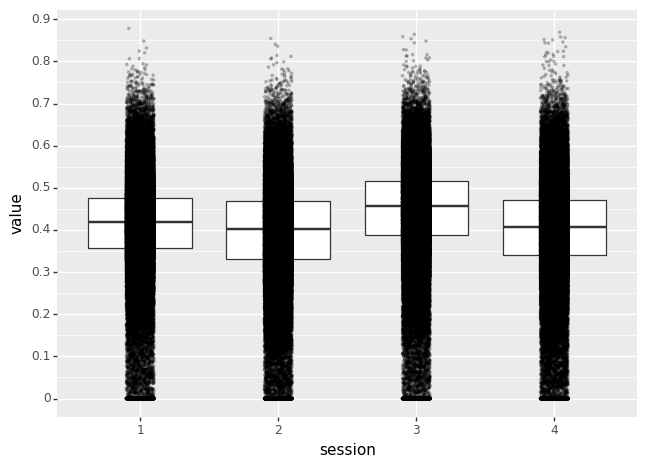

<Figure Size: (640 x 480)>

In [671]:
visualize_boxplot(edges_df_trait_all_ind_order_in_day_fold1)

In [684]:
edges_df_cons_all_ind[['session_1_nogs', 'session_3_nogs']].corr()

session_1_nogs  session_3_nogs
session_1_nogs        1.000000        0.863605
session_3_nogs        0.863605        1.000000

In [685]:
edges_df_cons_all_ind[['session_3_nogs', 'session_4_nogs']].corr()

session_3_nogs  session_4_nogs
session_3_nogs        1.000000        0.859737
session_4_nogs        0.859737        1.000000

In [683]:
edges_df_cons_all_ind[['session_1_nogs', 'session_2_nogs']].corr()

session_1_nogs  session_2_nogs
session_1_nogs        1.000000        0.869459
session_2_nogs        0.869459        1.000000

In [686]:
edges_df_cons_all_ind

edge                           node1 node1_hem node1_net  \
0          0              7Networks_LH_Vis_1        LH    Visual   
1          1              7Networks_LH_Vis_1        LH    Visual   
2          2              7Networks_LH_Vis_1        LH    Visual   
3          3              7Networks_LH_Vis_1        LH    Visual   
4          4              7Networks_LH_Vis_1        LH    Visual   
...      ...                             ...       ...       ...   
93091  93091  7Networks_RH_Default_pCunPCC_6        RH   Default   
93092  93092  7Networks_RH_Default_pCunPCC_6        RH   Default   
93093  93093  7Networks_RH_Default_pCunPCC_7        RH   Default   
93094  93094  7Networks_RH_Default_pCunPCC_7        RH   Default   
93095  93095  7Networks_RH_Default_pCunPCC_8        RH   Default   

      node1_net_sub                           node2 node2_hem node2_net  \
0              None              7Networks_LH_Vis_2        LH    Visual   
1              None              7Networks_LH_Vis_3        LH    Visual   
2              None              7Networks_LH_Vis_4        LH    Visual   
3              None              7Networks_LH_Vis_5        LH    Visual   
4              None              7Networks_LH_Vis_6        LH    Visual   
...             ...                             ...       ...       ...   
93091       pCunPCC  7Networks_RH_Default_pCunPCC_8        RH   Default   
93092       pCunPCC  7Networks_RH_Default_pCunPCC_9        RH   Default   
93093       pCunPCC  7Networks_RH_Default_pCunPCC_8        RH   Default   
93094       pCunPCC  7Networks_RH_Default_pCunPCC_9        RH   Default   
93095       pCunPCC  7Networks_RH_Default_pCunPCC_9        RH   Default   

      node2_net_sub  session_1_nogs  session_2_nogs  session_3_nogs  \
0              None        0.536802        0.340952        0.506251   
1              None        0.567023        0.460206        0.579450   
2              None        0.537943        0.394831        0.519055   
3              None        0.497003        0.398529        0.520836   
4              None        0.515753        0.423745        0.516579   
...             ...             ...             ...             ...   
93091       pCunPCC        0.637109        0.598912        0.645663   
93092       pCunPCC        0.570942        0.466305        0.525119   
93093       pCunPCC        0.488377        0.500500        0.593097   
93094       pCunPCC        0.470029        0.381708        0.503405   
93095       pCunPCC        0.583632        0.546633        0.606579   

       session_4_nogs  session_1_gs  session_2_gs  session_3_gs  session_4_gs  \
0            0.401939      0.557983      0.407569      0.538054      0.474298   
1            0.513323      0.628646      0.493707      0.610128      0.594060   
2            0.446977      0.602404      0.400130      0.464798      0.473966   
3            0.420642      0.540527      0.398383      0.446309      0.467839   
4            0.447816      0.535561      0.417876      0.511683      0.437446   
...               ...           ...           ...           ...           ...   
93091        0.527520      0.656538      0.715601      0.689489      0.635024   
93092        0.477916      0.632989      0.642670      0.607990      0.611995   
93093        0.478497      0.541097      0.661625      0.679478      0.555912   
93094        0.384350      0.465831      0.564317      0.623870      0.481824   
93095        0.489779      0.602746      0.630280      0.631814      0.588919   

       session_12_nogs_diff  session_34_nogs_diff  
0                  0.195850              0.104312  
1                  0.106817              0.066127  
2                  0.143112              0.072078  
3                  0.098474              0.100194  
4                  0.092008              0.068763  
...                     ...                   ...  
93091              0.038197              0.118143  
93092              0.104637              0.04720

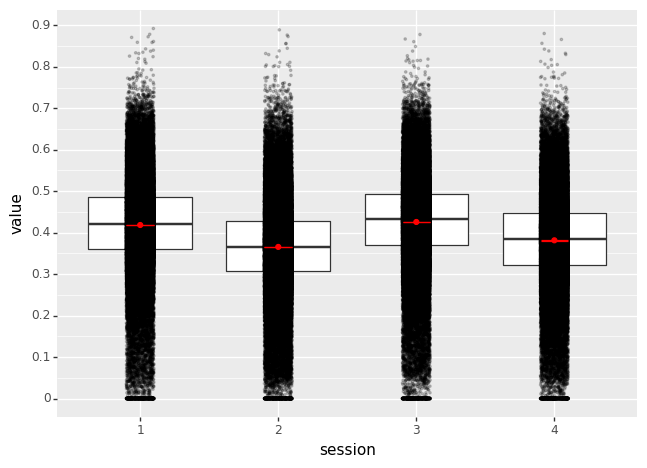

<Figure Size: (640 x 480)>

In [680]:
visualize_boxplot(edges_df_cons_all_ind)

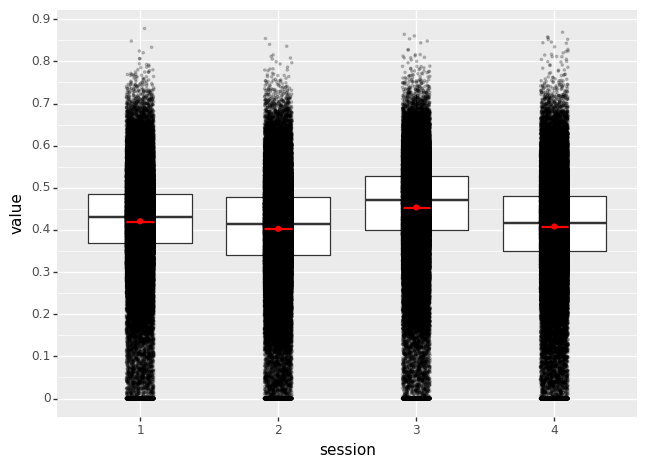

<Figure Size: (640 x 480)>

In [679]:
visualize_boxplot(edges_df_cons_all_ind_fold1)

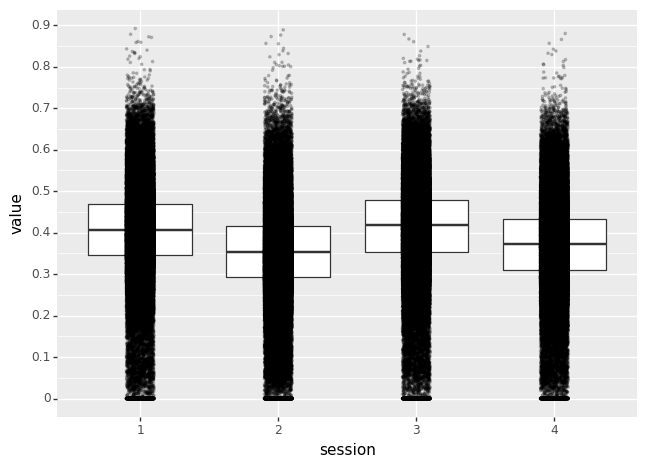

<Figure Size: (640 x 480)>

In [669]:
visualize_boxplot(edges_df_trait_all_ind_order_in_day)

In [62]:
output_df_order_in_day = pd.DataFrame()
for fold in [0, 1]:
    invalid_edges_dir = Path(f'/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/invalid_edges/Fold_{fold}')
    nogs_invalid_edges = np.loadtxt(invalid_edges_dir / 'errorOrder_nogs_invalid_edges_SRMR_0.08_RMSEA_0.08_CFI_0.9_loadings_from_0.4_to_0.9_2ndLoadings_from_0.7_to_1_controlling__.csv')
    gs_invalid_edges = np.loadtxt(invalid_edges_dir / 'errorOrder_gs_invalid_edges_SRMR_0.08_RMSEA_0.08_CFI_0.9_loadings_from_0.4_to_0.9_2ndLoadings_from_0.7_to_1_controlling__.csv')
    for effect_type in ['cons', 'spec', 'error']:
        df = calc_rel_lst_network(
            filename_param_list=[
                get_latest_file_from_condition(data_type='parameters', order_in_day=True, msst=True, select_cb=True, fold=fold, gsr_type='_nogs_').name,
                get_latest_file_from_condition(data_type='parameters', order_in_day=True, msst=True, select_cb=True, fold=fold, gsr_type='_gs_').name
            ],
            param_order_filename='model_onlyFC_controlling_None_CovCor_lavaan_addMarker_MSST_OrderFactor_session.csv',
            return_df=True,
            return_all_indicators=True,
            rel_type=effect_type            
        )
        long_df_gsr = visualize_boxplot(df, effect_type=effect_type, gsr_type='_gs_', fold=fold).query(
            '~(edge in @gs_invalid_edges)'
        )
        long_df_no_gsr = visualize_boxplot(df, effect_type=effect_type, gsr_type='_nogs_', fold=fold).query(
            '~(edge in @nogs_invalid_edges)'
        )
#         set_trace()
        output_df_order_in_day = pd.concat([output_df_order_in_day, long_df_gsr, long_df_no_gsr], axis=0)

/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/parameters/combined/split_half_cv/params_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_0_nogs_edgeN_93096_Est_MLR_z_controllingBefore__OrderInDay_MSST_OutStd_lavaan_addMarker_session_split_half_family_SelectCB_seed0_2025-06-01 06:54:57_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/parameters/combined/split_half_cv/params_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_0_gs_edgeN_93096_Est_MLR_z_controllingBefore__OrderInDay_MSST_OutStd_lavaan_addMarker_session_split_half_family_SelectCB_seed0_2025-06-01 06:57:27_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/parameters/combined/split_half_cv/params_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_0_nogs_edgeN_93096_Est_MLR_z_controllingBefore__OrderInDay_MSST_OutStd_lavaan_addMarker_session_split_half_family_SelectCB_seed0_2025-06-01 0

In [127]:
output_df_not_CB = pd.DataFrame()
fold_n_dict = {0: 203, 1: 204}
for fold in [0, 1]:
    invalid_edges_dir = Path(f'/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/invalid_edges/Fold_{fold}')
    nogs_invalid_edges = np.loadtxt(invalid_edges_dir / 'errorNone_nogs_invalid_edges_SRMR_0.08_RMSEA_0.08_CFI_0.9_loadings_from_0.4_to_0.9_2ndLoadings_from_0.7_to_1_controlling__.csv')
    gs_invalid_edges = np.loadtxt(invalid_edges_dir / 'errorNone_gs_invalid_edges_SRMR_0.08_RMSEA_0.08_CFI_0.9_loadings_from_0.4_to_0.9_2ndLoadings_from_0.7_to_1_controlling__.csv')
    for effect_type in ['cons', 'spec', 'error']:
        df = calc_rel_lst_network(
            filename_param_list=[
                get_latest_file_from_condition(data_type='parameters', order_in_day=False, msst=True, select_cb=False, fold=fold, gsr_type='_nogs_', sample_n=fold_n_dict[fold]).name,
                get_latest_file_from_condition(data_type='parameters', order_in_day=False, msst=True, select_cb=False, fold=fold, gsr_type='_gs_', sample_n=fold_n_dict[fold]).name
            ],
            param_order_filename='model_onlyFC_controlling_None_CovCor_lavaan_MSST_session.csv',
            return_df=True,
            return_all_indicators=True,
            rel_type=effect_type            
        )
        long_df_gsr = visualize_boxplot(df, effect_type=effect_type, gsr_type='_gs_', fold=fold).query(
            '~(edge in @gs_invalid_edges)'
        )
        long_df_no_gsr = visualize_boxplot(df, effect_type=effect_type, gsr_type='_nogs_', fold=fold).query(
            '~(edge in @nogs_invalid_edges)'
        )
#         set_trace()
        output_df_not_CB = pd.concat([output_df_not_CB, long_df_gsr, long_df_no_gsr], axis=0)

/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/parameters/combined/split_half_cv/params_Model_onlyFC_Trait_None_Scale_None_sampleN_203_Fold_0_nogs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_seed68_2024-12-12 13:30:56_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/parameters/combined/split_half_cv/params_Model_onlyFC_Trait_None_Scale_None_sampleN_203_Fold_0_gs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_seed68_2024-12-12 13:52:47_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/parameters/combined/split_half_cv/params_Model_onlyFC_Trait_None_Scale_None_sampleN_203_Fold_0_nogs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_seed68_2024-12-12 13:30:56_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/parameters/combined/split_half_cv/par

In [382]:
output_df

edge        variable     value         session              effect  \
0           0    session_1_gs  0.557983  Run 1 in day 1  Common consistency   
1           1    session_1_gs  0.628646  Run 1 in day 1  Common consistency   
2           2    session_1_gs  0.602404  Run 1 in day 1  Common consistency   
5           5    session_1_gs  0.253924  Run 1 in day 1  Common consistency   
6           6    session_1_gs  0.566855  Run 1 in day 1  Common consistency   
...       ...             ...       ...             ...                 ...   
372376  93088  session_4_nogs  0.347222  Run 2 in day 2        Random error   
372377  93089  session_4_nogs  0.445698  Run 2 in day 2        Random error   
372378  93090  session_4_nogs  0.387807  Run 2 in day 2        Random error   
372382  93094  session_4_nogs  0.415885  Run 2 in day 2        Random error   
372383  93095  session_4_nogs  0.490280  Run 2 in day 2        Random error   

       model     gsr_type         fold    Day    Run                day_effect  
0       None     With GSR  Exploratory  Day 1  Run 1  Day 1_Common consistency  
1       None     With GSR  Exploratory  Day 1  Run 1  Day 1_Common consistency  
2       None     With GSR  Exploratory  Day 1  Run 1  Day 1_Common consistency  
5       None     With GSR  Exploratory  Day 1  Run 1  Day 1_Common consistency  
6       None     With GSR  Exploratory  Day 1  Run 1  Day 1_Common consistency  
...      ...          ...          ...    ...    ...                       ...  
372376  None  Without GSR   Validation  Day 2  Run 2        Day 2_Random error  
372377  None  Without GSR   Validation  Day 2  Run 2        Day 2_Random error  
372378  None  Without GSR   Validation  Day 2  Run 2        Day 2_Random error  
372382  None  Without GSR   Validation  Day 2  Run 2        Day 2_Random error  
372383  None  Without GSR   Validation  Day 2  Run 2        Day 2_Random error  

[2947980 rows x 11 columns]

In [397]:
output_df_all = modify_output_df(output_df_all)

In [399]:
len(output_df_all) / 93096

48.0

In [400]:
output_df_all

edge        variable     value         session              effect  \
0           0    session_1_gs  0.557983  Run 1 in day 1  Common consistency   
1           1    session_1_gs  0.628646  Run 1 in day 1  Common consistency   
2           2    session_1_gs  0.602404  Run 1 in day 1  Common consistency   
3           3    session_1_gs  0.540527  Run 1 in day 1  Common consistency   
4           4    session_1_gs  0.535561  Run 1 in day 1  Common consistency   
...       ...             ...       ...             ...                 ...   
372379  93091  session_4_nogs       NaN  Run 2 in day 2        Random error   
372380  93092  session_4_nogs       NaN  Run 2 in day 2        Random error   
372381  93093  session_4_nogs  0.409960  Run 2 in day 2        Random error   
372382  93094  session_4_nogs  0.415885  Run 2 in day 2        Random error   
372383  93095  session_4_nogs  0.490280  Run 2 in day 2        Random error   

       model     gsr_type         fold    Day    Run                day_effect  
0       None     With GSR  Exploratory  Day 1  Run 1  Day 1_Common consistency  
1       None     With GSR  Exploratory  Day 1  Run 1  Day 1_Common consistency  
2       None     With GSR  Exploratory  Day 1  Run 1  Day 1_Common consistency  
3       None     With GSR  Exploratory  Day 1  Run 1  Day 1_Common consistency  
4       None     With GSR  Exploratory  Day 1  Run 1  Day 1_Common consistency  
...      ...          ...          ...    ...    ...                       ...  
372379  None  Without GSR   Validation  Day 2  Run 2        Day 2_Random error  
372380  None  Without GSR   Validation  Day 2  Run 2        Day 2_Random error  
372381  None  Without GSR   Validation  Day 2  Run 2        Day 2_Random error  
372382  None  Without GSR   Validation  Day 2  Run 2        Day 2_Random error  
372383  None  Without GSR   Validation  Day 2  Run 2        Day 2_Random error  

[4468608 rows x 11 columns]

In [402]:
output_df_all = output_df_all.pivot(
    index=['edge', 'effect', 'gsr_type', 'fold', 'Day'],
    values='value',
    columns='Run'
).reset_index()

In [404]:
output_df_all['run2_run1'] = output_df_all['Run 2'] - output_df_all['Run 1']

In [405]:
output_df_all

Run       edge              effect     gsr_type         fold    Day     Run 1  \
0            0  Common consistency  Without GSR  Exploratory  Day 1  0.536802   
1            0  Common consistency  Without GSR  Exploratory  Day 2  0.506251   
2            0  Common consistency  Without GSR   Validation  Day 1  0.469921   
3            0  Common consistency  Without GSR   Validation  Day 2  0.486265   
4            0  Common consistency     With GSR  Exploratory  Day 1  0.557983   
...        ...                 ...          ...          ...    ...       ...   
2234299  93095        Random error  Without GSR   Validation  Day 2  0.423093   
2234300  93095        Random error     With GSR  Exploratory  Day 1  0.386310   
2234301  93095        Random error     With GSR  Exploratory  Day 2  0.356713   
2234302  93095        Random error     With GSR   Validation  Day 1  0.291448   
2234303  93095        Random error     With GSR   Validation  Day 2  0.299093   

Run         Run 2  run2_run1  
0        0.340952  -0.195850  
1        0.401939  -0.104312  
2        0.444553  -0.025368  
3        0.426125  -0.060140  
4        0.407569  -0.150415  
...           ...        ...  
2234299  0.490280   0.067186  
2234300  0.358275  -0.028035  
2234301  0.400388   0.043675  
2234302  0.211865  -0.079583  
2234303  0.297876  -0.001217  

[2234304 rows x 8 columns]

In [ ]:
parcellation = 'Schaefer'
edges_df = get_edge_summary(parcellation, network_hem_order=True)
edges_df.sort_values("edge", inplace=True)
nodes_df = get_nodes_df(parcellation)
mat_df = get_empty_df_for_hmap(parcellation)
atlas_dir = ATLAS_DIR_DICT.get(parcellation)

# Loop for GSR type
for gsr_type in ['nogs', 'gs']:
    if gsr_type == 'nogs':
        invalid_edges = nogs_valid_edges
    else:
        invalid_edges = gs_valid_edges
    edges_df["invalid"] = [i in invalid_edges for i in edges_df["edge"]]
    edges_df["invalid"] = edges_df["invalid"].astype(float)
    # Shape of wide_edges_df is number of parcellation
    wide_edges_df = get_wide_df_hmap(edges_df, value_col_name="invalid")
    mat_df = fill_mat_df(mat_df, wide_edges_df, gsr_type)

fig, axes = plt.subplots(1, 2, sharey=True, layout='constrained', figsize=(9, 4.5))
draw_hmaps_fcs(
    mat_df, 
    nodes_df, 
    cmap='Oranges', 
#    save_filename=save_filename, 
    cbar_ax=False, 
    ax=axes[1], 
#     num_iter=num_iter,
    parcellation=parcellation,
    add_custom_cbar=False,
)

draw_hmaps_fcs(
    mat_df_exp, 
    nodes_df, 
    cmap='Oranges', 
#    save_filename=save_filename, 
    cbar_ax=False, 
    ax=axes[0], 
#     num_iter=num_iter,
    parcellation=parcellation,
    add_custom_cbar=False,
)

axes[0].set_title(r'$\bf{a}$' + ' Dataset 1', loc='left')

axes[1].set_title(r'$\bf{b}$' + ' Dataset 2', loc='left')
fig.savefig(
    '/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/figures/bifactor_0_load_edges.png'
           )

In [417]:
edges_df

edge                           node1 node1_hem node1_net  \
0          0              7Networks_LH_Vis_1        LH    Visual   
1          1              7Networks_LH_Vis_1        LH    Visual   
2          2              7Networks_LH_Vis_1        LH    Visual   
3          3              7Networks_LH_Vis_1        LH    Visual   
4          4              7Networks_LH_Vis_1        LH    Visual   
...      ...                             ...       ...       ...   
93091  93091  7Networks_RH_Default_pCunPCC_6        RH   Default   
93092  93092  7Networks_RH_Default_pCunPCC_6        RH   Default   
93093  93093  7Networks_RH_Default_pCunPCC_7        RH   Default   
93094  93094  7Networks_RH_Default_pCunPCC_7        RH   Default   
93095  93095  7Networks_RH_Default_pCunPCC_8        RH   Default   

      node1_net_sub                           node2 node2_hem node2_net  \
0              None              7Networks_LH_Vis_2        LH    Visual   
1              None              7Networks_LH_Vis_3        LH    Visual   
2              None              7Networks_LH_Vis_4        LH    Visual   
3              None              7Networks_LH_Vis_5        LH    Visual   
4              None              7Networks_LH_Vis_6        LH    Visual   
...             ...                             ...       ...       ...   
93091       pCunPCC  7Networks_RH_Default_pCunPCC_8        RH   Default   
93092       pCunPCC  7Networks_RH_Default_pCunPCC_9        RH   Default   
93093       pCunPCC  7Networks_RH_Default_pCunPCC_8        RH   Default   
93094       pCunPCC  7Networks_RH_Default_pCunPCC_9        RH   Default   
93095       pCunPCC  7Networks_RH_Default_pCunPCC_9        RH   Default   

      node2_net_sub      diff  
0              None  0.010982  
1              None  0.147320  
2              None  0.108430  
3              None  0.149068  
4              None  0.138199  
...             ...       ...  
93091       pCunPCC  0.020630  
93092       pCunPCC  0.000720  
93093       pCunPCC  0.032977  
93094       pCunPCC  0.122962  
93095       pCunPCC -0.001217  

[93096 rows x 10 columns]

Ploting left lateral in nogs condition.
Ploting left medial in nogs condition.
Ploting right lateral in nogs condition.
Ploting right medial in nogs condition.
Ploting left lateral in gs condition.
Ploting left medial in gs condition.
Ploting right lateral in gs condition.
Ploting right medial in gs condition.
Ploting left lateral in nogs condition.
Ploting left medial in nogs condition.
Ploting right lateral in nogs condition.
Ploting right medial in nogs condition.
Ploting left lateral in gs condition.
Ploting left medial in gs condition.
Ploting right lateral in gs condition.
Ploting right medial in gs condition.
Ploting left lateral in nogs condition.
Ploting left medial in nogs condition.
Ploting right lateral in nogs condition.
Ploting right medial in nogs condition.
Ploting left lateral in gs condition.
Ploting left medial in gs condition.
Ploting right lateral in gs condition.
Ploting right medial in gs condition.
Ploting left lateral in nogs condition.
Ploting left medial in n

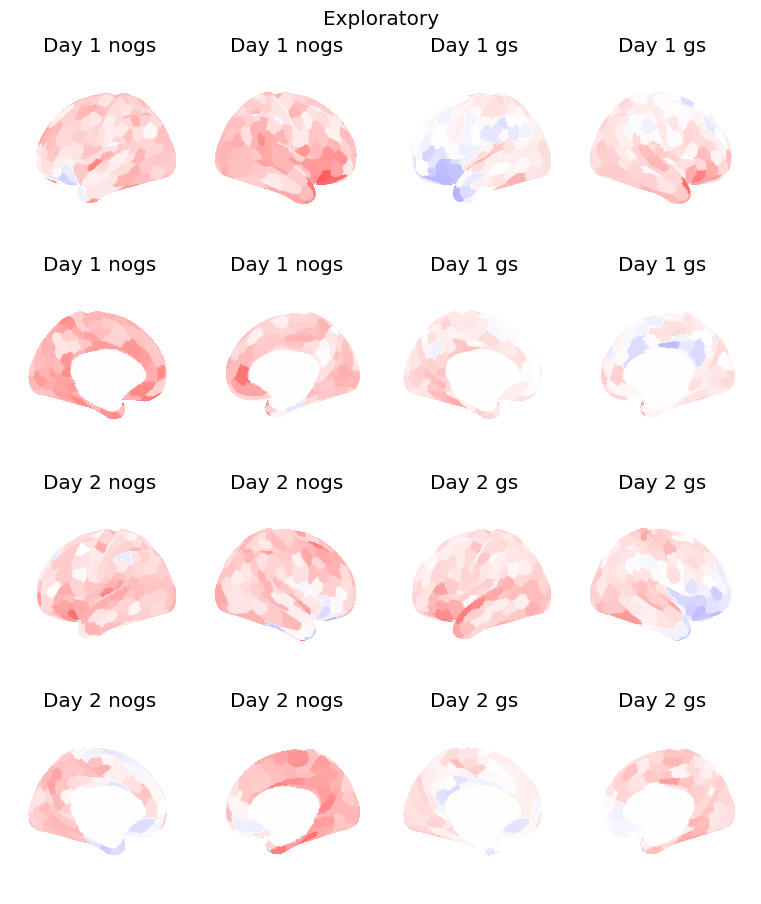

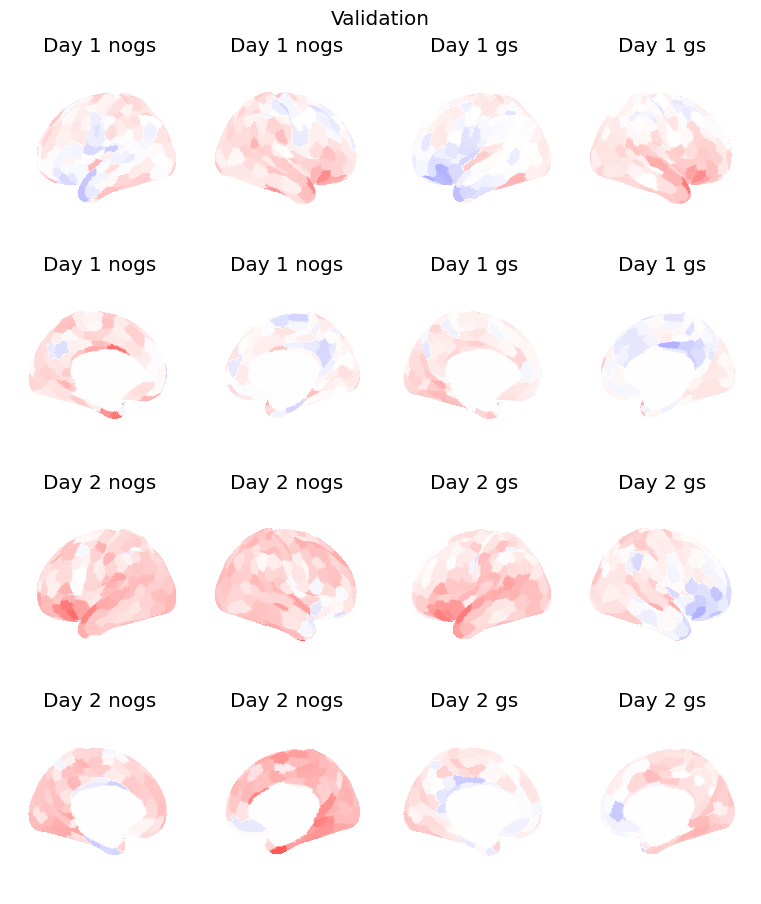

In [427]:
parcel_file = PARCEL_FILE_DICT.get(parcellation)
cifti_parcel_array = nib.load(parcel_file).get_fdata().copy()


for f, fold in enumerate(output_df_all['fold'].unique()):
    fig, axes_bmap = plt.subplots(
        4, 4, 
        sharey=True,
        layout='constrained', 
        figsize=(7.5, 9),
        subplot_kw={'projection':'3d'}
    )
#     for i, effect in enumerate(output_df_all['effect'].unique()):
    for day_n, day in enumerate(output_df_all['Day'].unique()):
        mat_df = get_empty_df_for_hmap(parcellation)
        nodes_df = get_nodes_df(parcellation)

        for gsr_type in ['nogs', 'gs']:
            gsr_name = 'With GSR' if gsr_type == 'gs' else 'Without GSR'
            edges_df = get_edge_summary(parcellation, network_hem_order=True)
            edges_df.sort_values("edge", inplace=True)
            edges_df["diff"] = output_df_all.query(
                '(gsr_type == @gsr_name) & (effect == "Random error") & (Day == @day) & (fold == @fold)'
            )['run2_run1'].to_numpy()
            # Shape of wide_edges_df is number of parcellation
            wide_edges_df = get_wide_df_hmap(edges_df, value_col_name="diff")
            mat_df = fill_mat_df(mat_df, wide_edges_df, gsr_type)

            summary_index_list = []
            for node in nodes_df['node']:
#                 set_trace()
                edges_df_subset = edges_df.query('(node1 == @node | node2 == @node)')['diff']
                summary_index = edges_df_subset.mean()
                summary_index_list.append(summary_index)
#                 set_trace()
            nodes_df[gsr_type] = summary_index_list
        
        nodes_df.rename(columns={'index': 'new_index'}, inplace=True)
        nodes_dict = nodes_df.set_index('old_index').to_dict(orient='index')
        
        input_data_dict = {}
        for gsr_type in ['nogs', 'gs']:
            # create statistics array
            stat_array = np.empty(shape=cifti_parcel_array.shape[1])
            stat_array[:] = np.nan
            # insert values to chi-square array
            for j in nodes_dict.keys():
                # get chi-square value in old index
                stats = nodes_dict.get(j).get(gsr_type)
                stat_array[np.squeeze(cifti_parcel_array == j+1)] = stats
            # subcortex is filled with white in heatmap
            stat_array = np.nan_to_num(stat_array)
            half_n_vertices = int(len(hcp.mesh.inflated[0])/2)
            input_data = stat_array
            input_data_dict[gsr_type] = input_data
        
        for k, gsr_type in enumerate(['nogs', 'gs']):
            input_data = input_data_dict.get(gsr_type)
            for i, direction in enumerate(['left', 'right']):
                if direction == 'left':
                    func = hcp.left_cortex_data
                    mesh = hcp.mesh.inflated_left
                elif direction == 'right':
                    func = hcp.right_cortex_data
                    mesh = hcp.mesh.inflated_right
                for j, view in enumerate(['lateral', "medial"]):
                    print(f'Ploting {direction} {view} in {gsr_type} condition.')
#                     if fig_direction == 'horizontal':
                    target_ax = axes_bmap[j+day_n*2, i+2*k]
#                     elif fig_direction == 'vertical':
#                         target_ax = axes_bmap[j+2*k, i]
                    surf = plot_surf_stat_map(
                            mesh,
                            func(input_data), 
                            hemi=direction, 
                            view=view,
                            colorbar=False,
                            cmap='bwr',
                            vmin=-0.3,
                            vmax=0.3,
                            axes=target_ax
                            )
                    target_ax.set_title(f'{day} {gsr_type}')
    fig.suptitle(fold)
    fig.savefig(
        f'/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/figures/{fold}_brain_03.png'
    )
        
#         draw_hmaps_fcs(
#             mat_df, 
#             nodes_df, 
#             cmap='bwr', 
#         #    save_filename=save_filename, 
#             cbar_ax=False, 
#             ax=axes[i, j], 
#             parcellation=parcellation,
#             add_custom_cbar=False,
#             vmax=0.4, 
#             vmin=-0.4,
#             cbar=True
#         )
#         axes[i, j].set_title(f'{effect} \nin {day}')       
# fig.suptitle(fold)

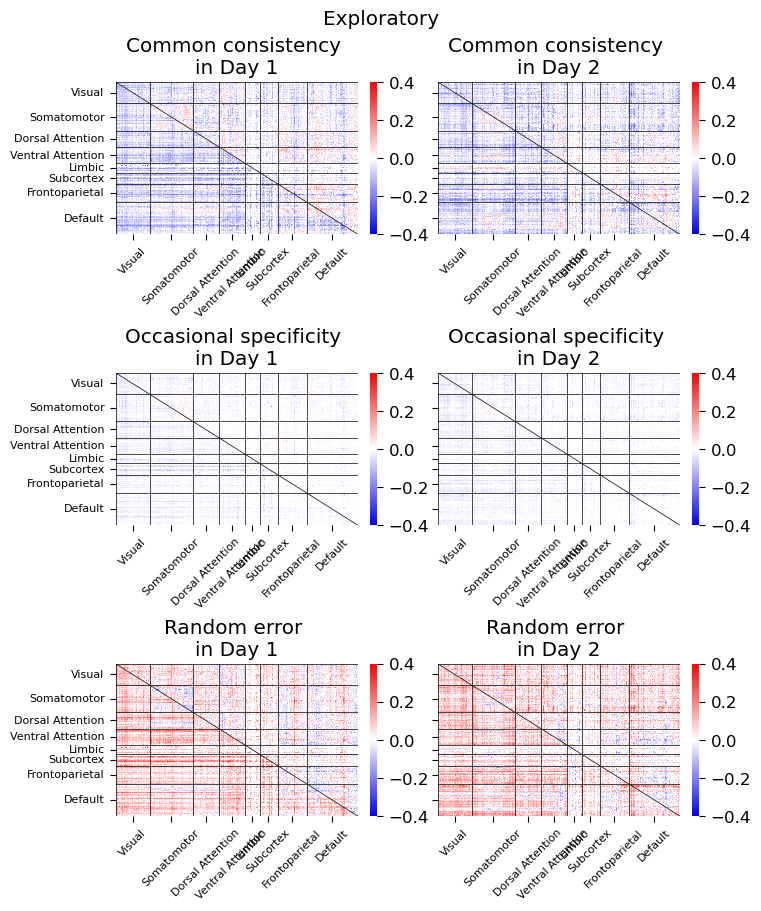

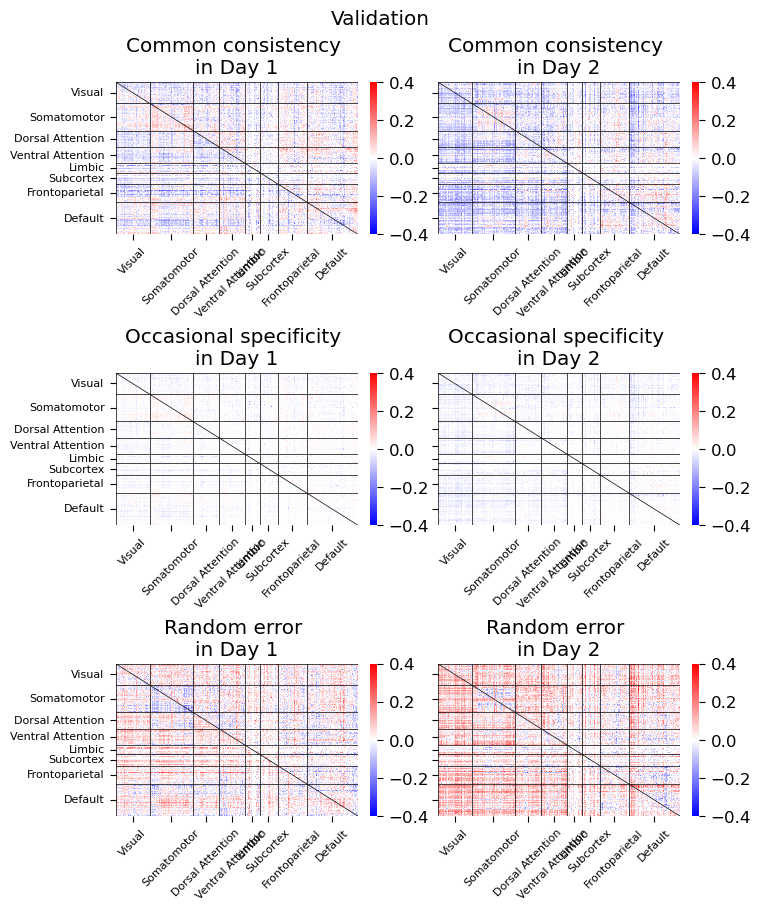

In [416]:
for fold in output_df_all['fold'].unique():
    fig, axes = plt.subplots(3, 2, sharey=True, layout='constrained', figsize=(7.5, 9))
    for i, effect in enumerate(output_df_all['effect'].unique()):
        for j, day in enumerate(output_df_all['Day'].unique()):
            mat_df = get_empty_df_for_hmap(parcellation)
            nodes_df = get_nodes_df(parcellation)

            for gsr_type in ['nogs', 'gs']:
                gsr_name = 'With GSR' if gsr_type == 'gs' else 'Without GSR'
                edges_df = get_edge_summary(parcellation, network_hem_order=True)
                edges_df.sort_values("edge", inplace=True)
                edges_df["diff"] = output_df_all.query(
                    '(gsr_type == @gsr_name) & (effect == @effect) & (Day == @day) & (fold == @fold)'
                )['run2_run1'].to_numpy()
                # Shape of wide_edges_df is number of parcellation
                wide_edges_df = get_wide_df_hmap(edges_df, value_col_name="diff")
                mat_df = fill_mat_df(mat_df, wide_edges_df, gsr_type)
                
                summary_index_list = []
                for node in nodes_df['node']:
                    set_trace()
                    edges_df_subset = edges_df.query('node1 == @node | node2 == @node')[f'index_mean_{gsr_type}']
                    summary_index = edges_df_subset.mean()
                    summary_index_list.append(summary_index)
                    nodes_df[f'{rel_type}_{gsr_type}'] = summary_index_list

                

            draw_hmaps_fcs(
                mat_df, 
                nodes_df, 
                cmap='bwr', 
            #    save_filename=save_filename, 
                cbar_ax=False, 
                ax=axes[i, j], 
                parcellation=parcellation,
                add_custom_cbar=False,
                vmax=0.4, 
                vmin=-0.4,
                cbar=True
            )
            axes[i, j].set_title(f'{effect} \nin {day}')       
    fig.suptitle(fold)

In [396]:
output_df_all = pd.DataFrame()
for fold in [0, 1]:
#     invalid_edges_dir = Path(f'/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/invalid_edges/Fold_{fold}')
#     nogs_invalid_edges = np.loadtxt(invalid_edges_dir / 'SelectCB_errorNone_nogs_invalid_edges_SRMR_0.08_RMSEA_0.08_CFI_0.9_loadings_from_0.4_to_0.9_2ndLoadings_from_0.7_to_1_controlling__.csv')
#     gs_invalid_edges = np.loadtxt(invalid_edges_dir / 'SelectCB_errorNone_gs_invalid_edges_SRMR_0.08_RMSEA_0.08_CFI_0.9_loadings_from_0.4_to_0.9_2ndLoadings_from_0.7_to_1_controlling__.csv')
    for effect_type in ['cons', 'spec', 'error']:
        df = calc_rel_lst_network(
            filename_param_list=[
                get_latest_file_from_condition(data_type='parameters', order_in_day=False, msst=True, select_cb=True, fold=fold, gsr_type='_nogs_').name,
                get_latest_file_from_condition(data_type='parameters', order_in_day=False, msst=True, select_cb=True, fold=fold, gsr_type='_gs_').name
            ],
            param_order_filename='model_onlyFC_controlling_None_CovCor_lavaan_MSST_session.csv',
            return_df=True,
            return_all_indicators=True,
            rel_type=effect_type            
        )
        long_df_gsr = visualize_boxplot(df, effect_type=effect_type, gsr_type='_gs_', fold=fold)
        long_df_no_gsr = visualize_boxplot(df, effect_type=effect_type, gsr_type='_nogs_', fold=fold)
#         set_trace()
        output_df_all = pd.concat([output_df_all, long_df_gsr, long_df_no_gsr], axis=0)

/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/parameters/combined/split_half_cv/params_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_0_nogs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-06-01 06:46:29_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/parameters/combined/split_half_cv/params_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_0_gs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-06-01 06:48:35_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/parameters/combined/split_half_cv/params_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_0_nogs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-06-01 06:46:29_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/parameters/co

In [96]:
output_df = pd.DataFrame()
for fold in [0, 1]:
    invalid_edges_dir = Path(f'/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/invalid_edges/Fold_{fold}')
    nogs_invalid_edges = np.loadtxt(invalid_edges_dir / 'SelectCB_errorNone_nogs_invalid_edges_SRMR_0.08_RMSEA_0.08_CFI_0.9_loadings_from_0.4_to_0.9_2ndLoadings_from_0.7_to_1_controlling__.csv')
    gs_invalid_edges = np.loadtxt(invalid_edges_dir / 'SelectCB_errorNone_gs_invalid_edges_SRMR_0.08_RMSEA_0.08_CFI_0.9_loadings_from_0.4_to_0.9_2ndLoadings_from_0.7_to_1_controlling__.csv')
    for effect_type in ['cons', 'spec', 'error']:
        df = calc_rel_lst_network(
            filename_param_list=[
                get_latest_file_from_condition(data_type='parameters', order_in_day=False, msst=True, select_cb=True, fold=fold, gsr_type='_nogs_').name,
                get_latest_file_from_condition(data_type='parameters', order_in_day=False, msst=True, select_cb=True, fold=fold, gsr_type='_gs_').name
            ],
            param_order_filename='model_onlyFC_controlling_None_CovCor_lavaan_MSST_session.csv',
            return_df=True,
            return_all_indicators=True,
            rel_type=effect_type            
        )
        long_df_gsr = visualize_boxplot(df, effect_type=effect_type, gsr_type='_gs_', fold=fold).query(
            '~(edge in @gs_invalid_edges)'
        )
        long_df_no_gsr = visualize_boxplot(df, effect_type=effect_type, gsr_type='_nogs_', fold=fold).query(
            '~(edge in @nogs_invalid_edges)'
        )
#         set_trace()
        output_df = pd.concat([output_df, long_df_gsr, long_df_no_gsr], axis=0)

/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/parameters/combined/split_half_cv/params_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_0_nogs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-06-01 06:46:29_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/parameters/combined/split_half_cv/params_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_0_gs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-06-01 06:48:35_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/parameters/combined/split_half_cv/params_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_0_nogs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-06-01 06:46:29_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/parameters/co

In [38]:
wide_output_df = output_df.pivot(
    index=['edge', 'session', 'gsr_type', 'fold', 'Day', 'Run'],
    values='value',
    columns='effect'
).reset_index()

In [43]:
(wide_output_df['Common consistency'] < 0.001).sum()

16986

In [59]:
output_df

edge        variable     value         session              effect  \
0           0    session_1_gs  0.557983  Run 1 in day 1  Common consistency   
1           1    session_1_gs  0.628646  Run 1 in day 1  Common consistency   
2           2    session_1_gs  0.602404  Run 1 in day 1  Common consistency   
5           5    session_1_gs  0.253924  Run 1 in day 1  Common consistency   
6           6    session_1_gs  0.566855  Run 1 in day 1  Common consistency   
...       ...             ...       ...             ...                 ...   
372376  93088  session_4_nogs  0.347222  Run 2 in day 2        Random error   
372377  93089  session_4_nogs  0.445698  Run 2 in day 2        Random error   
372378  93090  session_4_nogs  0.387807  Run 2 in day 2        Random error   
372382  93094  session_4_nogs  0.415885  Run 2 in day 2        Random error   
372383  93095  session_4_nogs  0.490280  Run 2 in day 2        Random error   

       model     gsr_type         fold    Day    Run                day_effect  
0       None     With GSR  Exploratory  Day 1  Run 1  Day 1_Common consistency  
1       None     With GSR  Exploratory  Day 1  Run 1  Day 1_Common consistency  
2       None     With GSR  Exploratory  Day 1  Run 1  Day 1_Common consistency  
5       None     With GSR  Exploratory  Day 1  Run 1  Day 1_Common consistency  
6       None     With GSR  Exploratory  Day 1  Run 1  Day 1_Common consistency  
...      ...          ...          ...    ...    ...                       ...  
372376  None  Without GSR   Validation  Day 2  Run 2        Day 2_Random error  
372377  None  Without GSR   Validation  Day 2  Run 2        Day 2_Random error  
372378  None  Without GSR   Validation  Day 2  Run 2        Day 2_Random error  
372382  None  Without GSR   Validation  Day 2  Run 2        Day 2_Random error  
372383  None  Without GSR   Validation  Day 2  Run 2        Day 2_Random error  

[2947980 rows x 11 columns]

In [67]:
output_df['model'] = 'Without method factor'
output_df_order_in_day['model'] = 'With method factor'

In [68]:
output_df_concat = pd.concat(
    [output_df, output_df_order_in_day], axis=0
)
output_df_concat['model'] = pd.Categorical(
    output_df_concat['model'], categories=['Without method factor', 'With method factor']
)

In [97]:
output_df = modify_output_df(output_df)

In [128]:
output_df_not_CB = modify_output_df(output_df_not_CB)

In [98]:
output_df

edge        variable     value         session              effect  \
0           0    session_1_gs  0.557983  Run 1 in day 1  Common consistency   
1           1    session_1_gs  0.628646  Run 1 in day 1  Common consistency   
2           2    session_1_gs  0.602404  Run 1 in day 1  Common consistency   
5           5    session_1_gs  0.253924  Run 1 in day 1  Common consistency   
6           6    session_1_gs  0.566855  Run 1 in day 1  Common consistency   
...       ...             ...       ...             ...                 ...   
372376  93088  session_4_nogs  0.347222  Run 2 in day 2        Random error   
372377  93089  session_4_nogs  0.445698  Run 2 in day 2        Random error   
372378  93090  session_4_nogs  0.387807  Run 2 in day 2        Random error   
372382  93094  session_4_nogs  0.415885  Run 2 in day 2        Random error   
372383  93095  session_4_nogs  0.490280  Run 2 in day 2        Random error   

       model     gsr_type         fold    Day    Run                day_effect  
0       None     With GSR  Exploratory  Day 1  Run 1  Day 1_Common consistency  
1       None     With GSR  Exploratory  Day 1  Run 1  Day 1_Common consistency  
2       None     With GSR  Exploratory  Day 1  Run 1  Day 1_Common consistency  
5       None     With GSR  Exploratory  Day 1  Run 1  Day 1_Common consistency  
6       None     With GSR  Exploratory  Day 1  Run 1  Day 1_Common consistency  
...      ...          ...          ...    ...    ...                       ...  
372376  None  Without GSR   Validation  Day 2  Run 2        Day 2_Random error  
372377  None  Without GSR   Validation  Day 2  Run 2        Day 2_Random error  
372378  None  Without GSR   Validation  Day 2  Run 2        Day 2_Random error  
372382  None  Without GSR   Validation  Day 2  Run 2        Day 2_Random error  
372383  None  Without GSR   Validation  Day 2  Run 2        Day 2_Random error  

[2947980 rows x 11 columns]

In [64]:
output_df_order_in_day = modify_output_df(output_df_order_in_day)

Saving
Saving completed


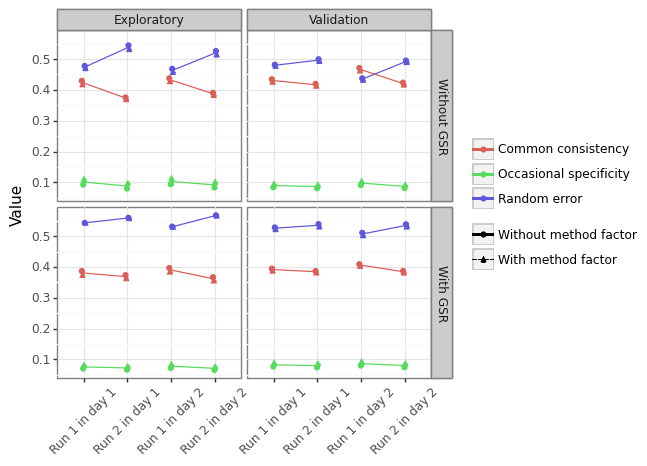

<Figure Size: (640 x 480)>

In [70]:
g = (
    ggplot(output_df_concat, aes('session', 'value', color='effect', shape='model', linetype='model'))
    + facet_grid('gsr_type ~ fold')
    + stat_summary(fun_y=np.mean, geom='point', position=position_dodge(width=0.1))
    + stat_summary(fun_data='mean_cl_boot', geom='errorbar', position=position_dodge(width=0.1))
    + stat_summary(aes(group='day_effect', color='effect'), fun_y=np.mean, geom='line', position=position_dodge(width=0.1))
#     + geom_boxplot(outlier_color='')
#     + geom_point(
#         size=0.01, 
#         alpha=0.1, 
#         position=position_jitterdodge(dodge_width=0.75, jitter_width=0.1, jitter_height=0)
#     )
    + theme_bw()
    + theme(
        axis_title_x=element_blank(),
        axis_text_x=element_text(angle=45),
        legend_title=element_blank()
    )
    + labs(y='Value')
)
print('Saving')
g.save('/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/figures/effects_mean_cis_concat_dodged.png')
print('Saving completed')
g

In [74]:
output_df

edge        variable     value         session              effect  \
0           0    session_1_gs  0.557983  Run 1 in day 1  Common consistency   
1           1    session_1_gs  0.628646  Run 1 in day 1  Common consistency   
2           2    session_1_gs  0.602404  Run 1 in day 1  Common consistency   
5           5    session_1_gs  0.253924  Run 1 in day 1  Common consistency   
6           6    session_1_gs  0.566855  Run 1 in day 1  Common consistency   
...       ...             ...       ...             ...                 ...   
372376  93088  session_4_nogs  0.347222  Run 2 in day 2        Random error   
372377  93089  session_4_nogs  0.445698  Run 2 in day 2        Random error   
372378  93090  session_4_nogs  0.387807  Run 2 in day 2        Random error   
372382  93094  session_4_nogs  0.415885  Run 2 in day 2        Random error   
372383  93095  session_4_nogs  0.490280  Run 2 in day 2        Random error   

                        model     gsr_type         fold    Day    Run  \
0       Without method factor     With GSR  Exploratory  Day 1  Run 1   
1       Without method factor     With GSR  Exploratory  Day 1  Run 1   
2       Without method factor     With GSR  Exploratory  Day 1  Run 1   
5       Without method factor     With GSR  Exploratory  Day 1  Run 1   
6       Without method factor     With GSR  Exploratory  Day 1  Run 1   
...                       ...          ...          ...    ...    ...   
372376  Without method factor  Without GSR   Validation  Day 2  Run 2   
372377  Without method factor  Without GSR   Validation  Day 2  Run 2   
372378  Without method factor  Without GSR   Validation  Day 2  Run 2   
372382  Without method factor  Without GSR   Validation  Day 2  Run 2   
372383  Without method factor  Without GSR   Validation  Day 2  Run 2   

                      day_effect  
0       Day 1_Common consistency  
1       Day 1_Common consistency  
2       Day 1_Common consistency  
5       Day 1_Common consistency  
6       Day 1_Common consistency  
...                          ...  
372376        Day 2_Random error  
372377        Day 2_Random error  
372378        Day 2_Random error  
372382        Day 2_Random error  
372383        Day 2_Random error  

[2947980 rows x 11 columns]

In [131]:
output_df_not_CB.pivot(
    index=['edge', 'effect', 'model', 'gsr_type', 'fold'],
    values='value',
    columns='session'
).reset_index().groupby(
    ['effect', 'gsr_type', 'fold']
)[['Run 1 in day 1', 'Run 2 in day 1', 'Run 1 in day 2', 'Run 2 in day 2']].corr().reset_index(
)[['Run 1 in day 1', 'Run 2 in day 1', 'Run 1 in day 2', 'Run 2 in day 2']].min()

session
Run 1 in day 1    0.773110
Run 2 in day 1    0.792803
Run 1 in day 2    0.773110
Run 2 in day 2    0.788587
dtype: float64

In [80]:
output_df.pivot(
    index=['edge', 'effect', 'model', 'gsr_type', 'fold'],
    values='value',
    columns='session'
).reset_index().groupby(
    ['effect', 'gsr_type', 'fold']
)[['Run 1 in day 1', 'Run 2 in day 1', 'Run 1 in day 2', 'Run 2 in day 2']].corr().reset_index(
)[['Run 1 in day 1', 'Run 2 in day 1', 'Run 1 in day 2', 'Run 2 in day 2']].min()

session
Run 1 in day 1    0.775966
Run 2 in day 1    0.791949
Run 1 in day 2    0.765375
Run 2 in day 2    0.765375
dtype: float64

Saving
Saving completed


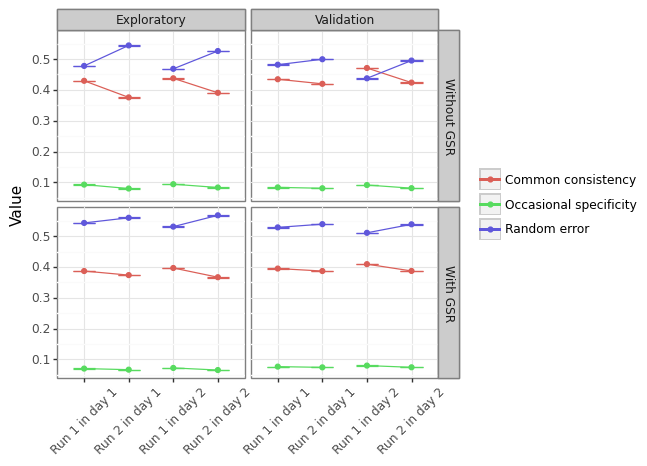

<Figure Size: (640 x 480)>

In [99]:
g = (
    ggplot(output_df, aes('session', 'value', color='effect'))
    + facet_grid('gsr_type ~ fold')
    + stat_summary(fun_y=np.mean, geom='point')
    + stat_summary(fun_data='mean_cl_boot', geom='errorbar')
    + stat_summary(aes(group='day_effect', color='effect'), fun_y=np.mean, geom='line')
#     + geom_boxplot(outlier_color='')
#     + geom_point(
#         size=0.01, 
#         alpha=0.1, 
#         position=position_jitterdodge(dodge_width=0.75, jitter_width=0.1, jitter_height=0)
#     )
    + theme_bw()
    + theme(
        axis_title_x=element_blank(),
        axis_text_x=element_text(angle=45),
        legend_title=element_blank()
    )
    + labs(y='Value')
)
print('Saving')
g.save('/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/figures/effects_mean_cis_cb.png')
print('Saving completed')
g

Saving
Saving completed


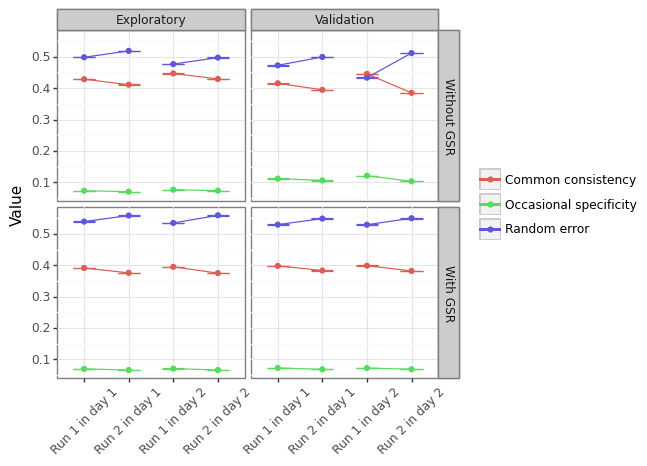

<Figure Size: (640 x 480)>

In [130]:
g = (
    ggplot(output_df_not_CB, aes('session', 'value', color='effect'))
    + facet_grid('gsr_type ~ fold')
    + stat_summary(fun_y=np.mean, geom='point')
    + stat_summary(fun_data='mean_cl_boot', geom='errorbar')
    + stat_summary(aes(group='day_effect', color='effect'), fun_y=np.mean, geom='line')
#     + geom_boxplot(outlier_color='')
#     + geom_point(
#         size=0.01, 
#         alpha=0.1, 
#         position=position_jitterdodge(dodge_width=0.75, jitter_width=0.1, jitter_height=0)
#     )
    + theme_bw()
    + theme(
        axis_title_x=element_blank(),
        axis_text_x=element_text(angle=45),
        legend_title=element_blank()
    )
    + labs(y='Value')
)
print('Saving')
g.save('/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/figures/effects_mean_cis_not_cb.png')
print('Saving completed')
g

Saving
Saving completed


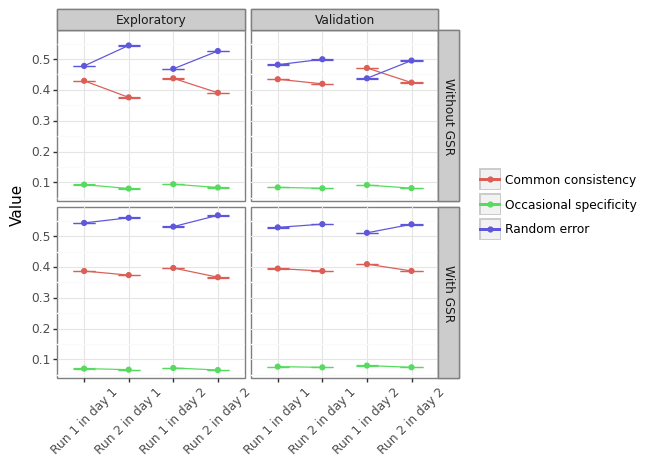

<Figure Size: (640 x 480)>

In [61]:
g = (
    ggplot(output_df, aes('session', 'value', color='effect'))
    + facet_grid('gsr_type ~ fold')
    + stat_summary(fun_y=np.mean, geom='point')
    + stat_summary(fun_data='mean_cl_boot', geom='errorbar')
    + stat_summary(aes(group='day_effect', color='effect'), fun_y=np.mean, geom='line')
#     + geom_boxplot(outlier_color='')
#     + geom_point(
#         size=0.01, 
#         alpha=0.1, 
#         position=position_jitterdodge(dodge_width=0.75, jitter_width=0.1, jitter_height=0)
#     )
    + theme_bw()
    + theme(
        axis_title_x=element_blank(),
        axis_text_x=element_text(angle=45),
        legend_title=element_blank()
    )
    + labs(y='Value')
)
print('Saving')
g.save('/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/figures/effects_mean_cis.png')
print('Saving completed')
g

Saving figures
Saving completed


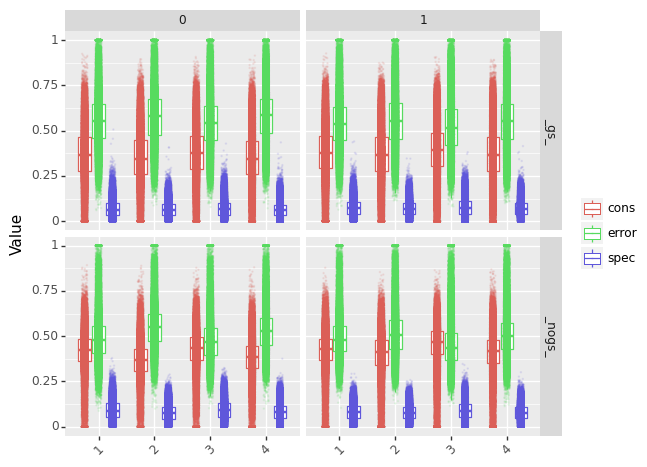

<Figure Size: (640 x 480)>

In [28]:
g = (
    ggplot(output_df, aes('session', 'value', color='effect'))
    + facet_grid('gsr_type ~ fold')
    + geom_boxplot(outlier_color='')
    + geom_point(
        size=0.01, 
        alpha=0.1, 
        position=position_jitterdodge(dodge_width=0.75, jitter_width=0.1, jitter_height=0)
    )
    + theme(
        axis_title_x=element_blank(),
        axis_text_x=element_text(angle=45),
        legend_title=element_blank()
    )
    + labs(y='Value')
)
print('Saving figures')
g.save('/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/figures/effect_summary.png')
print('Saving completed')
g

In [12]:
output_df

edge        variable     value         session              effect  \
0           0    session_1_gs  0.557983  Run 1 in day 1  Common consistency   
1           1    session_1_gs  0.628646  Run 1 in day 1  Common consistency   
2           2    session_1_gs  0.602404  Run 1 in day 1  Common consistency   
3           3    session_1_gs  0.540527  Run 1 in day 1  Common consistency   
4           4    session_1_gs  0.535561  Run 1 in day 1  Common consistency   
...       ...             ...       ...             ...                 ...   
372379  93091  session_4_nogs       NaN  Run 2 in day 2        Random error   
372380  93092  session_4_nogs       NaN  Run 2 in day 2        Random error   
372381  93093  session_4_nogs  0.532455  Run 2 in day 2        Random error   
372382  93094  session_4_nogs  0.498104  Run 2 in day 2        Random error   
372383  93095  session_4_nogs  0.494880  Run 2 in day 2        Random error   

       model     gsr_type        fold  
0       None     With GSR  Exloratory  
1       None     With GSR  Exloratory  
2       None     With GSR  Exloratory  
3       None     With GSR  Exloratory  
4       None     With GSR  Exloratory  
...      ...          ...         ...  
372379  None  Without GSR  Validation  
372380  None  Without GSR  Validation  
372381  None  Without GSR  Validation  
372382  None  Without GSR  Validation  
372383  None  Without GSR  Validation  

[4468608 rows x 8 columns]

In [57]:
effect_map = {'cons': 'Common consistency', 'spec': 'Occasional specificity', 'error': 'Random error'}
session_map = {'1': 'Run 1 in day 1', '2': 'Run 2 in day 1', '3': 'Run 1 in day 2', '4': 'Run 2 in day 2'}
gsr_map = {'_nogs_': 'Without GSR', '_gs_': 'With GSR'}
fold_map = {0: 'Exploratory', 1: 'Validation'}
output_df['effect'] = output_df['effect'].map(effect_map)
output_df['session'] = output_df['session'].map(session_map)
output_df['gsr_type'] = output_df['gsr_type'].map(gsr_map)
output_df['fold'] = output_df['fold'].map(fold_map)

In [58]:
output_df['gsr_type'] = pd.Categorical(
    output_df['gsr_type'],
    categories=['Without GSR', 'With GSR']
)
output_df['session'] = pd.Categorical(
    output_df['session'],
    categories=['Run 1 in day 1', 'Run 2 in day 1', 'Run 1 in day 2', 'Run 2 in day 2']
)

output_df['Day'] = np.where(
    output_df['session'].isin(['Run 1 in day 1', 'Run 2 in day 1']), 'Day 1', 'Day 2'
)
output_df['Run'] = np.where(
    output_df['session'].isin(['Run 1 in day 1', 'Run 1 in day 2']), 'Run 1', 'Run 2'
)
output_df['day_effect'] = output_df['Day'].astype(str) + '_' + output_df['effect'].astype(str)

In [24]:
output_df

edge        variable     value         session              effect  \
0           0    session_1_gs  0.557983  Run 1 in day 1  Common consistency   
1           1    session_1_gs  0.628646  Run 1 in day 1  Common consistency   
2           2    session_1_gs  0.602404  Run 1 in day 1  Common consistency   
3           3    session_1_gs  0.540527  Run 1 in day 1  Common consistency   
4           4    session_1_gs  0.535561  Run 1 in day 1  Common consistency   
...       ...             ...       ...             ...                 ...   
372379  93091  session_4_nogs       NaN  Run 2 in day 2        Random error   
372380  93092  session_4_nogs       NaN  Run 2 in day 2        Random error   
372381  93093  session_4_nogs  0.532455  Run 2 in day 2        Random error   
372382  93094  session_4_nogs  0.498104  Run 2 in day 2        Random error   
372383  93095  session_4_nogs  0.494880  Run 2 in day 2        Random error   

       model     gsr_type         fold    Day    Run  
0       None     With GSR  Exploratory  Day 1  Run 1  
1       None     With GSR  Exploratory  Day 1  Run 1  
2       None     With GSR  Exploratory  Day 1  Run 1  
3       None     With GSR  Exploratory  Day 1  Run 1  
4       None     With GSR  Exploratory  Day 1  Run 1  
...      ...          ...          ...    ...    ...  
372379  None  Without GSR   Validation  Day 2  Run 2  
372380  None  Without GSR   Validation  Day 2  Run 2  
372381  None  Without GSR   Validation  Day 2  Run 2  
372382  None  Without GSR   Validation  Day 2  Run 2  
372383  None  Without GSR   Validation  Day 2  Run 2  

[4468608 rows x 10 columns]

In [701]:
visualize_boxplot(
    edges_df_trait_all_ind_order_in_day_fold1, 
    effect_type='consistency',
    gsr_type='_gs_',
    fold=1,
    model_type='Method'
)

edge      variable     value session       effect   model gsr_type  \
0           0  session_1_gs  0.522261       1  consistency  Method     _gs_   
1           1  session_1_gs  0.564160       1  consistency  Method     _gs_   
2           2  session_1_gs  0.452270       1  consistency  Method     _gs_   
3           3  session_1_gs  0.409153       1  consistency  Method     _gs_   
4           4  session_1_gs  0.472050       1  consistency  Method     _gs_   
...       ...           ...       ...     ...          ...     ...      ...   
372379  93091  session_4_gs  0.646211       4  consistency  Method     _gs_   
372380  93092  session_4_gs  0.670827       4  consistency  Method     _gs_   
372381  93093  session_4_gs  0.551511       4  consistency  Method     _gs_   
372382  93094  session_4_gs  0.557689       4  consistency  Method     _gs_   
372383  93095  session_4_gs  0.639814       4  consistency  Method     _gs_   

        fold  
0          1  
1          1  
2          1  
3          1  
4          1  
...      ...  
372379     1  
372380     1  
372381     1  
372382     1  
372383     1  

[372384 rows x 8 columns]

In [661]:
edges_df_error_all_ind_order_in_day = add_diff_columns(edges_df_error_all_ind_order_in_day)

In [663]:
long_error_df_order_in_day = create_long_df(edges_df_error_all_ind_order_in_day)

In [630]:
edges_df_cons_all_ind['session_12_nogs_diff'] = edges_df_cons_all_ind['session_1_nogs'] - edges_df_cons_all_ind['session_2_nogs']
edges_df_cons_all_ind['session_34_nogs_diff'] = edges_df_cons_all_ind['session_3_nogs'] - edges_df_cons_all_ind['session_4_nogs']

In [650]:
edges_df_spec_all_ind['session_12_nogs_diff'] = edges_df_spec_all_ind['session_1_nogs'] - edges_df_spec_all_ind['session_2_nogs']
edges_df_spec_all_ind['session_34_nogs_diff'] = edges_df_spec_all_ind['session_3_nogs'] - edges_df_spec_all_ind['session_4_nogs']

In [656]:
edges_df_error_all_ind['session_12_nogs_diff'] = edges_df_error_all_ind['session_1_nogs'] - edges_df_error_all_ind['session_2_nogs']
edges_df_error_all_ind['session_34_nogs_diff'] = edges_df_error_all_ind['session_3_nogs'] - edges_df_error_all_ind['session_4_nogs']

In [632]:
edges_df_cons_all_ind

edge                           node1 node1_hem node1_net  \
0          0              7Networks_LH_Vis_1        LH    Visual   
1          1              7Networks_LH_Vis_1        LH    Visual   
2          2              7Networks_LH_Vis_1        LH    Visual   
3          3              7Networks_LH_Vis_1        LH    Visual   
4          4              7Networks_LH_Vis_1        LH    Visual   
...      ...                             ...       ...       ...   
93091  93091  7Networks_RH_Default_pCunPCC_6        RH   Default   
93092  93092  7Networks_RH_Default_pCunPCC_6        RH   Default   
93093  93093  7Networks_RH_Default_pCunPCC_7        RH   Default   
93094  93094  7Networks_RH_Default_pCunPCC_7        RH   Default   
93095  93095  7Networks_RH_Default_pCunPCC_8        RH   Default   

      node1_net_sub                           node2 node2_hem node2_net  \
0              None              7Networks_LH_Vis_2        LH    Visual   
1              None              7Networks_LH_Vis_3        LH    Visual   
2              None              7Networks_LH_Vis_4        LH    Visual   
3              None              7Networks_LH_Vis_5        LH    Visual   
4              None              7Networks_LH_Vis_6        LH    Visual   
...             ...                             ...       ...       ...   
93091       pCunPCC  7Networks_RH_Default_pCunPCC_8        RH   Default   
93092       pCunPCC  7Networks_RH_Default_pCunPCC_9        RH   Default   
93093       pCunPCC  7Networks_RH_Default_pCunPCC_8        RH   Default   
93094       pCunPCC  7Networks_RH_Default_pCunPCC_9        RH   Default   
93095       pCunPCC  7Networks_RH_Default_pCunPCC_9        RH   Default   

      node2_net_sub  session_1_nogs  session_2_nogs  session_3_nogs  \
0              None        0.536802        0.340952        0.506251   
1              None        0.567023        0.460206        0.579450   
2              None        0.537943        0.394831        0.519055   
3              None        0.497003        0.398529        0.520836   
4              None        0.515753        0.423745        0.516579   
...             ...             ...             ...             ...   
93091       pCunPCC        0.637109        0.598912        0.645663   
93092       pCunPCC        0.570942        0.466305        0.525119   
93093       pCunPCC        0.488377        0.500500        0.593097   
93094       pCunPCC        0.470029        0.381708        0.503405   
93095       pCunPCC        0.583632        0.546633        0.606579   

       session_4_nogs  session_1_gs  session_2_gs  session_3_gs  session_4_gs  \
0            0.401939      0.557983      0.407569      0.538054      0.474298   
1            0.513323      0.628646      0.493707      0.610128      0.594060   
2            0.446977      0.602404      0.400130      0.464798      0.473966   
3            0.420642      0.540527      0.398383      0.446309      0.467839   
4            0.447816      0.535561      0.417876      0.511683      0.437446   
...               ...           ...           ...           ...           ...   
93091        0.527520      0.656538      0.715601      0.689489      0.635024   
93092        0.477916      0.632989      0.642670      0.607990      0.611995   
93093        0.478497      0.541097      0.661625      0.679478      0.555912   
93094        0.384350      0.465831      0.564317      0.623870      0.481824   
93095        0.489779      0.602746      0.630280      0.631814      0.588919   

       session_12_nogs_diff  session_34_nogs_diff  
0                  0.195850              0.104312  
1                  0.106817              0.066127  
2                  0.143112              0.072078  
3                  0.098474              0.100194  
4                  0.092008              0.068763  
...                     ...                   ...  
93091              0.038197              0.118143  
93092              0.104637              0.04720

In [657]:
long_error_df = edges_df_error_all_ind[['edge'] + nogs_sessions].melt(
    id_vars=['edge'],
    value_vars=nogs_sessions
).assign(
    session=lambda x: x['variable'].str.split('_').str[1]
)

In [651]:
long_spec_df = edges_df_spec_all_ind[['edge'] + nogs_sessions].melt(
    id_vars=['edge'],
    value_vars=nogs_sessions
).assign(
    session=lambda x: x['variable'].str.split('_').str[1]
)

In [624]:
long_cons_df = edges_df_cons_all_ind[['edge'] + nogs_sessions].melt(
    id_vars=['edge'],
    value_vars=nogs_sessions
).assign(
    session=lambda x: x['variable'].str.split('_').str[1]
)

In [621]:
get_latest_file_from_condition(data_type='parameters', order_in_day=False, msst=True, select_cb=True)

/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/parameters/combined/split_half_cv/params_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_0_nogs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-06-01 06:46:29_combined.npy


PosixPath('/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/parameters/combined/split_half_cv/params_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_0_nogs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-06-01 06:46:29_combined.npy')

In [628]:
long_cons_df

edge        variable     value session
0           0  session_1_nogs  0.536802       1
1           1  session_1_nogs  0.567023       1
2           2  session_1_nogs  0.537943       1
3           3  session_1_nogs  0.497003       1
4           4  session_1_nogs  0.515753       1
...       ...             ...       ...     ...
372379  93091  session_4_nogs  0.527520       4
372380  93092  session_4_nogs  0.477916       4
372381  93093  session_4_nogs  0.478497       4
372382  93094  session_4_nogs  0.384350       4
372383  93095  session_4_nogs  0.489779       4

[372384 rows x 4 columns]

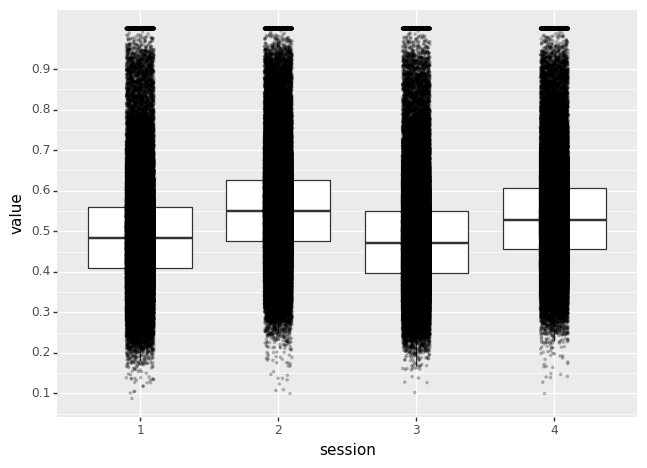

<Figure Size: (640 x 480)>

In [665]:
create_boxplots(long_error_df_order_in_day)

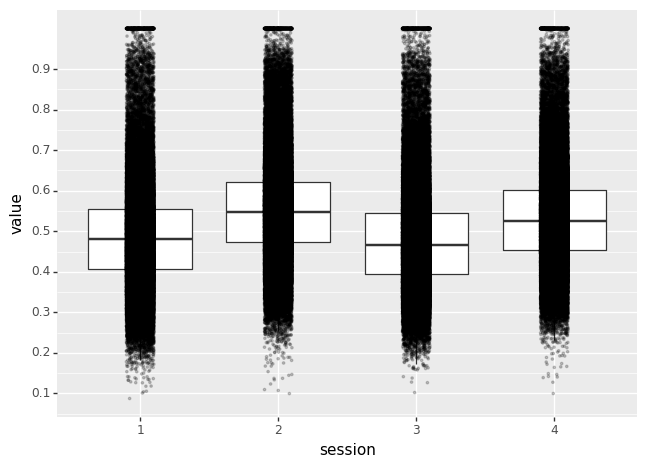

<Figure Size: (640 x 480)>

In [658]:
g = (
    ggplot(long_error_df, aes('session', 'value'))
    + geom_boxplot(outlier_color='')
    + geom_jitter(width=0.1, height=0, size=0.5, alpha=0.2)
    + scale_y_continuous(breaks=np.arange(0, 1, 0.1))
)
g

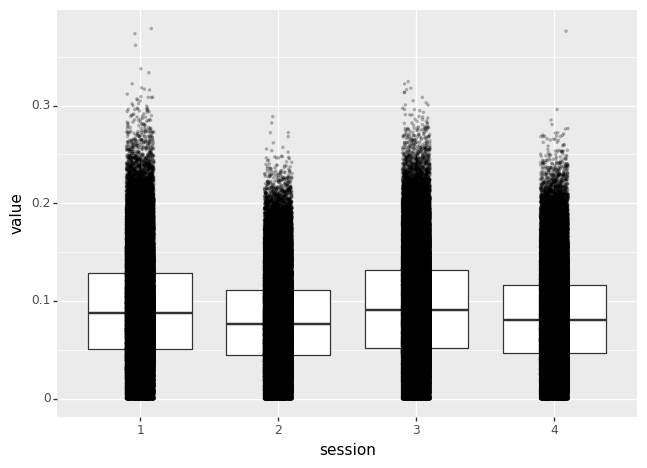

<Figure Size: (640 x 480)>

In [652]:
g = (
    ggplot(long_spec_df, aes('session', 'value'))
    + geom_boxplot(outlier_color='')
    + geom_jitter(width=0.1, height=0, size=0.5, alpha=0.2)
    + scale_y_continuous(breaks=np.arange(0, 1, 0.1))
)
g

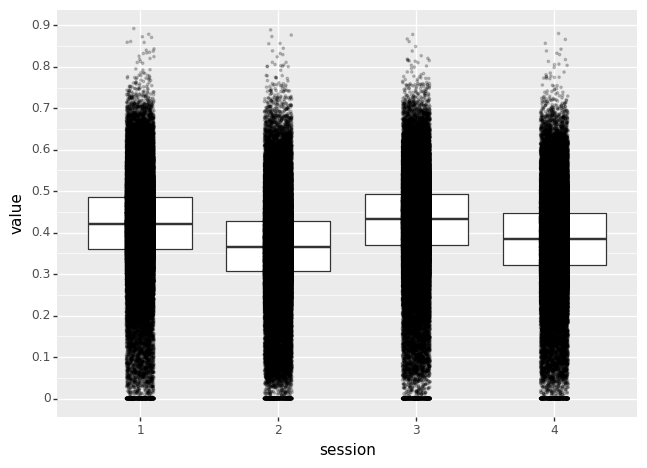

<Figure Size: (640 x 480)>

In [627]:
g = (
    ggplot(long_cons_df, aes('session', 'value'))
    + geom_boxplot(outlier_color='')
    + geom_jitter(width=0.1, height=0, size=0.5, alpha=0.2)
    + scale_y_continuous(breaks=np.arange(0, 1, 0.1))
)
g

(array([1.1410e+03, 3.1400e+03, 6.6810e+03, 1.0084e+04, 1.2146e+04,
        1.2257e+04, 1.0971e+04, 8.9750e+03, 6.7370e+03, 4.6740e+03,
        2.9840e+03, 1.9500e+03, 1.1320e+03, 5.7700e+02, 3.5300e+02,
        1.7300e+02, 8.1000e+01, 4.3000e+01, 2.6000e+01, 1.0000e+01,
        8.0000e+00, 4.0000e+00, 1.0000e+00]),
 array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
        0.045, 0.05 , 0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085,
        0.09 , 0.095, 0.1  , 0.105, 0.11 , 0.115]),
 <BarContainer object of 23 artists>)

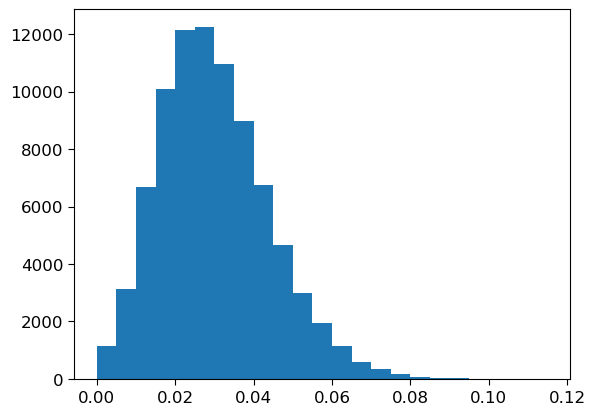

In [609]:
plt.hist(edges_df_cons_all_ind[nogs_sessions].apply(np.std, axis=1), bins=np.arange(0, 0.12, 0.005))

In [633]:
edges_df_cons_all_ind.columns

Index(['edge', 'node1', 'node1_hem', 'node1_net', 'node1_net_sub', 'node2',
       'node2_hem', 'node2_net', 'node2_net_sub', 'session_1_nogs',
       'session_2_nogs', 'session_3_nogs', 'session_4_nogs', 'session_1_gs',
       'session_2_gs', 'session_3_gs', 'session_4_gs', 'session_12_nogs_diff',
       'session_34_nogs_diff'],
      dtype='object')

In [637]:
edges_df_cons_all_ind['session_12_nogs_diff'].max()

0.43980769647049334

In [636]:
edges_df_cons_all_ind['session_12_nogs_diff'].min()

-0.20017708757174346

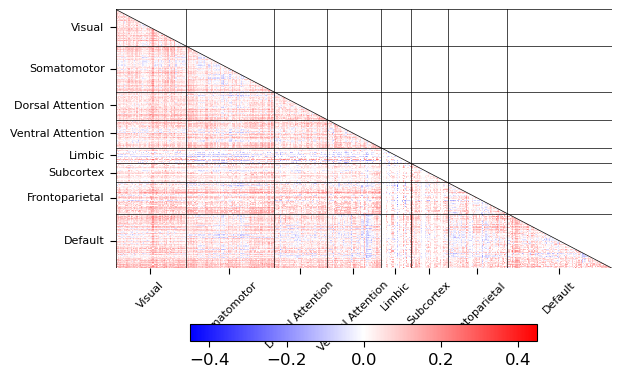

In [641]:
mat_df = get_empty_df_for_hmap('Schaefer')
edges_df = get_edge_summary(network_hem_order=True)
edges_df = generate_set_of_networks(edges_df)
edges_df.sort_values("edge", inplace=True)
edges_df['session_34_nogs_diff'] = edges_df_cons_all_ind['session_34_nogs_diff']
wide_df = get_wide_df_hmap(edges_df, value_col_name='session_34_nogs_diff')
mat_df = fill_mat_df(mat_df, wide_df, 'nogs')

draw_hmaps_fcs(
    mat_df,
    get_nodes_df('Schaefer'),
    'bwr',
    vmin=-0.45,
    vmax=0.45
)

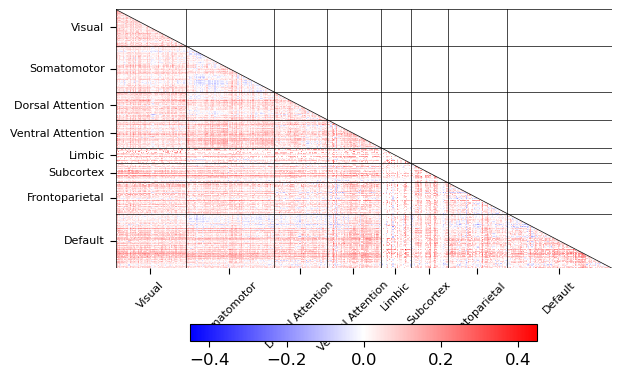

In [640]:
mat_df = get_empty_df_for_hmap('Schaefer')
edges_df = get_edge_summary(network_hem_order=True)
edges_df = generate_set_of_networks(edges_df)
edges_df.sort_values("edge", inplace=True)
edges_df['session_12_nogs_diff'] = edges_df_cons_all_ind['session_12_nogs_diff']
wide_df = get_wide_df_hmap(edges_df, value_col_name='session_12_nogs_diff')
mat_df = fill_mat_df(mat_df, wide_df, 'nogs')

draw_hmaps_fcs(
    mat_df,
    get_nodes_df('Schaefer'),
    'bwr',
    vmin=-0.45,
    vmax=0.45
)

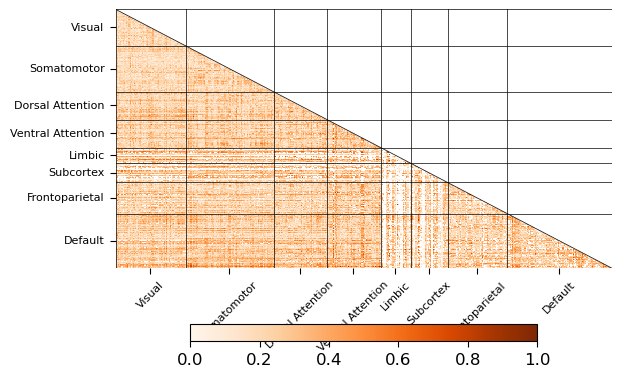

In [606]:
mat_df = get_empty_df_for_hmap('Schaefer')
edges_df = get_edge_summary(network_hem_order=True)
edges_df = generate_set_of_networks(edges_df)
edges_df.sort_values("edge", inplace=True)
edges_df['std_cons'] = edges_df_cons_all_ind[nogs_sessions].apply(np.std, axis=1)
wide_df = get_wide_df_hmap(edges_df, value_col_name='std_cons')
mat_df = fill_mat_df(mat_df, wide_df, 'nogs')

draw_hmaps_fcs(
    mat_df,
    get_nodes_df('Schaefer'),
    'Oranges'
)

In [165]:
edges_df_cons = calc_rel_lst_network(
    filename_param_list=[
        'params_Model_onlyFC_Trait_None_Scale_None_sampleN_203_Fold_0_nogs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_seed0_2024-12-12 13:17:41_combined.npy',
        'params_Model_onlyFC_Trait_None_Scale_None_sampleN_203_Fold_0_gs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_seed0_2024-12-12 13:33:38_combined.npy'
    ],
    param_order_filename='model_onlyFC_controlling_None_CovCor_lavaan_MSST_session.csv',
    return_df=True
)

In [591]:
edges_df_cons

edge                           node1 node1_hem node1_net  \
0          0              7Networks_LH_Vis_1        LH    Visual   
1          1              7Networks_LH_Vis_1        LH    Visual   
2          2              7Networks_LH_Vis_1        LH    Visual   
3          3              7Networks_LH_Vis_1        LH    Visual   
4          4              7Networks_LH_Vis_1        LH    Visual   
...      ...                             ...       ...       ...   
93091  93091  7Networks_RH_Default_pCunPCC_6        RH   Default   
93092  93092  7Networks_RH_Default_pCunPCC_6        RH   Default   
93093  93093  7Networks_RH_Default_pCunPCC_7        RH   Default   
93094  93094  7Networks_RH_Default_pCunPCC_7        RH   Default   
93095  93095  7Networks_RH_Default_pCunPCC_8        RH   Default   

      node1_net_sub                           node2 node2_hem node2_net  \
0              None              7Networks_LH_Vis_2        LH    Visual   
1              None              7Networks_LH_Vis_3        LH    Visual   
2              None              7Networks_LH_Vis_4        LH    Visual   
3              None              7Networks_LH_Vis_5        LH    Visual   
4              None              7Networks_LH_Vis_6        LH    Visual   
...             ...                             ...       ...       ...   
93091       pCunPCC  7Networks_RH_Default_pCunPCC_8        RH   Default   
93092       pCunPCC  7Networks_RH_Default_pCunPCC_9        RH   Default   
93093       pCunPCC  7Networks_RH_Default_pCunPCC_8        RH   Default   
93094       pCunPCC  7Networks_RH_Default_pCunPCC_9        RH   Default   
93095       pCunPCC  7Networks_RH_Default_pCunPCC_9        RH   Default   

      node2_net_sub  index_mean_nogs  index_mean_gs  
0              None         0.444422       0.507303  
1              None         0.551938       0.613716  
2              None         0.476106       0.465116  
3              None         0.499744       0.514713  
4              None         0.497139       0.520560  
...             ...              ...            ...  
93091       pCunPCC         0.595367       0.660086  
93092       pCunPCC         0.570194       0.631406  
93093       pCunPCC         0.541825       0.598343  
93094       pCunPCC         0.530897            NaN  
93095       pCunPCC         0.575135       0.675372  

[93096 rows x 11 columns]

In [166]:
edges_df['cons_nogs'] = edges_df_cons['index_mean_nogs']

In [194]:
ma.corrcoef(ma.masked_invalid(edges_df['icc2']), ma.masked_invalid(edges_df['cons_nogs']))

masked_array(
  data=[[1.0, 0.9329489177752399],
        [0.9329489177752399, 1.0]],
  mask=[[False, False],
        [False, False]],
  fill_value=1e+20)

Text(0, 0.5, 'Common consistency')

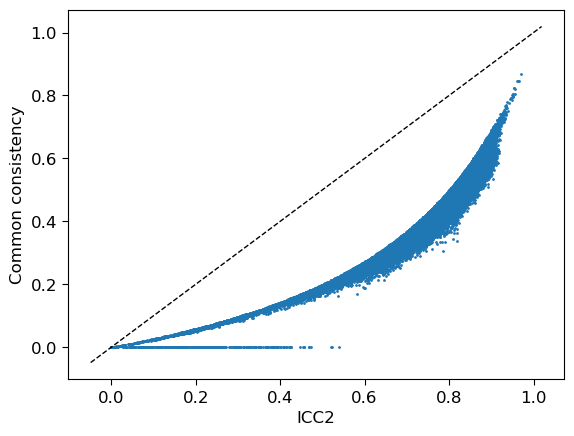

In [192]:
fig, ax = plt.subplots()
ax.scatter(edges_df['icc2'], edges_df['cons_nogs'], s=1)
abline(1, 0, ax)
ax.set_xlabel('ICC2')
ax.set_ylabel('Common consistency')

Text(0, 0.5, 'Common consistency')

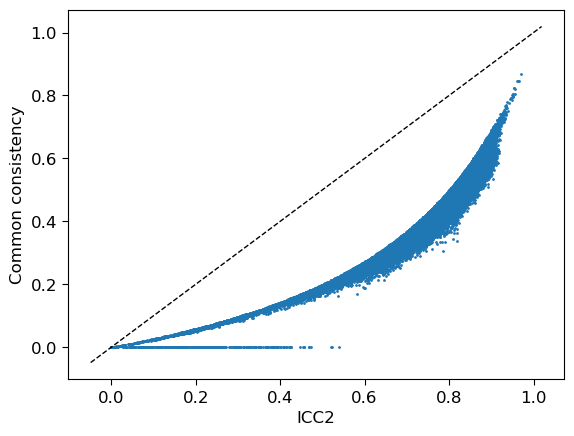

In [171]:
fig, ax = plt.subplots()
ax.scatter(edges_df['icc2'], edges_df['cons_nogs'], s=1)
abline(1, 0, ax)
ax.set_xlabel('ICC2')
ax.set_ylabel('Common consistency')

In [161]:
edges_df_cons

edge                           node1 node1_hem node1_net  \
0          0              7Networks_LH_Vis_1        LH    Visual   
1          1              7Networks_LH_Vis_1        LH    Visual   
2          2              7Networks_LH_Vis_1        LH    Visual   
3          3              7Networks_LH_Vis_1        LH    Visual   
4          4              7Networks_LH_Vis_1        LH    Visual   
...      ...                             ...       ...       ...   
93091  93091  7Networks_RH_Default_pCunPCC_6        RH   Default   
93092  93092  7Networks_RH_Default_pCunPCC_6        RH   Default   
93093  93093  7Networks_RH_Default_pCunPCC_7        RH   Default   
93094  93094  7Networks_RH_Default_pCunPCC_7        RH   Default   
93095  93095  7Networks_RH_Default_pCunPCC_8        RH   Default   

      node1_net_sub                           node2 node2_hem node2_net  \
0              None              7Networks_LH_Vis_2        LH    Visual   
1              None              7Networks_LH_Vis_3        LH    Visual   
2              None              7Networks_LH_Vis_4        LH    Visual   
3              None              7Networks_LH_Vis_5        LH    Visual   
4              None              7Networks_LH_Vis_6        LH    Visual   
...             ...                             ...       ...       ...   
93091       pCunPCC  7Networks_RH_Default_pCunPCC_8        RH   Default   
93092       pCunPCC  7Networks_RH_Default_pCunPCC_9        RH   Default   
93093       pCunPCC  7Networks_RH_Default_pCunPCC_8        RH   Default   
93094       pCunPCC  7Networks_RH_Default_pCunPCC_9        RH   Default   
93095       pCunPCC  7Networks_RH_Default_pCunPCC_9        RH   Default   

      node2_net_sub  index_mean_nogs  index_mean_gs  
0              None         0.054256   2.940443e-02  
1              None         0.087033   6.935601e-02  
2              None         0.077710   5.333728e-02  
3              None         0.079920   6.304628e-02  
4              None         0.080141   6.889946e-02  
...             ...              ...            ...  
93091       pCunPCC         0.030814   4.158375e-02  
93092       pCunPCC         0.045883   2.864310e-02  
93093       pCunPCC         0.015847   2.889867e-02  
93094       pCunPCC         0.007727   3.337495e-16  
93095       pCunPCC         0.003362   1.723699e-02  

[93096 rows x 11 columns]

In [133]:
eff_errors = 1 / np.sum(nogs_bf_params_fold0[:, cf_loadings_index, 0] ** 2 / nogs_bf_params_fold0[:, item_error_vars, 0])

In [134]:
eff_errors

2.9415212693345523e-06

In [119]:
nogs_bf_params_fold0[0, :, 0]

array([0.35643482, 0.34286982, 0.36221525, 0.37044904, 0.66348785,
       0.63823724, 0.67424786, 0.68957472, 0.43273807, 0.47509354,
       0.41418993, 0.38725424, 0.        , 0.        , 0.        ,
       1.        , 1.        , 1.        ])

In [117]:
nogs_bf_params_fold0.shape

(93096, 18, 5)

In [ ]:
rsfcs = [f'RSFC Q{i}' for i in range(1, 5)]

In [88]:
msst_params_df = pd.DataFrame(
    nogs_msst_params[:, :4, 0], columns=rsfcs
).assign(model='MSST').reset_index().rename(columns={'index': 'edge'})

bf_params_df = pd.DataFrame(
    nogs_bf_params[:, 4:8, 0], columns=rsfcs
).assign(model='Bifactor').reset_index().rename(columns={'index': 'edge'})

st_params_df = pd.DataFrame(
    single_trait_loadings[:, :4, 0], columns=rsfcs
).assign(model='ST').reset_index().rename(columns={'index': 'edge'})

In [348]:
long_concat_df = pd.concat(
    [msst_params_df, bf_params_df, st_params_df], 
    axis=0
).melt(
    id_vars=['edge', 'model'],
    value_vars=rsfcs,
    value_name='r',
    var_name='run'
)

In [351]:
wide_concat_df = long_concat_df.pivot(
    index=['edge', 'run'],
    columns='model',
    values='r'
).reset_index()

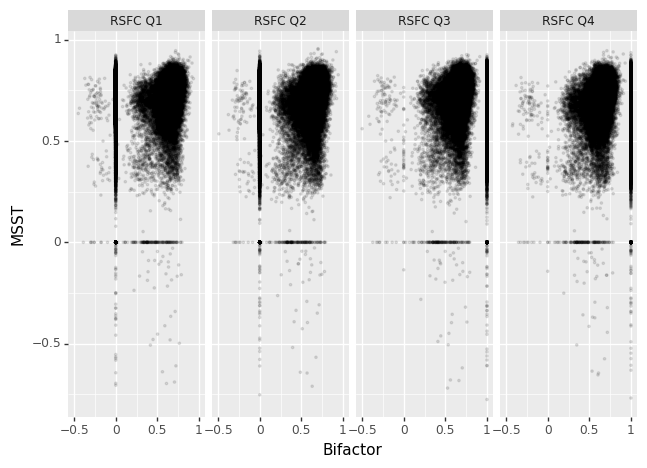

<Figure Size: (640 x 480)>

In [355]:
g = (
    ggplot(wide_concat_df, aes('Bifactor', 'MSST'))
    + geom_point(size=0.5, alpha=0.1)
    + facet_grid('~ run')
)
g

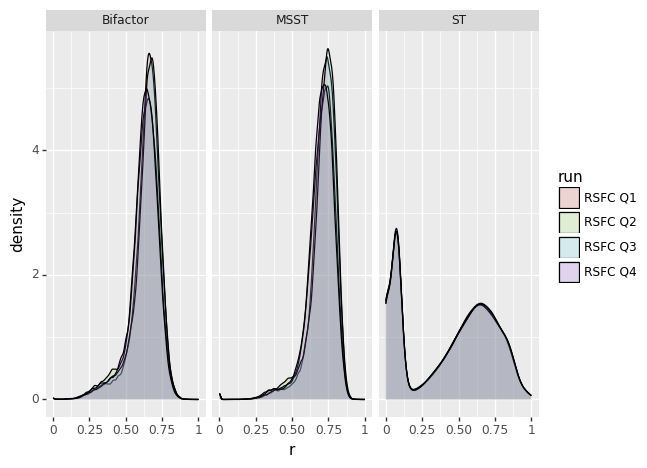

<Figure Size: (640 x 480)>

In [90]:
g = (
    ggplot(long_concat_df.query('(r > 0) & (r < 1)'), aes('r',fill='run'))
    + geom_density(alpha=0.2)
    + coord_cartesian(xlim=[0, 1])
    + facet_grid('~ model')
)
g

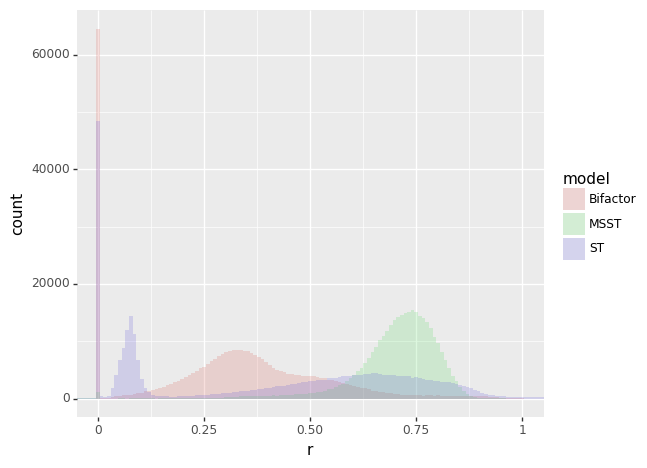

<Figure Size: (640 x 480)>

In [76]:
g = (
    ggplot(long_concat_df, aes('r', fill='model'))
    + geom_histogram(alpha=0.2, position="identity")
    + coord_cartesian(xlim=[0, 1])
)
g

<Axes: ylabel='Count'>

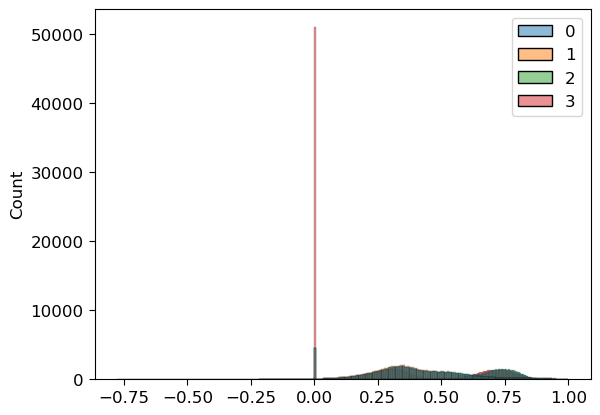

In [39]:
fig, ax = plt.subplots()
sns.histplot(nogs_msst_params[:, :4, 0], ax=ax, columns=)
sns.histplot(nogs_bf_params[:, :4, 0], ax=ax)

### Explore factor scores

In [205]:
fscores_fold0_nogs_msst = np.load(
    '/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/factor_scores/combined/split_half_cv/factor_scores_Model_onlyFC_Trait_None_Scale_None_sampleN_203_Fold_0_nogs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_seed0_2024-12-12 13:17:41_combined.npy'
)

In [206]:
fscores_fold1_nogs_msst = np.load(
    '/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/factor_scores/combined/split_half_cv/factor_scores_Model_onlyFC_Trait_None_Scale_None_sampleN_204_Fold_1_nogs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_seed0_2024-12-12 13:32:33_combined.npy'
)

In [204]:
fscores_fold1_nogs_bifactor = np.load(
    '/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/factor_scores/combined/split_half_cv/factor_scores_Model_onlyFC_Trait_None_Scale_None_sampleN_204_Fold_1_nogs_edgeN_93096_Est_MLR_z_Bifactor_OutStd_lavaan_session_split_half_family_seed0_2025-05-29 08:10:54_combined.npy'
)

In [202]:
fscores_fold0_nogs_bifactor = np.load(
    '/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/factor_scores/combined/split_half_cv/factor_scores_Model_onlyFC_Trait_None_Scale_None_sampleN_203_Fold_0_nogs_edgeN_93096_Est_MLR_z_Bifactor_OutStd_lavaan_session_split_half_family_seed0_2025-05-29 08:09:33_combined.npy'
)

In [207]:
fscores_fold0_nogs_bifactor.shape

(93096, 203, 3)

In [209]:
bifactor_msst_fscore_array = np.empty(shape=93096)
for i in range(93096):
    bifactor_msst_fscore_array[i] = np.corrcoef(fscores_fold0_nogs_bifactor[i, :, 2], fscores_fold0_nogs_msst[i, :, 2])[0, 1]

In [224]:
np.sum(bifactor_msst_fscore_array > .99) / 93096 * 100

90.01138609607288

In [227]:
mat_df = get_empty_df_for_hmap('Schaefer')
edges_df = get_edge_summary(network_hem_order=True)
edges_df = generate_set_of_networks(edges_df)
edges_df.sort_values("edge", inplace=True)
edges_df['fscore_cor'] = bifactor_msst_fscore_array
wide_df = get_wide_df_hmap(edges_df, value_col_name='fscore_cor')
mat_df = fill_mat_df(mat_df, wide_df, 'nogs')

draw_hmaps_fcs(
    mat_df,
    get_nodes_df('Schaefer'),
    'Oranges'
)

In [225]:
bifactor_msst_fscore_array

array([1., 1., 1., ..., 1., 1., 1.])

In [216]:
np.unique(bifactor_msst_fscore_array)1

array([-1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -0.99999998, -0.99999991, -0.99999985, -0.99999981, -0.99999978,
       -0.99999977, -0.99999971, -0.99999966, -0.99999951, -0.99999917,
       -0.99999874, -0.99999853, -0.99999845, -0.99999844, -0.99

(array([    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,   353.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0., 

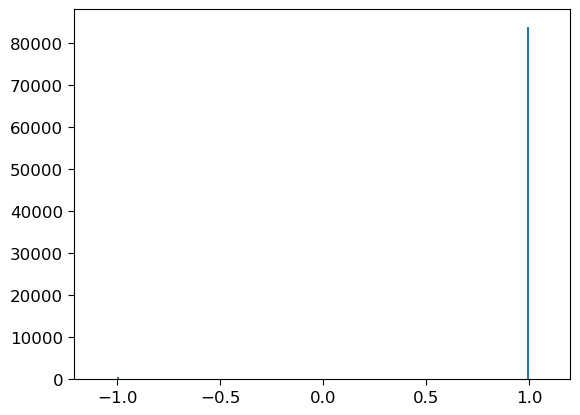

In [217]:
plt.hist(bifactor_msst_fscore_array, bins=np.arange(-1.1, 1.1, 0.01))

### Explore reasons of failing to establish models with method factor of measurement order

#### Create combined array

In [175]:
reload(postprocess)
from postprocess import *

In [176]:
for fold in [0, 1]:
    create_combined_files_from_slurm_array(
        bi_factor=False,
        controls=None,
        data_type_list=['fit_indices', 'parameters'],
        family_fold=fold,
        controls_before='',
        add_marker=False,
        order_in_day=False,
        single_trait=True,
        multistate_single_trait=False,
        random_seed=0,
        search_trash=False,
        over_write=True,
        select_cb=True,
        **{'sample_n': 199, 'edge_n': 93096},
    )

Processing /home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices in _nogs_.
(93096, 15)
Saving fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_0_nogs_edgeN_93096_Est_MLR_z_controllingBefore__SingleTrait_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-06-04 10:00:03_combined.npy.
Saving completed.
Processing /home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/parameters in _nogs_.
(93096, 9, 5)
Saving params_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_0_nogs_edgeN_93096_Est_MLR_z_controllingBefore__SingleTrait_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-06-04 10:00:03_combined.npy.
Saving completed.
Processing /home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices in _gs_.
(93096, 15)
Saving fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_0_gs_edgeN_93096_Est_MLR_z_controllingBefore__SingleTrait_OutSt

In [510]:
create_combined_files_from_slurm_array(
    bi_factor=False,
    controls=None,
    data_type_list=['fit_indices', 'parameters'],
    family_fold=0,
    controls_before='',
    add_marker=False,
    order_in_day=False,
    single_trait=True,
    multistate_single_trait=False,
    random_seed=0,
    search_trash=False,
    over_write=True,
    select_cb=True,
    **{'sample_n': 203, 'edge_n': 93096},
)

Processing /home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices in _nogs_.
(93096, 15)
Saving fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_203_Fold_0_nogs_edgeN_93096_Est_MLR_z_controllingBefore__SingleTrait_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-05-31 17:26:16_combined.npy.
Saving completed.
Processing /home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/parameters in _nogs_.
(93096, 9, 5)
Saving params_Model_onlyFC_Trait_None_Scale_None_sampleN_203_Fold_0_nogs_edgeN_93096_Est_MLR_z_controllingBefore__SingleTrait_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-05-31 17:26:16_combined.npy.
Saving completed.
Processing /home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices in _gs_.
(93096, 15)
Saving fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_203_Fold_0_gs_edgeN_93096_Est_MLR_z_controllingBefore__SingleTrait_OutSt

In [512]:
create_combined_files_from_slurm_array(
    bi_factor=False,
    controls=None,
    data_type_list=['fit_indices', 'parameters'],
    family_fold=1,
    controls_before='',
    add_marker=False,
    order_in_day=False,
    single_trait=True,
    multistate_single_trait=False,
    random_seed=0,
    search_trash=False,
    over_write=True,
    select_cb=True,
    **{'sample_n': 204, 'edge_n': 93096},
)

Processing /home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices in _nogs_.
(93096, 15)
Saving fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_204_Fold_1_nogs_edgeN_93096_Est_MLR_z_controllingBefore__SingleTrait_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-05-31 17:27:28_combined.npy.
Saving completed.
Processing /home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/parameters in _nogs_.
(93096, 9, 5)
Saving params_Model_onlyFC_Trait_None_Scale_None_sampleN_204_Fold_1_nogs_edgeN_93096_Est_MLR_z_controllingBefore__SingleTrait_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-05-31 17:27:28_combined.npy.
Saving completed.
Processing /home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices in _gs_.
(93096, 15)
Saving fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_204_Fold_1_gs_edgeN_93096_Est_MLR_z_controllingBefore__SingleTrait_OutSt

In [548]:
create_combined_files_from_slurm_array(
    bi_factor=False,
    controls=None,
    data_type_list=['fit_indices', 'parameters'],
    family_fold=0,
    controls_before='',
    add_marker=False,
    order_in_day=False,
    multistate_single_trait=True,
    random_seed=0,
    search_trash=False,
    over_write=True,
    **{'sample_n': 199, 'edge_n': 93096},
)

Processing /home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices in _nogs_.
(93096, 15)
Saving fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_0_nogs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-06-01 06:46:29_combined.npy.
Saving completed.
Processing /home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/parameters in _nogs_.
(93096, 13, 5)
Saving params_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_0_nogs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-06-01 06:46:29_combined.npy.
Saving completed.
Processing /home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices in _gs_.
(93096, 15)
Saving fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_0_gs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-06-01 06:48:35_combine

In [549]:
create_combined_files_from_slurm_array(
    bi_factor=False,
    controls=None,
    data_type_list=['fit_indices', 'parameters'],
    family_fold=1,
    controls_before='',
    add_marker=False,
    order_in_day=False,
    multistate_single_trait=True,
    random_seed=0,
    search_trash=False,
    over_write=True,
    select_cb=True,
    **{'sample_n': 199, 'edge_n': 93096},
)

Processing /home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices in _nogs_.
(93096, 15)
Saving fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_1_nogs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-06-01 06:48:17_combined.npy.
Saving completed.
Processing /home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/parameters in _nogs_.
(93096, 13, 5)
Saving params_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_1_nogs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-06-01 06:48:17_combined.npy.
Saving completed.
Processing /home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices in _gs_.
(93096, 15)
Saving fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_1_gs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-06-01 06:51:06_combine

In [550]:
create_combined_files_from_slurm_array(
    bi_factor=False,
    controls=None,
    data_type_list=['fit_indices', 'parameters'],
    family_fold=1,
    controls_before='',
    add_marker=True,
    order_in_day=True,
    multistate_single_trait=True,
    random_seed=0,
    search_trash=False,
    over_write=True,
    select_cb=True,
    **{'sample_n': 199, 'edge_n': 93096},
)

Processing /home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices in _nogs_.
(93096, 15)
Saving fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_1_nogs_edgeN_93096_Est_MLR_z_controllingBefore__OrderInDay_MSST_OutStd_lavaan_addMarker_session_split_half_family_SelectCB_seed0_2025-06-01 06:57:07_combined.npy.
Saving completed.
Processing /home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/parameters in _nogs_.
(93096, 22, 5)
Saving params_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_1_nogs_edgeN_93096_Est_MLR_z_controllingBefore__OrderInDay_MSST_OutStd_lavaan_addMarker_session_split_half_family_SelectCB_seed0_2025-06-01 06:57:07_combined.npy.
Saving completed.
Processing /home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices in _gs_.
(93096, 15)
Saving fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_1_gs_edgeN_93096_Est_MLR_z_control

In [551]:
create_combined_files_from_slurm_array(
    bi_factor=False,
    controls=None,
    data_type_list=['fit_indices', 'parameters'],
    family_fold=0,
    controls_before='',
    add_marker=True,
    order_in_day=True,
    multistate_single_trait=True,
    random_seed=0,
    search_trash=False,
    over_write=True,
    **{'sample_n': 199, 'edge_n': 93096},
)

Processing /home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices in _nogs_.
(93096, 15)
Saving fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_0_nogs_edgeN_93096_Est_MLR_z_controllingBefore__OrderInDay_MSST_OutStd_lavaan_addMarker_session_split_half_family_SelectCB_seed0_2025-06-01 06:54:57_combined.npy.
Saving completed.
Processing /home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/parameters in _nogs_.
(93096, 22, 5)
Saving params_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_0_nogs_edgeN_93096_Est_MLR_z_controllingBefore__OrderInDay_MSST_OutStd_lavaan_addMarker_session_split_half_family_SelectCB_seed0_2025-06-01 06:54:57_combined.npy.
Saving completed.
Processing /home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices in _gs_.
(93096, 15)
Saving fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_0_gs_edgeN_93096_Est_MLR_z_control

In [416]:
order_in_day_fit_nogs

array([[ 3.00000000e+00,  6.00000000e+00,  2.19375610e+00, ...,
        -1.11896252e+03,  5.78077515e+02,  4.13667113e-02],
       [ 3.00000000e+00,  6.00000000e+00,  6.01118135e+00, ...,
        -6.09988342e+02,  3.23590393e+02,  5.56001365e-02],
       [ 3.00000000e+00,  6.00000000e+00,  5.49294376e+00, ...,
        -8.43645203e+02,  4.40418823e+02,  5.53861149e-02],
       ...,
       [ 3.00000000e+00,  6.00000000e+00,  3.66373372e+00, ...,
        -1.44362866e+03,  7.40410583e+02,  4.81578112e-02],
       [ 3.00000000e+00,  6.00000000e+00,  1.43906240e+01, ...,
        -1.29207507e+03,  6.64633789e+02,  8.69475752e-02],
       [ 3.00000000e+00,  6.00000000e+00,  4.16407442e+00, ...,
        -1.05865039e+03,  5.47921448e+02,  4.89004068e-02]])

In [553]:
fit_path

PosixPath('/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/split_half_cv')

In [566]:
get_latest_file_from_condition()

'/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/split_half_cv/fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_0_nogs_edgeN_93096_Est_MLR_z_controllingBefore__OrderInDay_MSST_OutStd_lavaan_addMarker_session_split_half_family_SelectCB_seed0_2025-06-01 06:54:57_combined.npy'

In [570]:
order_in_day_fit_nogs = np.load(
    get_latest_file_from_condition(
        msst=True, order_in_day=True, gsr_type='_nogs_', fold=0, select_cb=True, data_type='fit_indices', sample_n=199
    )
)

/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/split_half_cv/fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_0_nogs_edgeN_93096_Est_MLR_z_controllingBefore__OrderInDay_MSST_OutStd_lavaan_addMarker_session_split_half_family_SelectCB_seed0_2025-06-01 06:54:57_combined.npy


In [571]:
order_in_day_params_nogs_validation = np.load(
    get_latest_file_from_condition(
        msst=True, order_in_day=True, gsr_type='_nogs_', fold=1, select_cb=True, data_type='parameters', sample_n=199
    )
)

/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/parameters/combined/split_half_cv/params_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_1_nogs_edgeN_93096_Est_MLR_z_controllingBefore__OrderInDay_MSST_OutStd_lavaan_addMarker_session_split_half_family_SelectCB_seed0_2025-06-01 06:57:07_combined.npy


In [102]:
bi_factor_param_orders = pd.read_csv(
    '/home/cezanne/t-haitani/hcp_data/derivatives/Python/fa_result/reliability/model_onlyFC_controlling_None_CovCor_lavaan_Bifactor_session.csv'
).iloc[:, 1:]

In [136]:
bi_factor_param_orders.iloc[4:8]

lhs  op rhs
4  ff  =~  s1
5  ff  =~  s2
6  ff  =~  s3
7  ff  =~  s4

In [166]:
[FIT_INDICES.index(i) for i in ['SRMR', 'RMSEA', 'CFI']]

[14, 10, 5]

In [263]:
FIT_INDICES

['DoF',
 'DoF_baseline',
 'chi2',
 'chi2_pvalue',
 'chi2_baseline',
 'CFI',
 'GFI',
 'AGFI',
 'NFI',
 'TLI',
 'RMSEA',
 'AIC',
 'BIC',
 'LogLik',
 'SRMR']

In [264]:
output_fit_df_st_dof = pd.DataFrame()

for fold in [0, 1]:
    for gsr_type in ['_nogs_', '_gs_']:
#         invalid_edges = np.loadtxt(
#             f'/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/invalid_edges/Fold_{fold}/errorOrder{gsr_type}invalid_edges_SRMR_0.08_RMSEA_0.08_CFI_0.9_loadings_from_0.4_to_0.9_2ndLoadings_from_0.7_to_1_controlling__.csv'
#         ).astype(int)
        fits = np.load(
            get_latest_file_from_condition(
                msst=False, 
                st=True,
                order_in_day=False,
                gsr_type=gsr_type,
                fold=fold,
                bi_factor=False,
                select_cb=True,
                data_type='fit_indices', 
                sample_n=199
            )
        )[:, [FIT_INDICES.index(i) for i in ['DoF']]]
        fits_df = pd.DataFrame(fits, columns=['DoF'])
        fits_df['gsr_type'] = gsr_type
        fits_df['fold'] = fold
        fits_df = fits_df.reset_index().rename(columns={'index': 'edge'})
#         params_df.query('~(edge in @invalid_edges)', inplace=True)
        output_fit_df_st_dof = pd.concat([output_fit_df_st_dof, fits_df], axis=0)        

/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/split_half_cv/fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_0_nogs_edgeN_93096_Est_MLR_z_controllingBefore__SingleTrait_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-06-04 10:00:03_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/split_half_cv/fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_0_gs_edgeN_93096_Est_MLR_z_controllingBefore__SingleTrait_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-06-04 10:02:16_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/split_half_cv/fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_1_nogs_edgeN_93096_Est_MLR_z_controllingBefore__SingleTrait_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-06-04 10:01:22_combined.npy
/ho

In [265]:
output_fit_df_st_dof

edge  DoF gsr_type  fold
0          0  5.0   _nogs_     0
1          1  5.0   _nogs_     0
2          2  5.0   _nogs_     0
3          3  5.0   _nogs_     0
4          4  5.0   _nogs_     0
...      ...  ...      ...   ...
93091  93091  5.0     _gs_     1
93092  93092  5.0     _gs_     1
93093  93093  5.0     _gs_     1
93094  93094  5.0     _gs_     1
93095  93095  5.0     _gs_     1

[372384 rows x 4 columns]

In [178]:
output_fit_df_st = pd.DataFrame()

for fold in [0, 1]:
    for gsr_type in ['_nogs_', '_gs_']:
#         invalid_edges = np.loadtxt(
#             f'/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/invalid_edges/Fold_{fold}/errorOrder{gsr_type}invalid_edges_SRMR_0.08_RMSEA_0.08_CFI_0.9_loadings_from_0.4_to_0.9_2ndLoadings_from_0.7_to_1_controlling__.csv'
#         ).astype(int)
        fits = np.load(
            get_latest_file_from_condition(
                msst=False, 
                st=True,
                order_in_day=False,
                gsr_type=gsr_type,
                fold=fold,
                bi_factor=False,
                select_cb=True,
                data_type='fit_indices', 
                sample_n=199
            )
        )[:, [FIT_INDICES.index(i) for i in ['SRMR', 'RMSEA', 'CFI']]]
        fits_df = pd.DataFrame(fits, columns=['SRMR', 'RMSEA', 'CFI'])
        fits_df['gsr_type'] = gsr_type
        fits_df['fold'] = fold
        fits_df = fits_df.reset_index().rename(columns={'index': 'edge'})
#         params_df.query('~(edge in @invalid_edges)', inplace=True)
        output_fit_df_st = pd.concat([output_fit_df_st, fits_df], axis=0)        

/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/split_half_cv/fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_0_nogs_edgeN_93096_Est_MLR_z_controllingBefore__SingleTrait_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-06-04 10:00:03_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/split_half_cv/fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_0_gs_edgeN_93096_Est_MLR_z_controllingBefore__SingleTrait_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-06-04 10:02:16_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/split_half_cv/fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_1_nogs_edgeN_93096_Est_MLR_z_controllingBefore__SingleTrait_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-06-04 10:01:22_combined.npy
/ho

In [267]:
output_fit_df_msst_dof

edge  DoF gsr_type  fold
0          0  4.0   _nogs_     0
1          1  4.0   _nogs_     0
2          2  4.0   _nogs_     0
3          3  4.0   _nogs_     0
4          4  4.0   _nogs_     0
...      ...  ...      ...   ...
93091  93091  4.0     _gs_     1
93092  93092  4.0     _gs_     1
93093  93093  4.0     _gs_     1
93094  93094  4.0     _gs_     1
93095  93095  4.0     _gs_     1

[372384 rows x 4 columns]

In [266]:
output_fit_df_msst_dof = pd.DataFrame()

for fold in [0, 1]:
    for gsr_type in ['_nogs_', '_gs_']:
#         invalid_edges = np.loadtxt(
#             f'/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/invalid_edges/Fold_{fold}/errorOrder{gsr_type}invalid_edges_SRMR_0.08_RMSEA_0.08_CFI_0.9_loadings_from_0.4_to_0.9_2ndLoadings_from_0.7_to_1_controlling__.csv'
#         ).astype(int)
        fits = np.load(
            get_latest_file_from_condition(
                msst=True, 
                order_in_day=False,
                gsr_type=gsr_type,
                fold=fold,
                bi_factor=False,
                select_cb=True,
                data_type='fit_indices', 
                sample_n=199
            )
        )[:, [FIT_INDICES.index(i) for i in ['DoF']]]
        fits_df = pd.DataFrame(fits, columns=['DoF'])
        fits_df['gsr_type'] = gsr_type
        fits_df['fold'] = fold
        fits_df = fits_df.reset_index().rename(columns={'index': 'edge'})
#         params_df.query('~(edge in @invalid_edges)', inplace=True)
        output_fit_df_msst_dof = pd.concat([output_fit_df_msst_dof, fits_df], axis=0)        

/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/split_half_cv/fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_0_nogs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-06-01 06:46:29_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/split_half_cv/fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_0_gs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-06-01 06:48:35_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/split_half_cv/fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_1_nogs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-06-01 06:48:17_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliabi

In [320]:
output_fit_df_bf = pd.DataFrame()

for fold in [0, 1]:
    for gsr_type in ['_nogs_', '_gs_']:
#         invalid_edges = np.loadtxt(
#             f'/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/invalid_edges/Fold_{fold}/errorOrder{gsr_type}invalid_edges_SRMR_0.08_RMSEA_0.08_CFI_0.9_loadings_from_0.4_to_0.9_2ndLoadings_from_0.7_to_1_controlling__.csv'
#         ).astype(int)
        fits = np.load(
            get_latest_file_from_condition(
                msst=False, 
                order_in_day=False,
                gsr_type=gsr_type,
                fold=fold,
                bi_factor=True,
                select_cb=True,
                data_type='fit_indices', 
                sample_n=199
            )
        )[:, [FIT_INDICES.index(i) for i in ['SRMR', 'RMSEA', 'CFI']]]
        fits_df = pd.DataFrame(fits, columns=['SRMR', 'RMSEA', 'CFI'])
        fits_df['gsr_type'] = gsr_type
        fits_df['fold'] = fold
        fits_df = fits_df.reset_index().rename(columns={'index': 'edge'})
#         params_df.query('~(edge in @invalid_edges)', inplace=True)
        output_fit_df_bf = pd.concat([output_fit_df_bf, fits_df], axis=0)        

/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/split_half_cv/fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_0_nogs_edgeN_93096_Est_MLR_z_Bifactor_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-06-03 16:01:11_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/split_half_cv/fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_0_gs_edgeN_93096_Est_MLR_z_Bifactor_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-06-03 15:59:33_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/split_half_cv/fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_1_nogs_edgeN_93096_Est_MLR_z_Bifactor_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-06-03 16:02:13_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Scha

In [168]:
output_fit_df_msst = pd.DataFrame()

for fold in [0, 1]:
    for gsr_type in ['_nogs_', '_gs_']:
#         invalid_edges = np.loadtxt(
#             f'/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/invalid_edges/Fold_{fold}/errorOrder{gsr_type}invalid_edges_SRMR_0.08_RMSEA_0.08_CFI_0.9_loadings_from_0.4_to_0.9_2ndLoadings_from_0.7_to_1_controlling__.csv'
#         ).astype(int)
        fits = np.load(
            get_latest_file_from_condition(
                msst=True, 
                order_in_day=False,
                gsr_type=gsr_type,
                fold=fold,
                bi_factor=False,
                select_cb=True,
                data_type='fit_indices', 
                sample_n=199
            )
        )[:, [FIT_INDICES.index(i) for i in ['SRMR', 'RMSEA', 'CFI']]]
        fits_df = pd.DataFrame(fits, columns=['SRMR', 'RMSEA', 'CFI'])
        fits_df['gsr_type'] = gsr_type
        fits_df['fold'] = fold
        fits_df = fits_df.reset_index().rename(columns={'index': 'edge'})
#         params_df.query('~(edge in @invalid_edges)', inplace=True)
        output_fit_df_msst = pd.concat([output_fit_df_msst, fits_df], axis=0)        

/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/split_half_cv/fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_0_nogs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-06-01 06:46:29_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/split_half_cv/fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_0_gs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-06-01 06:48:35_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/split_half_cv/fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_1_nogs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-06-01 06:48:17_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliabi

In [180]:
output_fit_df_st = convert_df(output_fit_df_st)

In [321]:
output_fit_df_bf = convert_df(output_fit_df_bf)

In [170]:
output_fit_df_msst = convert_df(output_fit_df_msst)

In [171]:
output_fit_df_msst

edge      SRMR     RMSEA       CFI     gsr_type         fold
0          0  0.012784  0.000000  1.000000  Without GSR  Exploratory
1          1  0.018734  0.000000  1.000000  Without GSR  Exploratory
2          2  0.019047  0.000000  1.000000  Without GSR  Exploratory
3          3  0.020696  0.032198  0.996935  Without GSR  Exploratory
4          4  0.041636  0.038127  0.995531  Without GSR  Exploratory
...      ...       ...       ...       ...          ...          ...
93091  93091  0.044615  0.052890  0.994730     With GSR   Validation
93092  93092  0.069290  0.070902  0.990929     With GSR   Validation
93093  93093  0.101987  0.135194  0.956304     With GSR   Validation
93094  93094  0.072335  0.079831  0.986729     With GSR   Validation
93095  93095  0.041608  0.000000  1.000000     With GSR   Validation

[372384 rows x 6 columns]

In [181]:
output_fit_df_st = output_fit_df_st.melt(
    id_vars=['edge', 'gsr_type', 'fold'],
    value_vars=['SRMR', 'RMSEA', 'CFI']
)

In [322]:
output_fit_df_bf = output_fit_df_bf.melt(
    id_vars=['edge', 'gsr_type', 'fold'],
    value_vars=['SRMR', 'RMSEA', 'CFI']
)

In [172]:
output_fit_df_msst = output_fit_df_msst.melt(
    id_vars=['edge', 'gsr_type', 'fold'],
    value_vars=['SRMR', 'RMSEA', 'CFI']
)

In [323]:
output_fit_df_st['model'] = 'Single-trait model'
output_fit_df_msst['model'] = 'Multistate single-trait model'
output_fit_df_bf['model'] = 'Bi-factor model'

In [324]:
output_fit_df_concat = pd.concat([output_fit_df_st, output_fit_df_msst, output_fit_df_bf], axis=0)
output_fit_df_concat['model'] = pd.Categorical(
    output_fit_df_concat['model'], categories=['Single-trait model', 'Multistate single-trait model', 'Bi-factor model']
)

In [186]:
output_fit_df_concat

edge     gsr_type         fold variable     value  \
0            0  Without GSR  Exploratory     SRMR  0.055863   
1            1  Without GSR  Exploratory     SRMR  0.052331   
2            2  Without GSR  Exploratory     SRMR  0.056277   
3            3  Without GSR  Exploratory     SRMR  0.063391   
4            4  Without GSR  Exploratory     SRMR  0.061065   
...        ...          ...          ...      ...       ...   
1117147  93091     With GSR   Validation      CFI  0.994730   
1117148  93092     With GSR   Validation      CFI  0.990929   
1117149  93093     With GSR   Validation      CFI  0.956304   
1117150  93094     With GSR   Validation      CFI  0.986729   
1117151  93095     With GSR   Validation      CFI  1.000000   

                                 model  
0                   Single-trait model  
1                   Single-trait model  
2                   Single-trait model  
3                   Single-trait model  
4                   Single-trait model  
...                                ...  
1117147  Multistate single-trait model  
1117148  Multistate single-trait model  
1117149  Multistate single-trait model  
1117150  Multistate single-trait model  
1117151  Multistate single-trait model  

[2234304 rows x 6 columns]

In [336]:
 g_legend = (
        ggplot(output_fit_df_concat.query('variable == "SRMR"'), aes('value', fill='model'))
        + geom_histogram(alpha=0.2)
        + theme_bw()
        + theme(
            axis_text_x=element_blank(),
            axis_text_y=element_blank(),
            axis_title_y=element_blank(),
            axis_title_x=element_blank(),
            legend_title=element_blank(),
            panel_border=element_blank(),
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank(),
            axis_ticks_major_x=element_blank(),
            axis_ticks_major_y=element_blank(),
            axis_ticks_minor_y=element_blank(),
            legend_position=(0.5, 0.5),
            legend_direction='horizontal',
            legend_background=element_rect(fill='white'),
            legend_box_background=element_rect(fill='white'),
            figure_size=(1, 0.3)
        )
#         + scale_color_manual(%%!values=color_list)
    )
# g_legend

In [340]:
g_legend_loaded = load_ggplot(g_legend, figsize=(12, 0.5))
g_srmr_loaded = load_ggplot(g_srmr, figsize=(4, 3))
g_rmsea_loaded = load_ggplot(g_rmsea, figsize=(4, 3))
g_cfi_loaded = load_ggplot(g_cfi, figsize=(4, 3))

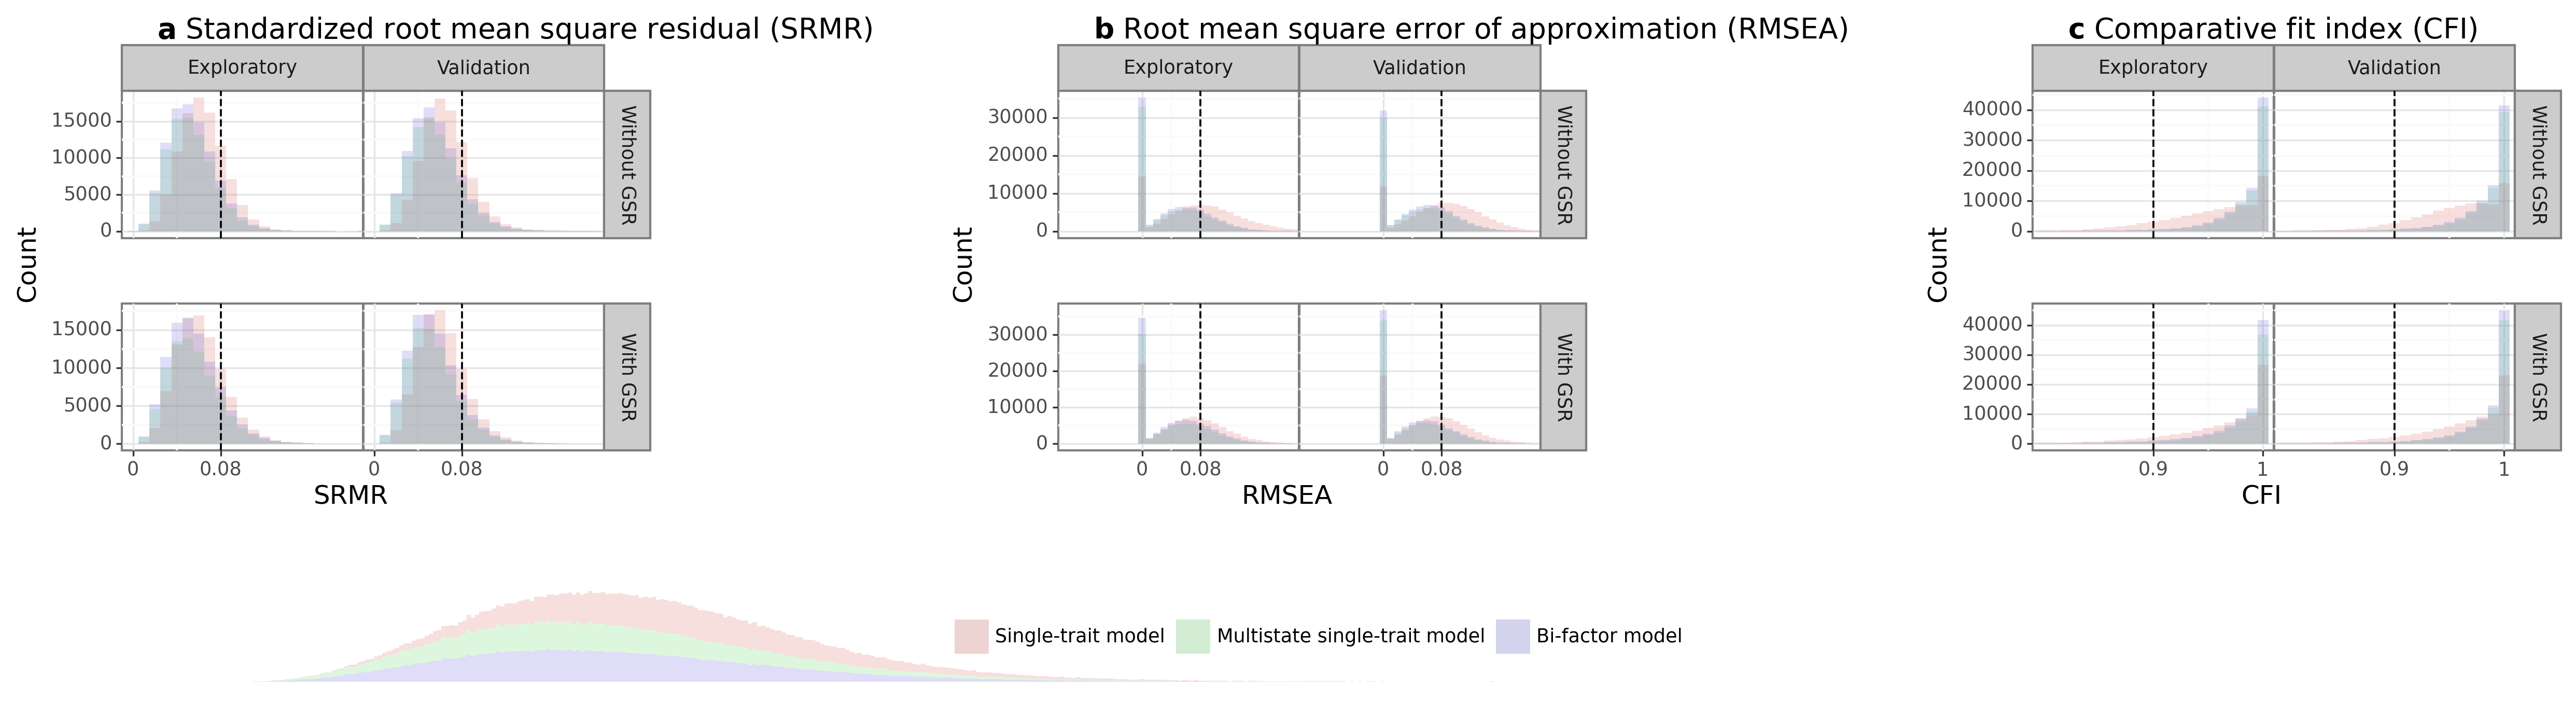

In [341]:
g_combined = (g_srmr_loaded | g_rmsea_loaded | g_cfi_loaded) / g_legend_loaded
g_combined

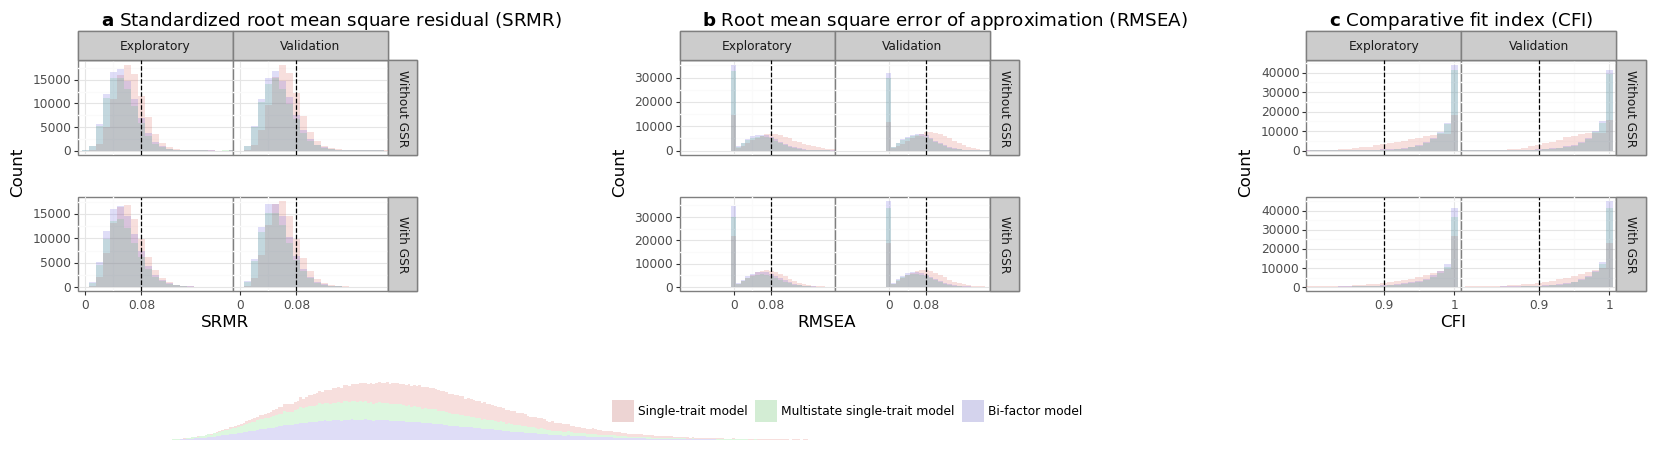

In [342]:
g_combined.savefig(
    '/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/figures/fit_indices_msst_st_bf_01.png'
)

In [337]:
g_srmr = (
    ggplot(output_fit_df_concat.query('variable == "SRMR"'), aes('value', fill='model'))
    + geom_histogram(alpha=0.2, position='identity', binwidth=0.01)
    + facet_grid('gsr_type ~ fold', scales='free')
    + coord_cartesian(xlim=[0, 0.2])
    + theme_bw()
    + theme(
        legend_position='none'
    )
    + labs(
        x="SRMR", y='Count',
        title=r'$\bf{a}$' + ' Standardized root mean square residual (SRMR)'
    )
    + geom_vline(xintercept=0.08, linetype='dashed')
    + scale_x_continuous(breaks=[0, 0.08])
)
# g.save('/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/figures/msst_std_load_second.png')
# g_srmr

In [195]:
output_fit_df_concat.query('variable == "CFI"')['value'].max()

1.0

In [194]:
output_fit_df_concat.query('variable == "RMSEA"')['value'].min()

0.0

In [338]:
g_rmsea = (
    ggplot(output_fit_df_concat.query('variable == "RMSEA"'), aes('value', fill='model'))
    + geom_histogram(alpha=0.2, binwidth=0.01, position='identity')
    + facet_grid('gsr_type ~ fold', scales='free')
    + coord_cartesian(xlim=[-0.1, 0.2])
    + theme_bw()
    + theme(
        legend_position='none'
    )
    + labs(
        x="RMSEA", y='Count',
        title=r'$\bf{b}$' + ' Root mean square error of approximation (RMSEA)'
    )
    + geom_vline(xintercept=0.08, linetype='dashed')
    + scale_x_continuous(breaks=[0, 0.08])
)
# g.save('/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/figures/msst_std_load_second.png')
# g_rmsea

In [339]:
g_cfi = (
    ggplot(output_fit_df_concat.query('variable == "CFI"'), aes('value', fill='model'))
    + geom_histogram(alpha=0.2, position='identity', binwidth=0.01)
    + facet_grid('gsr_type ~ fold', scales='free')
    + coord_cartesian(xlim=[0.8, 1])
    + theme_bw()
    + theme(
        legend_position='none'
    )
    + labs(
        x="CFI", y='Count',
        title=r'$\bf{c}$' + ' Comparative fit index (CFI)'
    )
    + geom_vline(xintercept=0.9, linetype='dashed')
    + scale_x_continuous(breaks=[0.9, 1])
)
# g.save('/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/figures/msst_std_load_second.png')
# g_cfi

In [ ]:
msst_param_orders = pd.read_csv(
    
)

In [156]:
output_second_loadings_df_msst = pd.DataFrame()
# sample_n_dict = {0: 203, 1: 204}
for fold in [0, 1]:
    for gsr_type in ['_nogs_', '_gs_']:
#         invalid_edges = np.loadtxt(
#             f'/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/invalid_edges/Fold_{fold}/errorOrder{gsr_type}invalid_edges_SRMR_0.08_RMSEA_0.08_CFI_0.9_loadings_from_0.4_to_0.9_2ndLoadings_from_0.7_to_1_controlling__.csv'
#         ).astype(int)
        params = np.load(
            get_latest_file_from_condition(
                msst=True, 
                order_in_day=False,
                gsr_type=gsr_type,
                fold=fold,
                bi_factor=False,
                select_cb=True,
                data_type='parameters', 
                sample_n=199
            )
        )[:, 4:6, 0]
#         set_trace()
        params_df = pd.DataFrame(params, columns=['Day 1', 'Day 2'])
        params_df['gsr_type'] = gsr_type
        params_df['fold'] = fold
        params_df = params_df.reset_index().rename(columns={'index': 'edge'})
#         params_df.query('~(edge in @invalid_edges)', inplace=True)
        output_second_loadings_df_msst = pd.concat([output_second_loadings_df_msst, params_df], axis=0)        

/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/parameters/combined/split_half_cv/params_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_0_nogs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-06-01 06:46:29_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/parameters/combined/split_half_cv/params_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_0_gs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-06-01 06:48:35_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/parameters/combined/split_half_cv/params_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_1_nogs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-06-01 06:48:17_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/parameters/co

In [146]:
output_first_loadings_df_msst = pd.DataFrame()
# sample_n_dict = {0: 203, 1: 204}
for fold in [0, 1]:
    for gsr_type in ['_nogs_', '_gs_']:
#         invalid_edges = np.loadtxt(
#             f'/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/invalid_edges/Fold_{fold}/errorOrder{gsr_type}invalid_edges_SRMR_0.08_RMSEA_0.08_CFI_0.9_loadings_from_0.4_to_0.9_2ndLoadings_from_0.7_to_1_controlling__.csv'
#         ).astype(int)
        params = np.load(
            get_latest_file_from_condition(
                msst=True, 
                order_in_day=False,
                gsr_type=gsr_type,
                fold=fold,
                bi_factor=False,
                select_cb=True,
                data_type='parameters', 
                sample_n=199
            )
        )[:, :4, 0]
#         set_trace()
        params_df = pd.DataFrame(params, columns=[f'RSFC Q{i}' for i in range(1, 5)])
        params_df['gsr_type'] = gsr_type
        params_df['fold'] = fold
        params_df = params_df.reset_index().rename(columns={'index': 'edge'})
#         params_df.query('~(edge in @invalid_edges)', inplace=True)
        output_first_loadings_df_msst = pd.concat([output_first_loadings_df_msst, params_df], axis=0)        

/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/parameters/combined/split_half_cv/params_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_0_nogs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-06-01 06:46:29_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/parameters/combined/split_half_cv/params_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_0_gs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-06-01 06:48:35_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/parameters/combined/split_half_cv/params_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_1_nogs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-06-01 06:48:17_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/parameters/co

In [137]:
output_general_loadings_df_bf = pd.DataFrame()
# sample_n_dict = {0: 203, 1: 204}
for fold in [0, 1]:
    for gsr_type in ['_nogs_', '_gs_']:
#         invalid_edges = np.loadtxt(
#             f'/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/invalid_edges/Fold_{fold}/errorOrder{gsr_type}invalid_edges_SRMR_0.08_RMSEA_0.08_CFI_0.9_loadings_from_0.4_to_0.9_2ndLoadings_from_0.7_to_1_controlling__.csv'
#         ).astype(int)
        params = np.load(
            get_latest_file_from_condition(
                msst=False, 
                order_in_day=False,
                gsr_type=gsr_type,
                fold=fold,
                bi_factor=True,
                select_cb=True,
                data_type='parameters', 
                sample_n=199
            )
        )[:, 4:8, 0]
#         set_trace()
        params_df = pd.DataFrame(params, columns=[f'RSFC Q{i}' for i in range(1, 5)])
        params_df['gsr_type'] = gsr_type
        params_df['fold'] = fold
        params_df = params_df.reset_index().rename(columns={'index': 'edge'})
#         params_df.query('~(edge in @invalid_edges)', inplace=True)
        output_general_loadings_df_bf = pd.concat([output_general_loadings_df_bf, params_df], axis=0)        

/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/parameters/combined/split_half_cv/params_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_0_nogs_edgeN_93096_Est_MLR_z_Bifactor_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-06-03 16:01:11_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/parameters/combined/split_half_cv/params_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_0_gs_edgeN_93096_Est_MLR_z_Bifactor_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-06-03 15:59:33_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/parameters/combined/split_half_cv/params_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_1_nogs_edgeN_93096_Est_MLR_z_Bifactor_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-06-03 16:02:13_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/p

In [287]:
output_day_loadings_df_bf

edge   RSFC Q1   RSFC Q2   RSFC Q3   RSFC Q4     gsr_type         fold
0          0  0.422973  0.337095  0.410761  0.366004  Without GSR  Exploratory
1          1  0.367980  0.331513  0.371991  0.350122  Without GSR  Exploratory
2          2  0.409587  0.350900  0.402332  0.373353  Without GSR  Exploratory
3          3  0.417748  0.374081  0.427647  0.384319  Without GSR  Exploratory
4          4  0.349523  0.316816  0.349803  0.325690  Without GSR  Exploratory
...      ...       ...       ...       ...       ...          ...          ...
93091  93091  0.181297  0.192018  0.192425  0.189580     With GSR   Validation
93092  93092  0.181945  0.193948  0.193159  0.193061     With GSR   Validation
93093  93093  0.250285  0.262779  0.273946  0.267136     With GSR   Validation
93094  93094  0.169973  0.179271  0.189210  0.172419     With GSR   Validation
93095  93095  0.232542  0.245254  0.231284  0.231485     With GSR   Validation

[372384 rows x 7 columns]

In [129]:
output_day_loadings_df_bf = pd.DataFrame()
# sample_n_dict = {0: 203, 1: 204}
for fold in [0, 1]:
    for gsr_type in ['_nogs_', '_gs_']:
#         invalid_edges = np.loadtxt(
#             f'/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/invalid_edges/Fold_{fold}/errorOrder{gsr_type}invalid_edges_SRMR_0.08_RMSEA_0.08_CFI_0.9_loadings_from_0.4_to_0.9_2ndLoadings_from_0.7_to_1_controlling__.csv'
#         ).astype(int)
        params = np.load(
            get_latest_file_from_condition(
                msst=False, 
                order_in_day=False,
                gsr_type=gsr_type,
                fold=fold,
                bi_factor=True,
                select_cb=True,
                data_type='parameters', 
                sample_n=199
            )
        )[:, :4, 0]
#         set_trace()
        params_df = pd.DataFrame(params, columns=[f'RSFC Q{i}' for i in range(1, 5)])
        params_df['gsr_type'] = gsr_type
        params_df['fold'] = fold
        params_df = params_df.reset_index().rename(columns={'index': 'edge'})
#         params_df.query('~(edge in @invalid_edges)', inplace=True)
        output_day_loadings_df_bf = pd.concat([output_day_loadings_df_bf, params_df], axis=0)        

/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/parameters/combined/split_half_cv/params_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_0_nogs_edgeN_93096_Est_MLR_z_Bifactor_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-06-03 16:01:11_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/parameters/combined/split_half_cv/params_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_0_gs_edgeN_93096_Est_MLR_z_Bifactor_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-06-03 15:59:33_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/parameters/combined/split_half_cv/params_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_1_nogs_edgeN_93096_Est_MLR_z_Bifactor_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-06-03 16:02:13_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/p

In [158]:
output_second_loadings_df_msst = convert_df(output_second_loadings_df_msst)

In [130]:
output_day_loadings_df_bf = convert_df(output_day_loadings_df_bf)

In [138]:
output_general_loadings_df_bf = convert_df(output_general_loadings_df_bf)

In [147]:
output_first_loadings_df_msst = convert_df(output_first_loadings_df_msst)

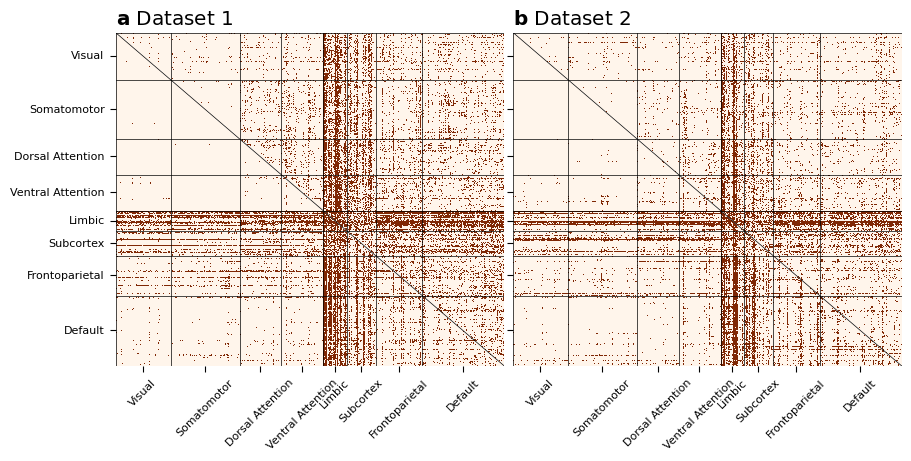

In [319]:
parcellation = 'Schaefer'
edges_df = get_edge_summary(parcellation, network_hem_order=True)
edges_df.sort_values("edge", inplace=True)
nodes_df = get_nodes_df(parcellation)
mat_df = get_empty_df_for_hmap(parcellation)
atlas_dir = ATLAS_DIR_DICT.get(parcellation)

# Loop for GSR type
for gsr_type in ['nogs', 'gs']:
    if gsr_type == 'nogs':
        invalid_edges = nogs_valid_edges
    else:
        invalid_edges = gs_valid_edges
    edges_df["invalid"] = [i in invalid_edges for i in edges_df["edge"]]
    edges_df["invalid"] = edges_df["invalid"].astype(float)
    # Shape of wide_edges_df is number of parcellation
    wide_edges_df = get_wide_df_hmap(edges_df, value_col_name="invalid")
    mat_df = fill_mat_df(mat_df, wide_edges_df, gsr_type)

fig, axes = plt.subplots(1, 2, sharey=True, layout='constrained', figsize=(9, 4.5))
draw_hmaps_fcs(
    mat_df, 
    nodes_df, 
    cmap='Oranges', 
#    save_filename=save_filename, 
    cbar_ax=False, 
    ax=axes[1], 
#     num_iter=num_iter,
    parcellation=parcellation,
    add_custom_cbar=False,
)

draw_hmaps_fcs(
    mat_df_exp, 
    nodes_df, 
    cmap='Oranges', 
#    save_filename=save_filename, 
    cbar_ax=False, 
    ax=axes[0], 
#     num_iter=num_iter,
    parcellation=parcellation,
    add_custom_cbar=False,
)

axes[0].set_title(r'$\bf{a}$' + ' Dataset 1', loc='left')

axes[1].set_title(r'$\bf{b}$' + ' Dataset 2', loc='left')
fig.savefig(
    '/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/figures/bifactor_0_load_edges.png'
           )

In [315]:
parcellation = 'Schaefer'
edges_df = get_edge_summary(parcellation, network_hem_order=True)
edges_df.sort_values("edge", inplace=True)
nodes_df = get_nodes_df(parcellation)
mat_df_exp = get_empty_df_for_hmap(parcellation)
atlas_dir = ATLAS_DIR_DICT.get(parcellation)

# Loop for GSR type
for gsr_type in ['nogs', 'gs']:
    if gsr_type == 'nogs':
        invalid_edges = nogs_exp_edges
    else:
        invalid_edges = gs_exp_edges
    edges_df["invalid"] = [i in invalid_edges for i in edges_df["edge"]]
    edges_df["invalid"] = edges_df["invalid"].astype(float)
    # Shape of wide_edges_df is number of parcellation
    wide_edges_df = get_wide_df_hmap(edges_df, value_col_name="invalid")
    mat_df_exp = fill_mat_df(mat_df_exp, wide_edges_df, gsr_type)

# fig, ax = plt.subplots()
# draw_hmaps_fcs(
#     mat_df, 
#     nodes_df, 
#     cmap='Oranges', 
# #    save_filename=save_filename, 
#     cbar_ax=False, 
#     ax=ax, 
# #     num_iter=num_iter,
#     parcellation=parcellation,
#     add_custom_cbar=False,
# )
# ax.set_title(r'$\bf{a}$' + ' Dataset 1', loc='left')
# fig.savefig(
#     '/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/figures/bifactor_0_load_edges_exp.png'
#            )

In [312]:
gs_valid_edges = output_day_loadings_df_bf.query(
    '(`RSFC Q1` < 0.01) & (`RSFC Q1` > -0.01) & (`RSFC Q2` < 0.01) & (`RSFC Q2` > -0.01) & (`RSFC Q3` < 0.01) & (`RSFC Q3` > -0.01) & (`RSFC Q4` < 0.01) & (`RSFC Q4` > -0.01)'
).query('(fold == "Validation") & (gsr_type == "With GSR")')['edge'].to_numpy()

In [313]:
nogs_valid_edges = output_day_loadings_df_bf.query(
    '(`RSFC Q1` < 0.01) & (`RSFC Q1` > -0.01) & (`RSFC Q2` < 0.01) & (`RSFC Q2` > -0.01) & (`RSFC Q3` < 0.01) & (`RSFC Q3` > -0.01) & (`RSFC Q4` < 0.01) & (`RSFC Q4` > -0.01)'
).query('(fold == "Validation") & (gsr_type == "Without GSR")')['edge'].to_numpy()

In [302]:
gs_exp_edges = output_day_loadings_df_bf.query(
    '(`RSFC Q1` < 0.01) & (`RSFC Q1` > -0.01) & (`RSFC Q2` < 0.01) & (`RSFC Q2` > -0.01) & (`RSFC Q3` < 0.01) & (`RSFC Q3` > -0.01) & (`RSFC Q4` < 0.01) & (`RSFC Q4` > -0.01)'
).query('(fold == "Exploratory") & (gsr_type == "With GSR")')['edge'].to_numpy()

In [159]:
output_second_loadings_df_msst = output_second_loadings_df_msst.melt(
    id_vars=['edge', 'gsr_type', 'fold'],
    value_vars=['Day 1', 'Day 2']
)

In [160]:
output_second_loadings_df_msst

edge     gsr_type         fold variable     value
0           0  Without GSR  Exploratory    Day 1  0.866042
1           1  Without GSR  Exploratory    Day 1  0.898458
2           2  Without GSR  Exploratory    Day 1  0.873085
3           3  Without GSR  Exploratory    Day 1  0.860302
4           4  Without GSR  Exploratory    Day 1  0.899162
...       ...          ...          ...      ...       ...
744763  93091     With GSR   Validation    Day 2  0.973300
744764  93092     With GSR   Validation    Day 2  0.973326
744765  93093     With GSR   Validation    Day 2  0.942471
744766  93094     With GSR   Validation    Day 2  0.974996
744767  93095     With GSR   Validation    Day 2  0.961083

[744768 rows x 5 columns]

In [148]:
output_first_loadings_df_msst = output_first_loadings_df_msst.melt(
    id_vars=['edge', 'gsr_type', 'fold'],
    value_vars=[f'RSFC Q{i}' for i in range(1, 5)]
)

In [139]:
long_general_loadings_df_bf = output_general_loadings_df_bf.melt(
    id_vars=['edge', 'gsr_type', 'fold'],
    value_vars=[f'RSFC Q{i}' for i in range(1, 5)]
)

In [132]:
long_day_loadings_df_bf = output_day_loadings_df_bf.melt(
    id_vars=['edge', 'gsr_type', 'fold'],
    value_vars=[f'RSFC Q{i}' for i in range(1, 5)]
)

In [288]:
long_day_loadings_df_bf

edge     gsr_type         fold variable     value
0            0  Without GSR  Exploratory  RSFC Q1  0.422973
1            1  Without GSR  Exploratory  RSFC Q1  0.367980
2            2  Without GSR  Exploratory  RSFC Q1  0.409587
3            3  Without GSR  Exploratory  RSFC Q1  0.417748
4            4  Without GSR  Exploratory  RSFC Q1  0.349523
...        ...          ...          ...      ...       ...
1489531  93091     With GSR   Validation  RSFC Q4  0.189580
1489532  93092     With GSR   Validation  RSFC Q4  0.193061
1489533  93093     With GSR   Validation  RSFC Q4  0.267136
1489534  93094     With GSR   Validation  RSFC Q4  0.172419
1489535  93095     With GSR   Validation  RSFC Q4  0.231485

[1489536 rows x 5 columns]

In [151]:
output_first_loadings_df_msst

edge     gsr_type         fold variable     value
0            0  Without GSR  Exploratory  RSFC Q1  0.845995
1            1  Without GSR  Exploratory  RSFC Q1  0.838112
2            2  Without GSR  Exploratory  RSFC Q1  0.840062
3            3  Without GSR  Exploratory  RSFC Q1  0.819461
4            4  Without GSR  Exploratory  RSFC Q1  0.798699
...        ...          ...          ...      ...       ...
1489531  93091     With GSR   Validation  RSFC Q4  0.825925
1489532  93092     With GSR   Validation  RSFC Q4  0.841486
1489533  93093     With GSR   Validation  RSFC Q4  0.799119
1489534  93094     With GSR   Validation  RSFC Q4  0.775879
1489535  93095     With GSR   Validation  RSFC Q4  0.837928

[1489536 rows x 5 columns]

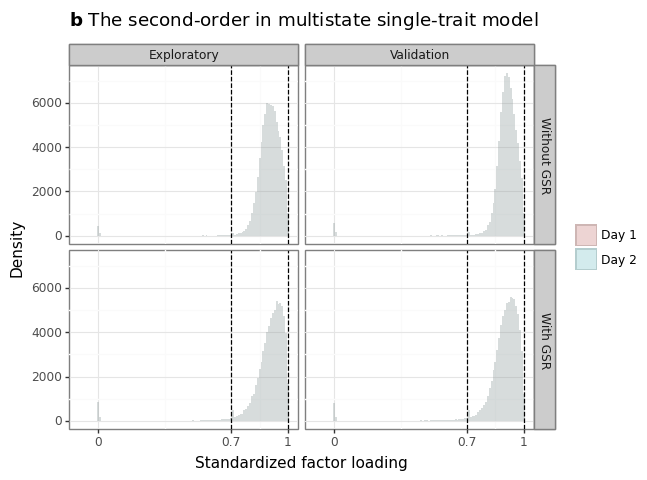

<Figure Size: (640 x 480)>

In [284]:
g = (
    ggplot(output_second_loadings_df_msst, aes('value', fill='variable'))
    + geom_histogram(alpha=0.2, position='identity', binwidth=0.01)
    + facet_grid('gsr_type ~ fold')
    + coord_cartesian(xlim=[-0.1, 1])
    + theme_bw()
    + theme(legend_title=element_blank())
    + labs(x="Standardized factor loading", y='Density', title=r'$\bf{b}$' + ' The second-order in multistate single-trait model')
    + geom_vline(xintercept=[0.7, 1], linetype='dashed')
    + scale_x_continuous(breaks=[0, 0.7, 1])
)
g.save('/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/figures/msst_std_load_second_hist_001.png')
g

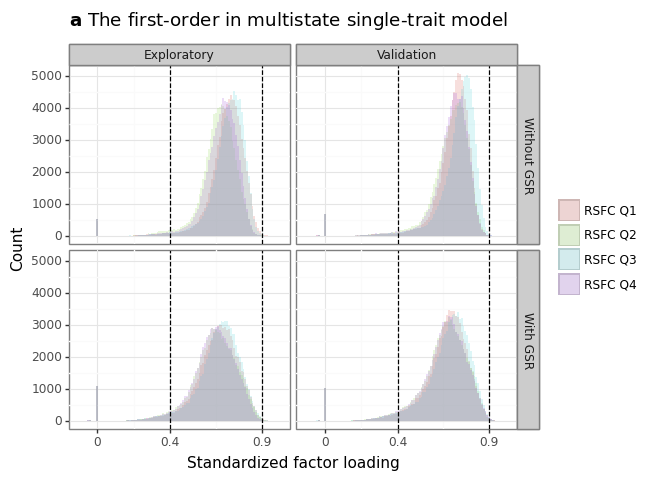

<Figure Size: (640 x 480)>

In [283]:
g = (
    ggplot(output_first_loadings_df_msst, aes('value', fill='variable'))
    + geom_histogram(alpha=0.2, position='identity', binwidth=0.01)
    + facet_grid('gsr_type ~ fold')
    + coord_cartesian(xlim=[-0.1, 1])
    + theme_bw()
    + theme(legend_title=element_blank())
    + labs(x="Standardized factor loading", y='Count', title=r'$\bf{a}$' + ' The first-order in multistate single-trait model')
    + geom_vline(xintercept=[0.4, 0.9], linetype='dashed')
    + scale_x_continuous(breaks=[0, 0.4, 0.9])
)
g.save('/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/figures/msst_std_load_first_hist_001.png')
g

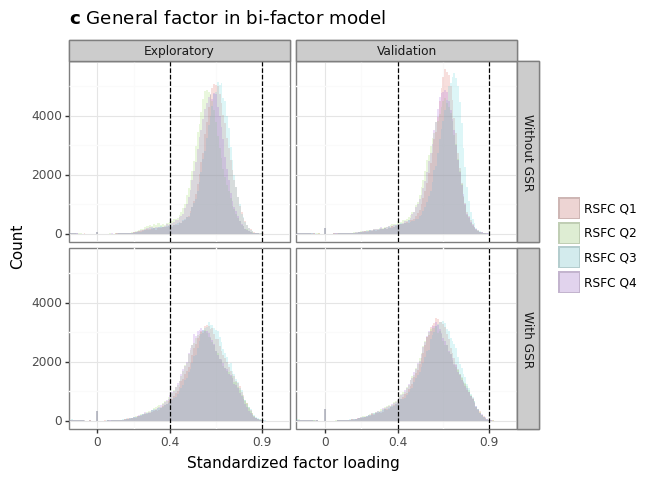

<Figure Size: (640 x 480)>

In [282]:
g = (
    ggplot(long_general_loadings_df_bf, aes('value', fill='variable'))
    + geom_histogram(alpha=0.2, position='identity', binwidth=0.01)
    + facet_grid('gsr_type ~ fold')
    + coord_cartesian(xlim=[-0.1, 1])
    + theme_bw()
    + theme(legend_title=element_blank())
    + labs(x="Standardized factor loading", y='Count', title=r'$\bf{c}$' + ' General factor in bi-factor model')
    + geom_vline(xintercept=[0.4, 0.9], linetype='dashed')
    + scale_x_continuous(breaks=[0, 0.4, 0.9])
)
g.save('/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/figures/bifactor_std_load_general_hist_001.png')
g

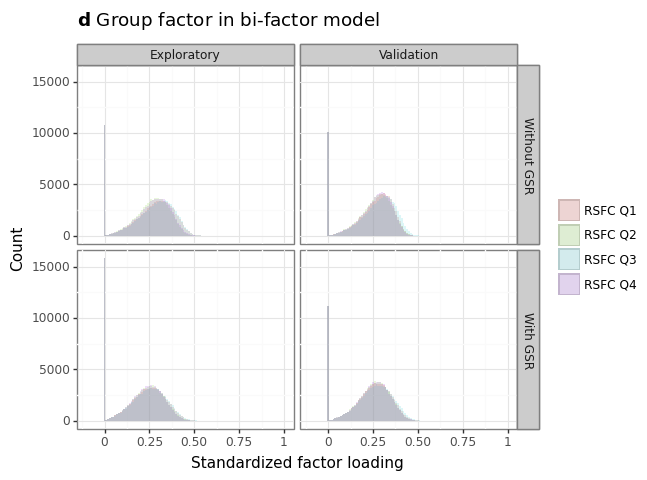

<Figure Size: (640 x 480)>

In [285]:
g = (
    ggplot(long_day_loadings_df_bf, aes('value', fill='variable'))
    + geom_histogram(alpha=0.2, position='identity', binwidth=0.01)
    + facet_grid('gsr_type ~ fold')
    + coord_cartesian(xlim=[-0.1, 1])
    + theme_bw()
    + theme(legend_title=element_blank())
    + labs(x="Standardized factor loading", y='Count', title=r'$\bf{d}$' + ' Group factor in bi-factor model')
)
g.save(
    '/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/figures/bifactor_std_load_group_hist_001.png'
)
g

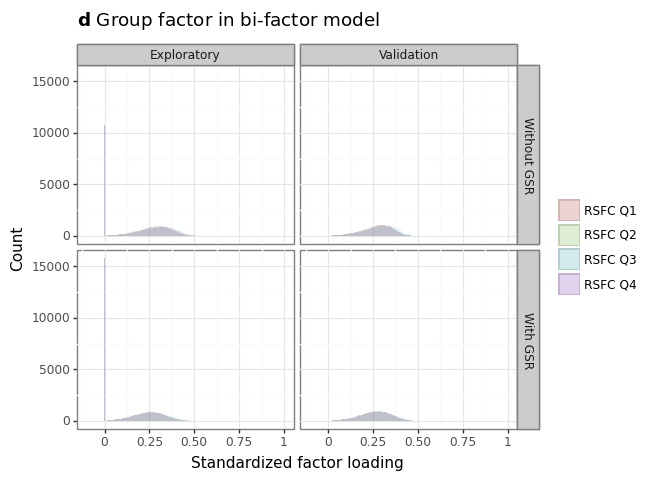

<Figure Size: (640 x 480)>

In [273]:
g = (
    ggplot(long_day_loadings_df_bf, aes('value', fill='variable'))
    + geom_histogram(alpha=0.2, position='identity', binwidth=0.0025)
    + facet_grid('gsr_type ~ fold')
    + coord_cartesian(xlim=[-0.1, 1])
    + theme_bw()
    + theme(legend_title=element_blank())
    + labs(x="Standardized factor loading", y='Count', title=r'$\bf{d}$' + ' Group factor in bi-factor model')
)
g.save('/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/figures/bifactor_std_load_group_hist.png')
g

In [374]:
output_df_method_loadings = pd.DataFrame()
for fold in [0, 1]:
    for gsr_type in ['_nogs_', '_gs_']:
        invalid_edges = np.loadtxt(
            f'/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/invalid_edges/Fold_{fold}/errorOrder{gsr_type}invalid_edges_SRMR_0.08_RMSEA_0.08_CFI_0.9_loadings_from_0.4_to_0.9_2ndLoadings_from_0.7_to_1_controlling__.csv'
        ).astype(int)
        order_in_day_params = np.load(
            get_latest_file_from_condition(
                msst=True, order_in_day=True, gsr_type=gsr_type, fold=fold, select_cb=True, data_type='parameters', sample_n=199
            )
        )[:, method_loadings_index, 0]
        params_df = pd.DataFrame(order_in_day_params, columns=[f'RSFC Q{i}' for i in range(1, 5)])
        params_df['gsr_type'] = gsr_type
        params_df['fold'] = fold
        params_df = params_df.reset_index().rename(columns={'index': 'edge'})
#         params_df.query('~(edge in @invalid_edges)', inplace=True)
        output_df_method_loadings = pd.concat([output_df_method_loadings, params_df], axis=0)        

/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/parameters/combined/split_half_cv/params_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_0_nogs_edgeN_93096_Est_MLR_z_controllingBefore__OrderInDay_MSST_OutStd_lavaan_addMarker_session_split_half_family_SelectCB_seed0_2025-06-01 06:54:57_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/parameters/combined/split_half_cv/params_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_0_gs_edgeN_93096_Est_MLR_z_controllingBefore__OrderInDay_MSST_OutStd_lavaan_addMarker_session_split_half_family_SelectCB_seed0_2025-06-01 06:57:27_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/parameters/combined/split_half_cv/params_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_1_nogs_edgeN_93096_Est_MLR_z_controllingBefore__OrderInDay_MSST_OutStd_lavaan_addMarker_session_split_half_family_SelectCB_seed0_2025-06-01 0

In [349]:
output_df_method_loadings

edge       RSFC Q1       RSFC Q2       RSFC Q3       RSFC Q4 gsr_type  \
0          0  1.577564e-01  1.530465e-01  1.261467e-01  1.371072e-01   _nogs_   
1          1  1.375607e-01  1.389491e-01  1.241818e-01  1.312692e-01   _nogs_   
2          2  1.375375e-01  1.349206e-01  1.179900e-01  1.257233e-01   _nogs_   
3          3  2.492550e-01  2.549295e-01  2.253835e-01  2.318283e-01   _nogs_   
5          5  9.997393e-09  9.583643e-09  8.164445e-09  8.691126e-09   _nogs_   
...      ...           ...           ...           ...           ...      ...   
93088  93088  1.734563e-01  1.783994e-01  1.760020e-01  1.777836e-01     _gs_   
93089  93089 -2.531601e-09 -2.639892e-09 -2.650269e-09 -2.601236e-09     _gs_   
93090  93090  2.680576e-01  2.889631e-01  2.811987e-01  2.966241e-01     _gs_   
93091  93091 -1.537930e-10 -1.632262e-10 -1.629052e-10 -1.608223e-10     _gs_   
93095  93095  1.182382e-01  1.178408e-01  1.249082e-01  1.176676e-01     _gs_   

       fold  
0         0  
1         0  
2         0  
3         0  
5         0  
...     ...  
93088     1  
93089     1  
93090     1  
93091     1  
93095     1  

[233963 rows x 7 columns]

In [8]:
def convert_df(df):
    gsr_map = {'_nogs_': 'Without GSR', '_gs_': 'With GSR'}
    fold_map = {0: 'Exploratory', 1: 'Validation'}

    df['gsr_type'] = df['gsr_type'].map(gsr_map)
    df['fold'] = df['fold'].map(fold_map)

    df['gsr_type'] = pd.Categorical(
        df['gsr_type'],
        categories=['Without GSR', 'With GSR']
        )
    return df

In [375]:
output_df_method_loadings = convert_df(output_df_method_loadings)

In [95]:
gsr_map = {'_nogs_': 'Without GSR', '_gs_': 'With GSR'}
fold_map = {0: 'Exploratory', 1: 'Validation'}

output_df_method_loadings['gsr_type'] = output_df_method_loadings['gsr_type'].map(gsr_map)
output_df_method_loadings['fold'] = output_df_method_loadings['fold'].map(fold_map)

output_df_method_loadings['gsr_type'] = pd.Categorical(
    output_df_method_loadings['gsr_type'],
    categories=['Without GSR', 'With GSR']
    )

In [368]:
output_df_method_loadings

edge       RSFC Q1       RSFC Q2       RSFC Q3       RSFC Q4  \
0          0  1.577564e-01  1.530465e-01  1.261467e-01  1.371072e-01   
1          1  1.375607e-01  1.389491e-01  1.241818e-01  1.312692e-01   
2          2  1.375375e-01  1.349206e-01  1.179900e-01  1.257233e-01   
3          3  2.492550e-01  2.549295e-01  2.253835e-01  2.318283e-01   
5          5  9.997393e-09  9.583643e-09  8.164445e-09  8.691126e-09   
...      ...           ...           ...           ...           ...   
93088  93088  1.734563e-01  1.783994e-01  1.760020e-01  1.777836e-01   
93089  93089 -2.531601e-09 -2.639892e-09 -2.650269e-09 -2.601236e-09   
93090  93090  2.680576e-01  2.889631e-01  2.811987e-01  2.966241e-01   
93091  93091 -1.537930e-10 -1.632262e-10 -1.629052e-10 -1.608223e-10   
93095  93095  1.182382e-01  1.178408e-01  1.249082e-01  1.176676e-01   

          gsr_type         fold  
0      Without GSR  Exploratory  
1      Without GSR  Exploratory  
2      Without GSR  Exploratory  
3      Without GSR  Exploratory  
5      Without GSR  Exploratory  
...            ...          ...  
93088     With GSR   Validation  
93089     With GSR   Validation  
93090     With GSR   Validation  
93091     With GSR   Validation  
93095     With GSR   Validation  

[233963 rows x 7 columns]

In [351]:
long_methods_df = output_df_method_loadings.melt(
    id_vars=['edge', 'gsr_type', 'fold'],
    value_vars=[f'RSFC Q{i}' for i in range(1, 5)],
    value_name='loadings'
)

In [377]:
output_df_method_loadings['mean_loading'] = output_df_method_loadings[[f'RSFC Q{i}' for i in range(1, 5)]].mean(axis=1)

In [378]:
output_df_method_loadings

edge       RSFC Q1       RSFC Q2       RSFC Q3       RSFC Q4  \
0          0  1.577564e-01  1.530465e-01  1.261467e-01  1.371072e-01   
1          1  1.375607e-01  1.389491e-01  1.241818e-01  1.312692e-01   
2          2  1.375375e-01  1.349206e-01  1.179900e-01  1.257233e-01   
3          3  2.492550e-01  2.549295e-01  2.253835e-01  2.318283e-01   
4          4  2.250203e-01  2.252472e-01  2.060298e-01  2.117533e-01   
...      ...           ...           ...           ...           ...   
93091  93091 -1.537930e-10 -1.632262e-10 -1.629052e-10 -1.608223e-10   
93092  93092 -1.099477e-08 -1.167243e-08 -1.172012e-08 -1.166651e-08   
93093  93093  1.326898e-01  1.461991e-01  1.402100e-01  1.416464e-01   
93094  93094  1.415319e-01  1.586001e-01  1.504835e-01  1.437821e-01   
93095  93095  1.182382e-01  1.178408e-01  1.249082e-01  1.176676e-01   

          gsr_type         fold  mean_loading  
0      Without GSR  Exploratory  1.435142e-01  
1      Without GSR  Exploratory  1.329902e-01  
2      Without GSR  Exploratory  1.290428e-01  
3      Without GSR  Exploratory  2.403491e-01  
4      Without GSR  Exploratory  2.170126e-01  
...            ...          ...           ...  
93091     With GSR   Validation -1.601867e-10  
93092     With GSR   Validation -1.151346e-08  
93093     With GSR   Validation  1.401863e-01  
93094     With GSR   Validation  1.485994e-01  
93095     With GSR   Validation  1.196637e-01  

[372384 rows x 8 columns]

In [358]:
output_day_loadings_df_bf.groupby(['gsr_type', 'fold'])[[f'RSFC Q{i}' for i in range(1, 5)]].corr()

RSFC Q1   RSFC Q2   RSFC Q3   RSFC Q4
gsr_type    fold                                                       
Without GSR Exploratory RSFC Q1  1.000000  0.985020  0.987705  0.988056
                        RSFC Q2  0.985020  1.000000  0.991635  0.988542
                        RSFC Q3  0.987705  0.991635  1.000000  0.986751
                        RSFC Q4  0.988056  0.988542  0.986751  1.000000
            Validation  RSFC Q1  1.000000  0.987052  0.988891  0.990256
                        RSFC Q2  0.987052  1.000000  0.991243  0.988871
                        RSFC Q3  0.988891  0.991243  1.000000  0.986336
                        RSFC Q4  0.990256  0.988871  0.986336  1.000000
With GSR    Exploratory RSFC Q1  1.000000  0.986698  0.989057  0.989937
                        RSFC Q2  0.986698  1.000000  0.991274  0.989228
                        RSFC Q3  0.989057  0.991274  1.000000  0.986631
                        RSFC Q4  0.989937  0.989228  0.986631  1.000000
            Validation  RSFC Q1  1.000000  0.983516  0.987138  0.987497
                        RSFC Q2  0.983516  1.000000  0.990083  0.987189
                        RSFC Q3  0.987138  0.990083  1.000000  0.983448
                        RSFC Q4  0.987497  0.987189  0.983448  1.000000

In [359]:
long_methods_df.groupby(['edge', ''])

edge     gsr_type         fold variable      loadings
0           0  Without GSR  Exploratory  RSFC Q1  1.577564e-01
1           1  Without GSR  Exploratory  RSFC Q1  1.375607e-01
2           2  Without GSR  Exploratory  RSFC Q1  1.375375e-01
3           3  Without GSR  Exploratory  RSFC Q1  2.492550e-01
4           5  Without GSR  Exploratory  RSFC Q1  9.997393e-09
...       ...          ...          ...      ...           ...
935847  93088     With GSR   Validation  RSFC Q4  1.777836e-01
935848  93089     With GSR   Validation  RSFC Q4 -2.601236e-09
935849  93090     With GSR   Validation  RSFC Q4  2.966241e-01
935850  93091     With GSR   Validation  RSFC Q4 -1.608223e-10
935851  93095     With GSR   Validation  RSFC Q4  1.176676e-01

[935852 rows x 5 columns]

In [364]:
output_day_loadings_df_bf

edge   RSFC Q1   RSFC Q2   RSFC Q3   RSFC Q4     gsr_type  \
0          0  0.422973  0.337095  0.410761  0.366004  Without GSR   
1          1  0.367980  0.331513  0.371991  0.350122  Without GSR   
2          2  0.409587  0.350900  0.402332  0.373353  Without GSR   
3          3  0.417748  0.374081  0.427647  0.384319  Without GSR   
4          4  0.349523  0.316816  0.349803  0.325690  Without GSR   
...      ...       ...       ...       ...       ...          ...   
93091  93091  0.181297  0.192018  0.192425  0.189580     With GSR   
93092  93092  0.181945  0.193948  0.193159  0.193061     With GSR   
93093  93093  0.250285  0.262779  0.273946  0.267136     With GSR   
93094  93094  0.169973  0.179271  0.189210  0.172419     With GSR   
93095  93095  0.232542  0.245254  0.231284  0.231485     With GSR   

              fold  mean_loading  
0      Exploratory      0.384208  
1      Exploratory      0.355402  
2      Exploratory      0.384043  
3      Exploratory      0.400949  
4      Exploratory      0.335458  
...            ...           ...  
93091   Validation      0.188830  
93092   Validation      0.190528  
93093   Validation      0.263537  
93094   Validation      0.177718  
93095   Validation      0.235141  

[372384 rows x 8 columns]

In [373]:
output_df_method_loadings

edge       RSFC Q1       RSFC Q2       RSFC Q3       RSFC Q4  \
0          0  1.577564e-01  1.530465e-01  1.261467e-01  1.371072e-01   
1          1  1.375607e-01  1.389491e-01  1.241818e-01  1.312692e-01   
2          2  1.375375e-01  1.349206e-01  1.179900e-01  1.257233e-01   
3          3  2.492550e-01  2.549295e-01  2.253835e-01  2.318283e-01   
5          5  9.997393e-09  9.583643e-09  8.164445e-09  8.691126e-09   
...      ...           ...           ...           ...           ...   
93088  93088  1.734563e-01  1.783994e-01  1.760020e-01  1.777836e-01   
93089  93089 -2.531601e-09 -2.639892e-09 -2.650269e-09 -2.601236e-09   
93090  93090  2.680576e-01  2.889631e-01  2.811987e-01  2.966241e-01   
93091  93091 -1.537930e-10 -1.632262e-10 -1.629052e-10 -1.608223e-10   
93095  93095  1.182382e-01  1.178408e-01  1.249082e-01  1.176676e-01   

          gsr_type         fold  mean_loading  
0      Without GSR  Exploratory  1.435142e-01  
1      Without GSR  Exploratory  1.329902e-01  
2      Without GSR  Exploratory  1.290428e-01  
3      Without GSR  Exploratory  2.403491e-01  
5      Without GSR  Exploratory  9.109152e-09  
...            ...          ...           ...  
93088     With GSR   Validation  1.764104e-01  
93089     With GSR   Validation -2.605750e-09  
93090     With GSR   Validation  2.837109e-01  
93091     With GSR   Validation -1.601867e-10  
93095     With GSR   Validation  1.196637e-01  

[233963 rows x 8 columns]

In [379]:
mat_df_exp = get_empty_df_for_hmap(parcellation)
edges_df = get_edge_summary(parcellation, network_hem_order=True)
edges_df.sort_values("edge", inplace=True)
# Loop for GSR type
for gsr_type in ['nogs', 'gs']:
    gsr_name = 'With GSR' if gsr_type == 'gs' else 'Without GSR'
#     if gsr_type == 'nogs':
#         invalid_edges = nogs_valid_edges
#     else:
#         invalid_edges = gs_valid_edges
    edges_df["loading"] = output_df_method_loadings.query(
        '(fold == "Exploratory") & (gsr_type == @gsr_name)'
    )['mean_loading'].to_numpy()
#     edges_df["invalid"] = edges_df["invalid"].astype(float)
    # Shape of wide_edges_df is number of parcellation
    wide_edges_df = get_wide_df_hmap(edges_df, value_col_name="loading")
    mat_df_exp = fill_mat_df(mat_df_exp, wide_edges_df, gsr_type)

Text(0.0, 1.0, '$\\bf{b}$ Dataset 2')

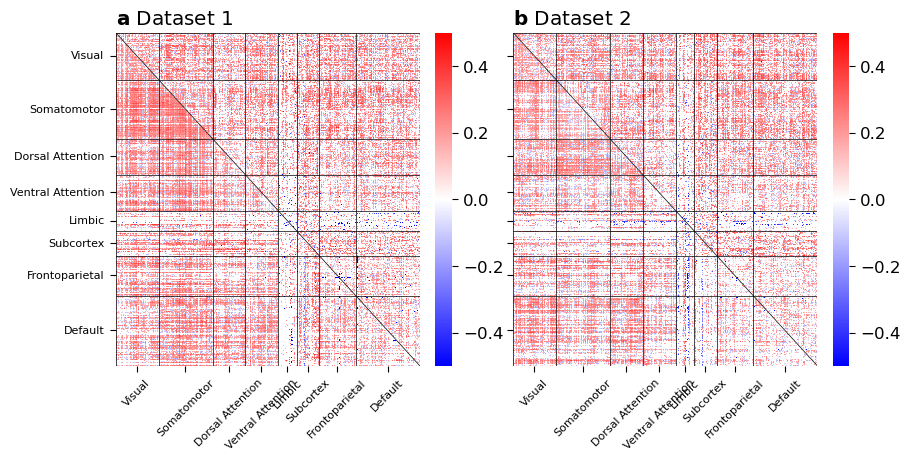

In [381]:
parcellation = 'Schaefer'
edges_df = get_edge_summary(parcellation, network_hem_order=True)
edges_df.sort_values("edge", inplace=True)
nodes_df = get_nodes_df(parcellation)
mat_df = get_empty_df_for_hmap(parcellation)
atlas_dir = ATLAS_DIR_DICT.get(parcellation)

# Loop for GSR type
for gsr_type in ['nogs', 'gs']:
    gsr_name = 'With GSR' if gsr_type == 'gs' else 'Without GSR'
#     if gsr_type == 'nogs':
#         invalid_edges = nogs_valid_edges
#     else:
#         invalid_edges = gs_valid_edges
    edges_df["loading"] = output_df_method_loadings.query(
        '(fold == "Validation") & (gsr_type == @gsr_name)'
    )['mean_loading'].to_numpy()
#     edges_df["invalid"] = edges_df["invalid"].astype(float)
    # Shape of wide_edges_df is number of parcellation
    wide_edges_df = get_wide_df_hmap(edges_df, value_col_name="loading")
    mat_df = fill_mat_df(mat_df, wide_edges_df, gsr_type)

fig, axes = plt.subplots(1, 2, sharey=True, layout='constrained', figsize=(9, 4.5))
draw_hmaps_fcs(
    mat_df, 
    nodes_df, 
    cmap='bwr', 
#    save_filename=save_filename, 
    cbar_ax=False, 
    ax=axes[1], 
    vmax=0.5, 
    vmin=-0.5,
#     num_iter=num_iter,
    parcellation=parcellation,
    add_custom_cbar=False,
    cbar=True
)

draw_hmaps_fcs(
    mat_df_exp, 
    nodes_df, 
    cmap='bwr', 
#    save_filename=save_filename, 
    cbar_ax=False, 
    ax=axes[0], 
    vmin=-0.5,
    vmax=0.5,
#     num_iter=num_iter,
    parcellation=parcellation,
    add_custom_cbar=False,
    cbar=True
)

axes[0].set_title(r'$\bf{a}$' + ' Dataset 1', loc='left')

axes[1].set_title(r'$\bf{b}$' + ' Dataset 2', loc='left')
# fig.savefig(
#     '/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/figures/bifactor_0_load_edges.png'
#            )

In [352]:
long_methods_df

edge     gsr_type         fold variable      loadings
0           0  Without GSR  Exploratory  RSFC Q1  1.577564e-01
1           1  Without GSR  Exploratory  RSFC Q1  1.375607e-01
2           2  Without GSR  Exploratory  RSFC Q1  1.375375e-01
3           3  Without GSR  Exploratory  RSFC Q1  2.492550e-01
4           5  Without GSR  Exploratory  RSFC Q1  9.997393e-09
...       ...          ...          ...      ...           ...
935847  93088     With GSR   Validation  RSFC Q4  1.777836e-01
935848  93089     With GSR   Validation  RSFC Q4 -2.601236e-09
935849  93090     With GSR   Validation  RSFC Q4  2.966241e-01
935850  93091     With GSR   Validation  RSFC Q4 -1.608223e-10
935851  93095     With GSR   Validation  RSFC Q4  1.176676e-01

[935852 rows x 5 columns]

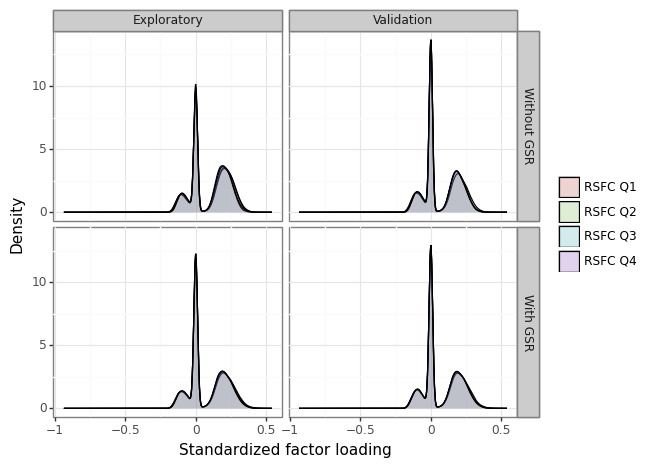

<Figure Size: (640 x 480)>

In [113]:
g = (
    ggplot(long_methods_df, aes('loadings'))
    + geom_density(aes(fill='variable'), alpha=0.2)
    + facet_grid('gsr_type ~ fold')
    + theme_bw()
    + theme(legend_title=element_blank())
    + labs(x='Standardized factor loading', y='Density')
)
g.save('/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/figures/dens_method_loadings.png')
g

In [112]:
(long_methods_df['loadings'] == 0).sum()

0

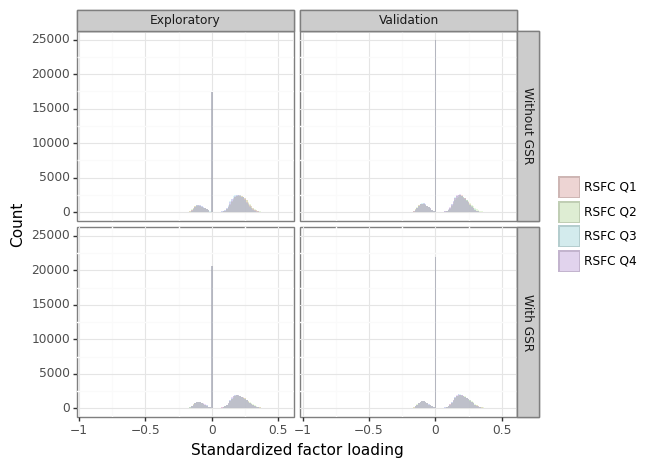

<Figure Size: (640 x 480)>

In [117]:
g = (
    ggplot(long_methods_df, aes('loadings'))
    + geom_histogram(aes(fill='variable'), alpha=0.2, position='identity', binwidth=0.0125)
    + facet_grid('gsr_type ~ fold')
    + theme_bw()
    + theme(
        legend_title=element_blank()
    )
    + labs(x='Standardized factor loading', y='Count')
)
g.save('/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/figures/hist_method_loadings.png')
g

In [572]:
order_in_day_params_nogs = np.load(
    get_latest_file_from_condition(
        msst=True, order_in_day=True, gsr_type='_nogs_', fold=0, select_cb=True, data_type='parameters', sample_n=199
    )[:, method_loadings_index, 0]
)

/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/parameters/combined/split_half_cv/params_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_0_nogs_edgeN_93096_Est_MLR_z_controllingBefore__OrderInDay_MSST_OutStd_lavaan_addMarker_session_split_half_family_SelectCB_seed0_2025-06-01 06:54:57_combined.npy


In [385]:
order_in_day_params_nogs.shape

(93096, 22, 5)

In [373]:
method_loadings_index

Index([10, 11, 12, 13], dtype='int64')

(array([[3.0000e+01, 3.2000e+01, 5.5000e+01, 1.4600e+02, 2.8900e+02,
         5.5100e+02, 8.0100e+02, 1.0790e+03, 1.2360e+03, 1.3060e+03,
         1.2900e+03, 1.2420e+03, 1.1500e+03, 1.0030e+03, 8.7000e+02,
         6.6300e+02, 5.2400e+02, 3.3100e+02, 2.2400e+02, 1.8409e+04,
         1.9649e+04, 2.2000e+01, 3.3000e+01, 4.0000e+01, 5.4000e+01,
         6.0000e+01, 9.2000e+01, 1.2200e+02, 2.1900e+02, 2.8100e+02,
         4.8100e+02, 7.2800e+02, 1.0190e+03, 1.3820e+03, 1.8330e+03,
         2.0940e+03, 2.3850e+03, 2.5100e+03, 2.5420e+03, 2.4930e+03,
         2.3040e+03, 2.1140e+03, 1.9250e+03, 1.8150e+03, 1.5420e+03,
         1.3260e+03, 1.0760e+03, 8.6700e+02, 6.5600e+02, 4.4700e+02,
         3.2400e+02, 2.3800e+02, 1.5700e+02, 1.0600e+02, 8.8000e+01,
         5.4000e+01, 3.4000e+01, 2.0000e+01, 8.0000e+00, 3.0000e+00,
         3.0000e+00, 3.0000e+00, 1.0000e+00, 0.0000e+00, 2.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0

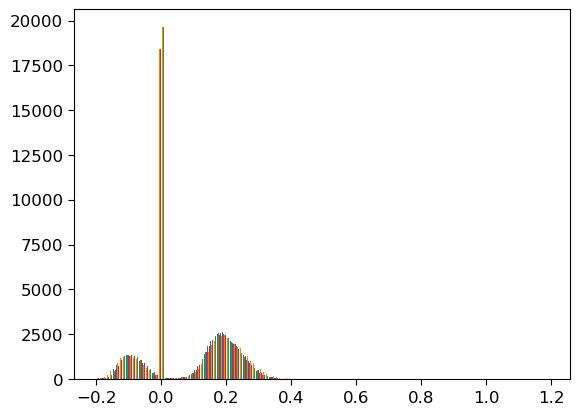

In [573]:
plt.hist(order_in_day_params_nogs_validation[:, method_loadings_index, 0], bins=np.arange(-0.2, 1.2, 0.01))

(array([[1.5000e+01, 2.7000e+01, 5.8000e+01, 1.5500e+02, 3.2100e+02,
         5.9800e+02, 8.8400e+02, 1.0140e+03, 1.1640e+03, 1.1610e+03,
         1.1330e+03, 1.1180e+03, 9.5900e+02, 8.1500e+02, 7.3200e+02,
         5.9800e+02, 4.5900e+02, 3.3000e+02, 1.4100e+02, 1.5398e+04,
         1.6329e+04, 2.2000e+01, 3.2000e+01, 3.3000e+01, 4.6000e+01,
         4.7000e+01, 6.3000e+01, 1.1100e+02, 1.5500e+02, 2.2100e+02,
         3.7000e+02, 6.0000e+02, 8.4600e+02, 1.1800e+03, 1.5940e+03,
         1.9490e+03, 2.2460e+03, 2.5240e+03, 2.5440e+03, 2.6560e+03,
         2.7020e+03, 2.6710e+03, 2.5410e+03, 2.3700e+03, 2.2870e+03,
         2.1060e+03, 1.8520e+03, 1.5300e+03, 1.3150e+03, 1.0710e+03,
         8.5900e+02, 6.6100e+02, 4.6700e+02, 3.5200e+02, 2.6400e+02,
         1.8400e+02, 1.3300e+02, 8.6000e+01, 5.5000e+01, 3.3000e+01,
         1.8000e+01, 2.1000e+01, 1.5000e+01, 1.0000e+01, 5.0000e+00,
         1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0

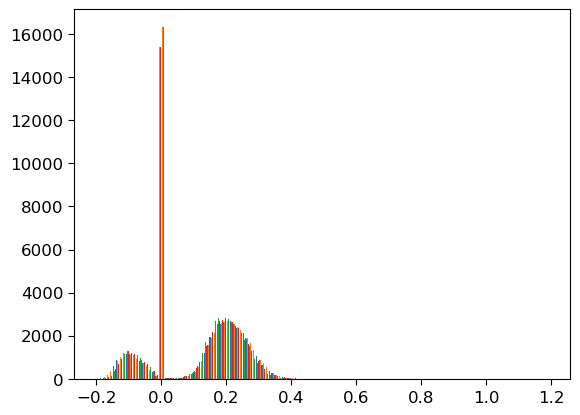

In [574]:
plt.hist(order_in_day_params_nogs[:, method_loadings_index, 0], bins=np.arange(-0.2, 1.2, 0.01))

(array([[0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 4.090e+02, 4.180e+02, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
         1.000e+00, 1.000e+00, 4.000e+00, 1.000e+00, 4.000e+00, 1.000e+01,
         5.000e+00, 9.000e+00, 5.000e+00, 1.300e+01, 1.100e+01, 1.400e+01,
         2.400e+01, 2.800e+01, 2.800e+01, 4.100e+01, 4.700e+01, 5.700e+01,
         5.100e+01, 5.700e+01, 7.400e+01, 7.100e+01, 8.700e+01, 6.800e+01,
         6.800e+01, 8.500e+01, 8.800e+01, 8.700e+01, 9.600e+01, 8.100e+01,
         1.020e+02, 9.900e+01, 1.070e+02, 1.020e+02, 1.110e+02, 1.280e+02,
         1.540e+02, 1.720e+02, 1.730e+02, 2.040e+02, 2.290e+02, 2.820e+02,
         2.820e+02, 3.690e+02, 4.010e+02, 5.550e+02, 6.490e+02, 7.500e+02,
         8.720e+02, 1.063

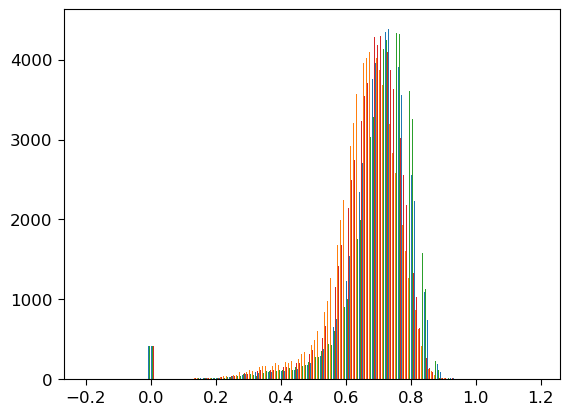

In [575]:
plt.hist(order_in_day_params_nogs[:, state_loadings_index, 0], bins=np.arange(-0.2, 1.2, 0.01))

(array([[0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 5.590e+02, 5.550e+02, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
         2.000e+00, 3.000e+00, 3.000e+00, 0.000e+00, 1.000e+00, 4.000e+00,
         7.000e+00, 4.000e+00, 9.000e+00, 1.000e+01, 1.800e+01, 1.400e+01,
         2.000e+01, 1.700e+01, 3.400e+01, 3.700e+01, 4.600e+01, 4.000e+01,
         4.700e+01, 6.100e+01, 5.500e+01, 5.900e+01, 8.500e+01, 7.100e+01,
         6.500e+01, 6.100e+01, 7.100e+01, 7.600e+01, 7.600e+01, 8.500e+01,
         1.140e+02, 9.700e+01, 9.500e+01, 1.080e+02, 1.450e+02, 1.600e+02,
         1.850e+02, 1.860e+02, 1.870e+02, 2.190e+02, 2.550e+02, 2.470e+02,
         3.090e+02, 3.620e+02, 4.200e+02, 5.010e+02, 5.880e+02, 6.950e+02,
         8.590e+02, 1.062

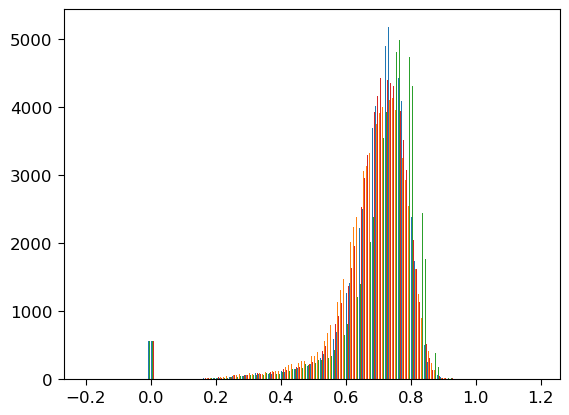

In [576]:
plt.hist(order_in_day_params_nogs_validation[:, state_loadings_index, 0], bins=np.arange(-0.2, 1.2, 0.01))

In [427]:
reload(postprocess)
from postprocess import *

### Examine correlation of delta chi-squares across datasets

In [470]:
fit_path = Path(
    '/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/split_half_cv'
)

In [577]:
chi2_valid_method_nogs = np.load(
    get_latest_file_from_condition(
        msst=True, order_in_day=True, gsr_type='_nogs_', fold=1, select_cb=True, data_type='fit_indices', sample_n=199
    )
)[:, 2]

/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/split_half_cv/fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_1_nogs_edgeN_93096_Est_MLR_z_controllingBefore__OrderInDay_MSST_OutStd_lavaan_addMarker_session_split_half_family_SelectCB_seed0_2025-06-01 06:57:07_combined.npy


In [583]:
chi2_valid_msst_nogs = np.load(
    get_latest_file_from_condition(
        msst=True, order_in_day=False, gsr_type='_nogs_', fold=1, select_cb=True, data_type='fit_indices', sample_n=199
    )
)[:, 2]

/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/split_half_cv/fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_1_nogs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-06-01 06:48:17_combined.npy


In [579]:
chi2_method_nogs = np.load(
    get_latest_file_from_condition(
        msst=True, order_in_day=True, gsr_type='_nogs_', fold=0, select_cb=True, data_type='fit_indices', sample_n=199
    )
)[:, 2]

/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/split_half_cv/fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_0_nogs_edgeN_93096_Est_MLR_z_controllingBefore__OrderInDay_MSST_OutStd_lavaan_addMarker_session_split_half_family_SelectCB_seed0_2025-06-01 06:54:57_combined.npy


In [580]:
chi2_msst_nogs = np.load(
    get_latest_file_from_condition(
        msst=True, order_in_day=False, gsr_type='_nogs_', fold=0, select_cb=True, data_type='fit_indices', sample_n=199
    )
)[:, 2]

/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/split_half_cv/fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_0_nogs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-06-01 06:46:29_combined.npy


In [515]:
chi2_st_nogs = np.load(
    fit_path / 'fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_203_Fold_0_nogs_edgeN_93096_Est_MLR_z_controllingBefore__SingleTrait_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-05-31 17:26:16_combined.npy'
)[:, 2]

In [516]:
chi2_valid_st_nogs = np.load(
    fit_path / 'fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_204_Fold_1_nogs_edgeN_93096_Est_MLR_z_controllingBefore__SingleTrait_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-05-31 17:27:28_combined.npy'
)[:, 2]

In [526]:
chi2_msst_nogs_old = np.load(
    fit_path / 'fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_203_Fold_0_nogs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_seed0_2024-12-12 13:17:41_combined.npy'
)[:, 2]

In [529]:
chi2_msst_nogs_old == chi2_msst_nogs

array([ True,  True,  True, ...,  True,  True,  True])

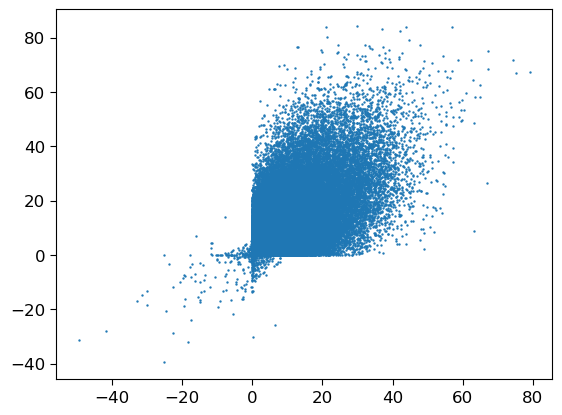

In [517]:
plt.scatter(
    chi2_st_nogs - chi2_msst_nogs, 
    chi2_valid_st_nogs - chi2_valid_msst_nogs,
    s=0.5
)

In [518]:
ma.corrcoef(
    ma.masked_invalid(chi2_st_nogs - chi2_msst_nogs),
    ma.masked_invalid(chi2_valid_st_nogs - chi2_valid_msst_nogs)
)[0, 1]

0.5805889078073436

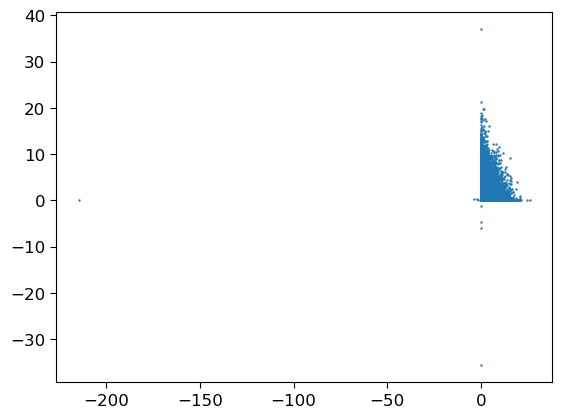

In [581]:
plt.scatter(
    chi2_msst_nogs - chi2_method_nogs, 
    chi2_valid_msst_nogs - chi2_valid_method_nogs, 
    s=0.5
)

In [520]:
ma.corrcoef(
    ma.masked_invalid(chi2_msst_nogs - chi2_method_nogs), 
    ma.masked_invalid(chi2_valid_msst_nogs - chi2_valid_method_nogs)
)[0, 1]

0.1723106897947129

In [584]:
get_latest_file_from_condition(
    msst=True, order_in_day=False, gsr_type='_nogs_', fold=0, select_cb=True, data_type='fit_indices', sample_n=199
).name

/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/split_half_cv/fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_0_nogs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-06-01 06:46:29_combined.npy


'fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_0_nogs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-06-01 06:46:29_combined.npy'

In [588]:
reload(postprocess)
from postprocess import *

/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/split_half_cv/fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_1_nogs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-06-01 06:48:17_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/split_half_cv/fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_1_gs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-06-01 06:51:06_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/split_half_cv/fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_1_nogs_edgeN_93096_Est_MLR_z_controllingBefore__OrderInDay_MSST_OutStd_lavaan_addMarker_session_split_half_family_SelectCB_seed0_2025-06-01 06:57:07_combined.npy
/home/cezanne/t-haitani/hcp_data/derivati

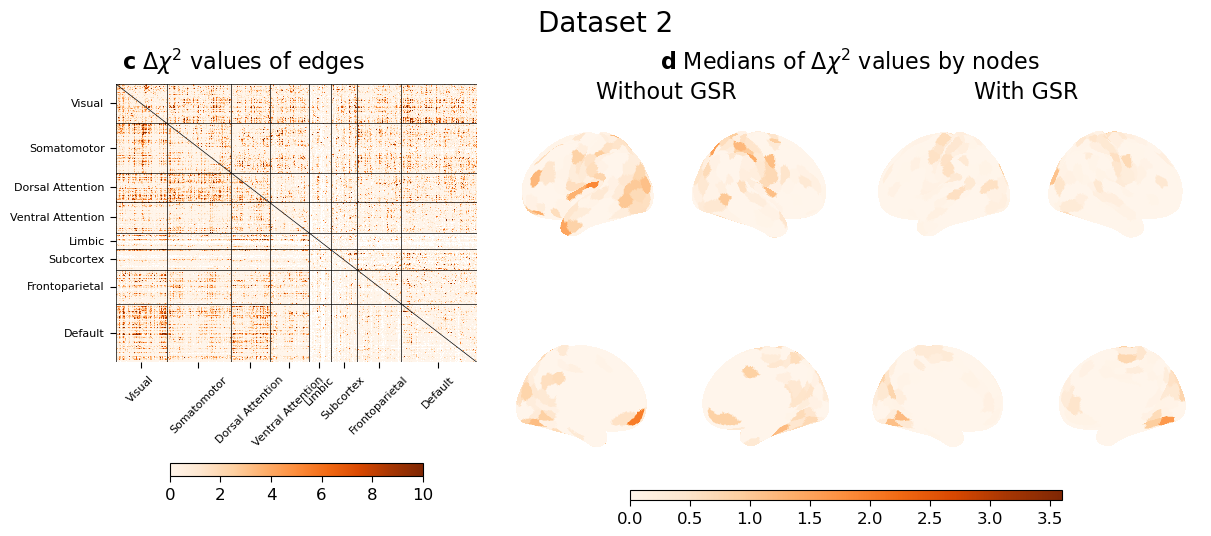

In [642]:
vis_stats_on_brain(
    save_filename='chi2_Schaefer_method_factor_diff_validation_select_CB_chi2_max_10',
    parcellation='Schaefer',
    fig_size=(12, 5),
    prefix_col_name='chi2',
    fig_direction='horizontal',
    add_fig_suptitle='Dataset 2',
    cbar_min=0,
    cbar_max=3.6,
    vmax_rsfc=10,
    hmap_width=0.4,
    cbar_width_ratio=0.5,
    value_name='chi-square values',
    filename_fit_list1=[
        get_latest_file_from_condition(
            msst=True, order_in_day=False, gsr_type='_nogs_', fold=1, select_cb=True, data_type='fit_indices', sample_n=199
        ).name,
        get_latest_file_from_condition(
            msst=True, order_in_day=False, gsr_type='_gs_', fold=1, select_cb=True, data_type='fit_indices', sample_n=199
        ).name
    ],
    filename_fit_list2=[
        get_latest_file_from_condition(
            msst=True, order_in_day=True, gsr_type='_nogs_', fold=1, select_cb=True, data_type='fit_indices', sample_n=199
        ).name,
        get_latest_file_from_condition(
            msst=True, order_in_day=True, gsr_type='_gs_', fold=1, select_cb=True, data_type='fit_indices', sample_n=199
        ).name
    ],
    gsr_label_y=0.85,
    figure_indicators=['c', 'd'],
    **{
        'invalid_edge_file': {
            'nogs': None,
            'gs': None
        }
    }
)

/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/split_half_cv/fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_0_nogs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-06-01 06:46:29_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/split_half_cv/fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_0_gs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-06-01 06:48:35_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/split_half_cv/fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_0_nogs_edgeN_93096_Est_MLR_z_controllingBefore__OrderInDay_MSST_OutStd_lavaan_addMarker_session_split_half_family_SelectCB_seed0_2025-06-01 06:54:57_combined.npy
/home/cezanne/t-haitani/hcp_data/derivati

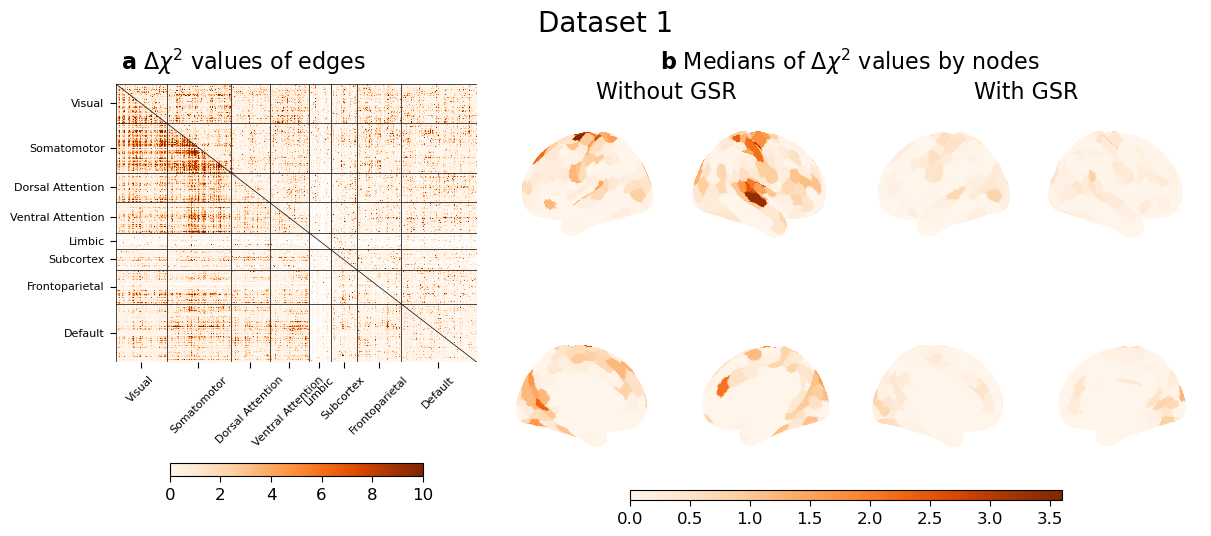

In [643]:
vis_stats_on_brain(
    save_filename='chi2_Schaefer_method_factor_diff_select_CB_vmax_rsfc_10',
    parcellation='Schaefer',
    fig_size=(12, 5),
    prefix_col_name='chi2',
    fig_direction='horizontal',
    add_fig_suptitle='Dataset 1',
    cbar_min=0,
    cbar_max=3.6,
    vmax_rsfc=10,
    hmap_width=0.4,
    cbar_width_ratio=0.5,
    value_name='chi-square values',
    filename_fit_list1=[
        get_latest_file_from_condition(
            msst=True, order_in_day=False, gsr_type='_nogs_', fold=0, select_cb=True, data_type='fit_indices', sample_n=199
        ).name,
        get_latest_file_from_condition(
            msst=True, order_in_day=False, gsr_type='_gs_', fold=0, select_cb=True, data_type='fit_indices', sample_n=199
        ).name
    ],
    filename_fit_list2=[
        get_latest_file_from_condition(
            msst=True, order_in_day=True, gsr_type='_nogs_', fold=0, select_cb=True, data_type='fit_indices', sample_n=199
        ).name,
        get_latest_file_from_condition(
            msst=True, order_in_day=True, gsr_type='_gs_', fold=0, select_cb=True, data_type='fit_indices', sample_n=199
        ).name
    ],
    gsr_label_y=0.85,
    **{
        'invalid_edge_file': {
            'nogs': None,
            'gs': None
        }
    }
)

In [387]:
from pathlib import Path
session_summary_path = Path('/home/cezanne/t-haitani/hcp_data/sessionSummaryCSV_1200Release')

In [394]:
rfmri_sessions = ['rfMRI_REST1_RL', 'rfMRI_REST1_LR', 'rfMRI_REST2_RL', 'rfMRI_REST2_LR']

In [404]:
n_not_counter_balanced, n_counter_balanced = 0, 0
subjects_cb, subjects_not_cb = [], []
for subject_file in session_summary_path.iterdir():
    if subject_file.name.endswith('.csv'):
        subject_df = pd.read_csv(subject_file).query('`Scan Type` == "rfMRI"')
        if subject_df.query('`Scan Description` == "rfMRI_REST2_LR"')['Scan Order'].values == 1:
            n_counter_balanced += 1
            subjects_cb.append(subject_file.name.replace('.csv', ''))
        else:
            n_not_counter_balanced += 1
            subjects_not_cb.append(subject_file.name.replace('.csv', ''))

In [547]:
np.savetxt('/home/cezanne/t-haitani/hcp_data/derivatives/subjects_cb_filtered.txt', np.array(list(subjects_cb_filtered)), fmt="%s")

In [536]:
subjects_set = np.loadtxt('/home/cezanne/t-haitani/hcp_data/derivatives/subjects_set_for_analysis_861.csv', dtype=str)

In [540]:
len(subjects_cb)

995

In [543]:
subjects_cb_filtered = set(subjects_set) & set(subjects_cb)

In [414]:
subject_cb_loaded = np.loadtxt(
    '/home/cezanne/t-haitani/hcp_data/derivatives/subjects_cb.txt', dtype=str
)

In [400]:
n_counter_balanced

995

In [401]:
n_not_counter_balanced

118

In [372]:
method_loadings_index

Index([10, 11, 12, 13], dtype='int64')

In [361]:
order_in_day_param_order

lhs  op  rhs
0    o1  =~   s1
1    o1  =~   s2
2    o2  =~   s3
3    o2  =~   s4
4    ff  =~   o1
5    ff  =~   o2
6    s1  ~~   s1
7    s2  ~~   s2
8    s3  ~~   s3
9    s4  ~~   s4
10  mf1  =~   s1
11  mf1  =~   s3
12  mf2  =~   s2
13  mf2  =~   s4
14   ff  ~~  mf1
15   ff  ~~  mf2
16  mf1  ~~  mf2
17   o1  ~~   o1
18   o2  ~~   o2
19   ff  ~~   ff
20  mf1  ~~  mf1
21  mf2  ~~  mf2

### Conduct chi-square difference tests between bifactor and baseline models

Ploting left lateral in nogs condition.
Ploting left medial in nogs condition.
Ploting right lateral in nogs condition.
Ploting right medial in nogs condition.
Ploting left lateral in gs condition.
Ploting left medial in gs condition.
Ploting right lateral in gs condition.
Ploting right medial in gs condition.
Drawing heatmap of edges.
Saving file.
Saving completed.


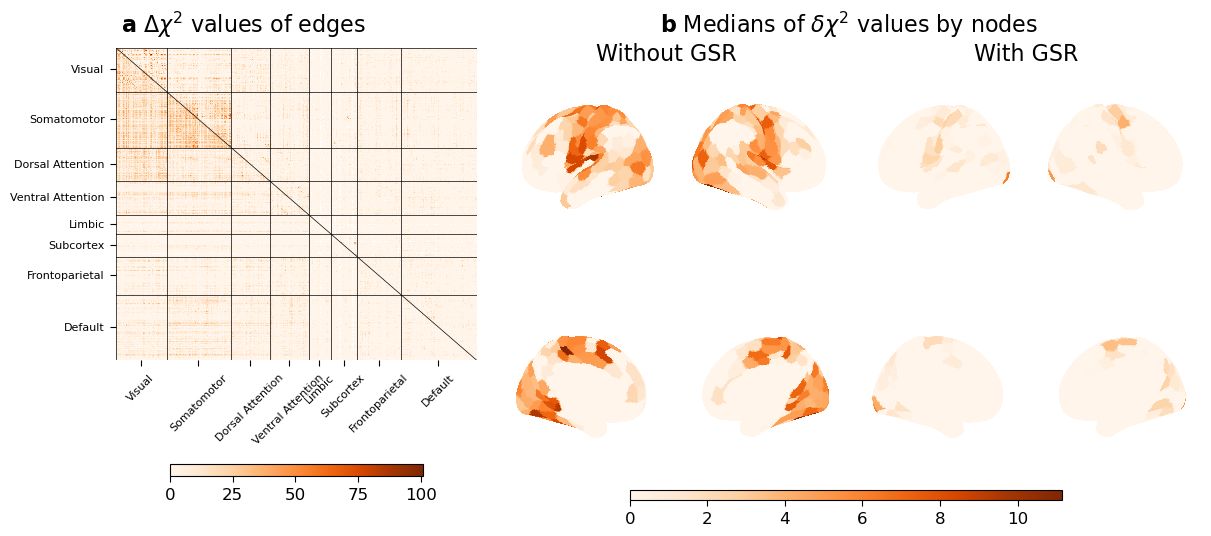

In [54]:
%matplotlib inline
vis_stats_on_brain(
    save_filename='chi2_Schaefer_brain_bifactor_vs_st_mod_valid_diff_load',
    parcellation='Schaefer',
    fig_size=(12, 5),
    prefix_col_name='chi2',
    fig_direction='horizontal',
    add_fig_suptitle='',
    cbar_min=0,
    cbar_max=None,
    hmap_width=0.4,
    cbar_width_ratio=0.5,
    value_name='chi-square values',
    filename_fit_list1=[
        'fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_203_Fold_0_nogs_edgeN_93096_Est_MLR_z_controllingBefore__OutStd_lavaan_session_split_half_family_2024-11-27 10:57:34_combined.npy',
        'fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_203_Fold_0_gs_edgeN_93096_Est_MLR_z_controllingBefore__OutStd_lavaan_session_split_half_family_2024-11-27 10:56:43_combined.npy'
    ],
    filename_fit_list2=[
        'fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_203_Fold_0_nogs_edgeN_93096_Est_MLR_z_OutStd_lavaan_session_split_half_family_seed0_2025-05-22 17:57:08_combined.npy',
        'fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_203_Fold_0_gs_edgeN_93096_Est_MLR_z_OutStd_lavaan_session_split_half_family_seed0_2025-05-22 18:03:37_combined.npy'
    ],
    **{
        'invalid_edge_file': {
            'nogs': None,
            'gs': None
        }
    }
)

In [450]:
reload(postprocess)
from postprocess import *

In [49]:
get_latest_file_from_condition(order_in_day=False, gsr_type='_nogs_', fold=0)

/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/split_half_cv/fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_0_nogs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-06-01 06:46:29_combined.npy


PosixPath('/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/split_half_cv/fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_0_nogs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-06-01 06:46:29_combined.npy')

In [118]:
reload(postprocess)
from postprocess import *

In [124]:
get_latest_file_from_condition(order_in_day=False, gsr_type='_nogs_', fold=0, sample_n=203, select_cb=False)

/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/split_half_cv/fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_203_Fold_0_nogs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_seed68_2024-12-12 13:30:56_combined.npy


PosixPath('/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/split_half_cv/fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_203_Fold_0_nogs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_seed68_2024-12-12 13:30:56_combined.npy')

/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/split_half_cv/fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_203_Fold_0_nogs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_seed68_2024-12-12 13:30:56_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/split_half_cv/fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_203_Fold_0_gs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_seed68_2024-12-12 13:52:47_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/split_half_cv/fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_204_Fold_1_nogs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_seed68_2024-12-12 13:38:15_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combine

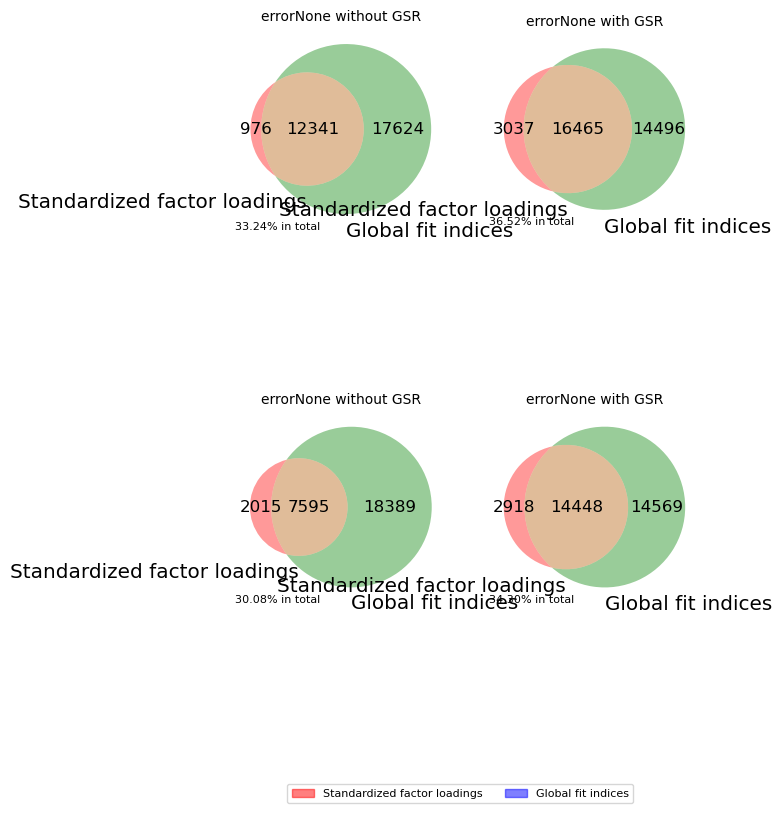

In [125]:
wrapper_of_select_edges_model_onlyFC(
    {
        'Fold_0': [
            get_latest_file_from_condition(order_in_day=False, gsr_type='_nogs_', fold=0, select_cb=False, sample_n=203).name,
            get_latest_file_from_condition(order_in_day=False, gsr_type='_gs_', fold=0, select_cb=False, sample_n=203).name
    ],
        'Fold_1': [
            get_latest_file_from_condition(order_in_day=False, gsr_type='_nogs_', fold=1, select_cb=False, sample_n=204).name,
            get_latest_file_from_condition(order_in_day=False, gsr_type='_gs_', fold=1, select_cb=False, sample_n=204).name
        ]        
    },
    fit_indices_thresholds_dict={'SRMR': 0.08, 'RMSEA': 0.08, 'CFI': 0.90},
    loading_minimum=0.4,
    loading_maximum=0.9,
    loading_tf_minimum=0.7,
    loading_tf_maximum=1,
    omega_minimum=None,
    method_cor_max=None,
    method_cor_min=None,
    fig_size=(6, 9),
    msst_list=[True, True],
    param_order_filename_list=['model_onlyFC_controlling_None_CovCor_lavaan_MSST_session.csv'],
    nrow_fig=2,
    family_cv=True
)

/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/split_half_cv/fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_0_nogs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-06-01 06:46:29_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/split_half_cv/fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_0_gs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-06-01 06:48:35_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/split_half_cv/fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_1_nogs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-06-01 06:48:17_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliabi

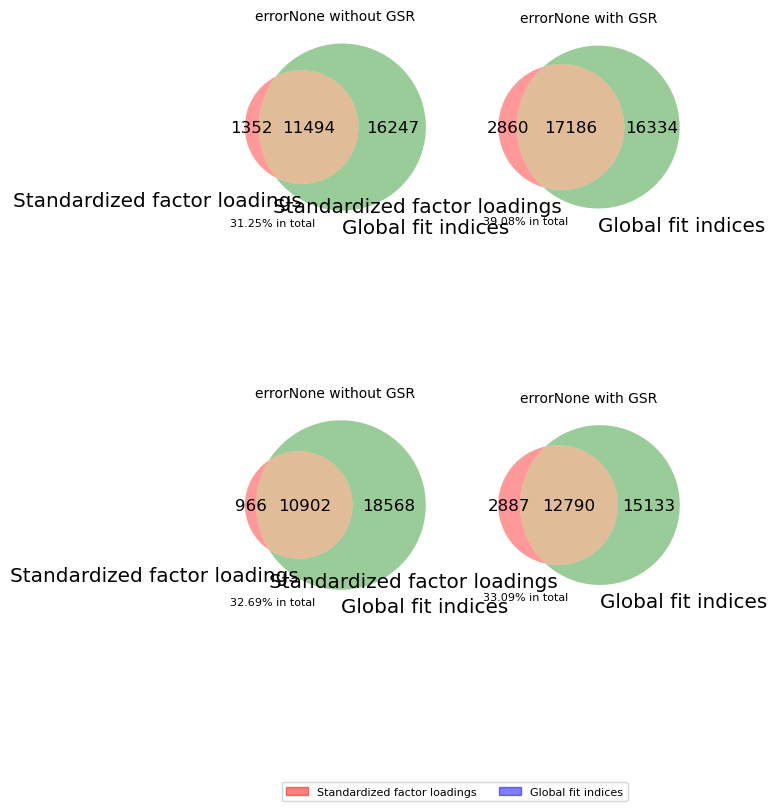

In [95]:
wrapper_of_select_edges_model_onlyFC(
    {
        'Fold_0': [
            get_latest_file_from_condition(order_in_day=False, gsr_type='_nogs_', fold=0, select_cb=True).name,
            get_latest_file_from_condition(order_in_day=False, gsr_type='_gs_', fold=0, select_cb=True).name
    ],
        'Fold_1': [
            get_latest_file_from_condition(order_in_day=False, gsr_type='_nogs_', fold=1, select_cb=True).name,
            get_latest_file_from_condition(order_in_day=False, gsr_type='_gs_', fold=1, select_cb=True).name
        ]        
    },
    fit_indices_thresholds_dict={'SRMR': 0.08, 'RMSEA': 0.08, 'CFI': 0.90},
    loading_minimum=0.4,
    loading_maximum=0.9,
    loading_tf_minimum=0.7,
    loading_tf_maximum=1,
    omega_minimum=None,
    method_cor_max=None,
    method_cor_min=None,
    fig_size=(6, 9),
    msst_list=[True, True],
    param_order_filename_list=['model_onlyFC_controlling_None_CovCor_lavaan_MSST_session.csv'],
    nrow_fig=2,
    family_cv=True
)

/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/split_half_cv/fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_0_nogs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-06-01 06:46:29_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/split_half_cv/fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_0_gs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-06-01 06:48:35_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices/combined/split_half_cv/fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_199_Fold_1_nogs_edgeN_93096_Est_MLR_z_MSST_OutStd_lavaan_session_split_half_family_SelectCB_seed0_2025-06-01 06:48:17_combined.npy
/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliabi

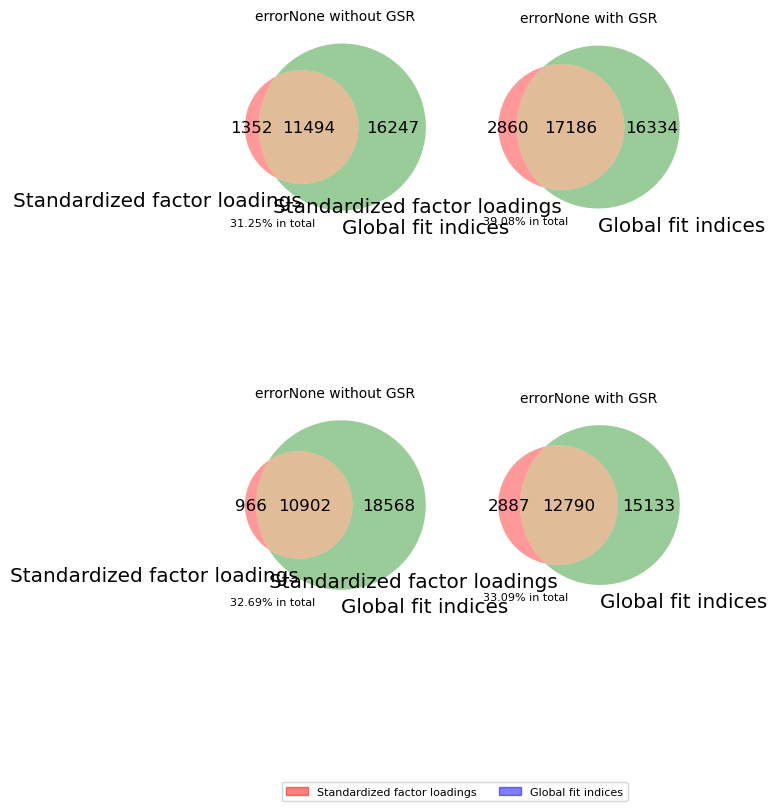

In [51]:
wrapper_of_select_edges_model_onlyFC(
    {
        'Fold_0': [
            get_latest_file_from_condition(order_in_day=False, gsr_type='_nogs_', fold=0).name,
            get_latest_file_from_condition(order_in_day=False, gsr_type='_gs_', fold=0).name
    ],
        'Fold_1': [
            get_latest_file_from_condition(order_in_day=False, gsr_type='_nogs_', fold=1).name,
            get_latest_file_from_condition(order_in_day=False, gsr_type='_gs_', fold=1).name
        ]        
    },
    fit_indices_thresholds_dict={'SRMR': 0.08, 'RMSEA': 0.08, 'CFI': 0.90},
    loading_minimum=0.4,
    loading_maximum=0.9,
    loading_tf_minimum=0.7,
    loading_tf_maximum=1,
    omega_minimum=None,
    method_cor_max=None,
    method_cor_min=None,
    fig_size=(6, 9),
    msst_list=[True, True],
    param_order_filename_list=['model_onlyFC_controlling_None_CovCor_lavaan_MSST_session.csv'],
    nrow_fig=2,
    family_cv=True
)

fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_203_Fold_0_nogs_edgeN_93096_Est_MLR_z_controllingBefore__OrderInDay_MSST_OutStd_lavaan_addMarker_session_split_half_family_SelectCB_seed0_2025-05-31 13:38:48_combined.npy
Percentage of invalid edges is following
Total: 36085 (38.76%)
Parameter estimates: 10699 (11.49%)
Global fit indices: 35115 (37.72%)
fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_203_Fold_0_gs_edgeN_93096_Est_MLR_z_controllingBefore__OrderInDay_MSST_OutStd_lavaan_addMarker_session_split_half_family_SelectCB_seed0_2025-05-31 13:30:24_combined.npy
Percentage of invalid edges is following
Total: 36993 (39.74%)
Parameter estimates: 16043 (17.23%)
Global fit indices: 34435 (36.99%)
fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_204_Fold_1_nogs_edgeN_93096_Est_MLR_z_controllingBefore__OrderInDay_MSST_OutStd_lavaan_addMarker_session_split_half_family_SelectCB_seed0_2025-05-31 13:40:45_combined.npy
Percentage of invalid edges is following
Total: 28507 (3

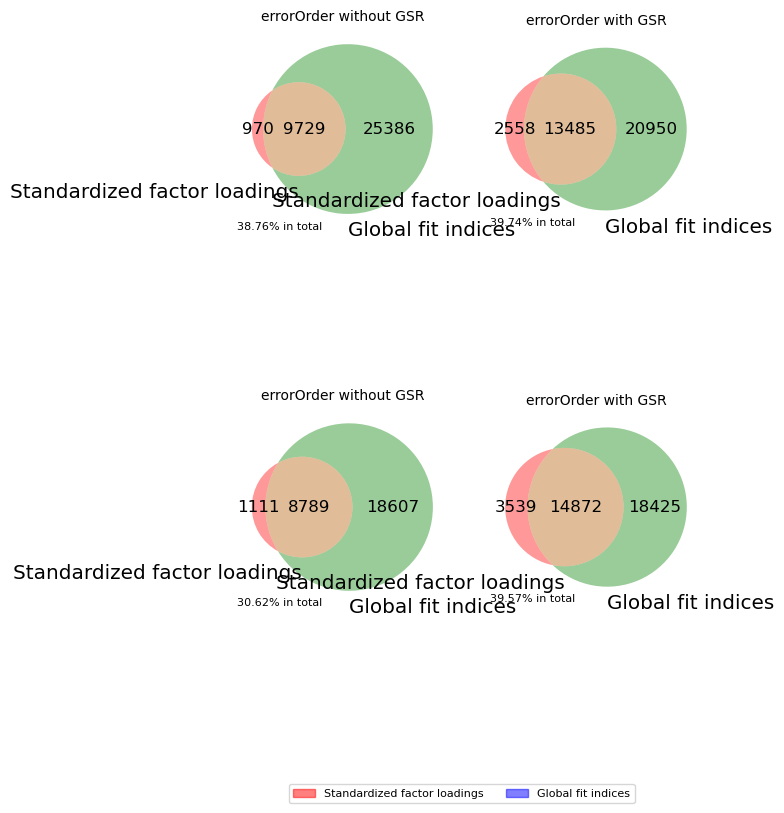

In [452]:
wrapper_of_select_edges_model_onlyFC(
    {
        'Fold_0': [
            'fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_203_Fold_0_nogs_edgeN_93096_Est_MLR_z_controllingBefore__OrderInDay_MSST_OutStd_lavaan_addMarker_session_split_half_family_SelectCB_seed0_2025-05-31 13:38:48_combined.npy',
            'fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_203_Fold_0_gs_edgeN_93096_Est_MLR_z_controllingBefore__OrderInDay_MSST_OutStd_lavaan_addMarker_session_split_half_family_SelectCB_seed0_2025-05-31 13:30:24_combined.npy'
    ],
        'Fold_1': [
        'fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_204_Fold_1_nogs_edgeN_93096_Est_MLR_z_controllingBefore__OrderInDay_MSST_OutStd_lavaan_addMarker_session_split_half_family_SelectCB_seed0_2025-05-31 13:40:45_combined.npy',
        'fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_204_Fold_1_gs_edgeN_93096_Est_MLR_z_controllingBefore__OrderInDay_MSST_OutStd_lavaan_addMarker_session_split_half_family_SelectCB_seed0_2025-05-31 13:33:12_combined.npy'
        ]        
    },
    fit_indices_thresholds_dict={'SRMR': 0.08, 'RMSEA': 0.08, 'CFI': 0.90},
    loading_minimum=0.4,
    loading_maximum=0.9,
    loading_tf_minimum=0.7,
    loading_tf_maximum=1,
    omega_minimum=None,
    method_cor_max=None,
    method_cor_min=None,
    fig_size=(6, 9),
    msst_list=[True, True],
    param_order_filename_list=['model_onlyFC_controlling_None_CovCor_lavaan_addMarker_MSST_OrderFactor_session.csv'],
    nrow_fig=2,
    family_cv=True
)

fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_203_Fold_0_nogs_edgeN_93096_Est_MLR_z_OutStd_lavaan_session_split_half_family_seed0_2025-05-22 17:57:08_combined.npy
Percentage of invalid edges is following
Total: 92341 (99.19%)
Parameter estimates: 92079 (98.91%)
Global fit indices: 26817 (28.81%)
fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_203_Fold_0_gs_edgeN_93096_Est_MLR_z_OutStd_lavaan_session_split_half_family_seed0_2025-05-22 18:03:37_combined.npy
Percentage of invalid edges is following
Total: 92500 (99.36%)
Parameter estimates: 92297 (99.14%)
Global fit indices: 22997 (24.70%)


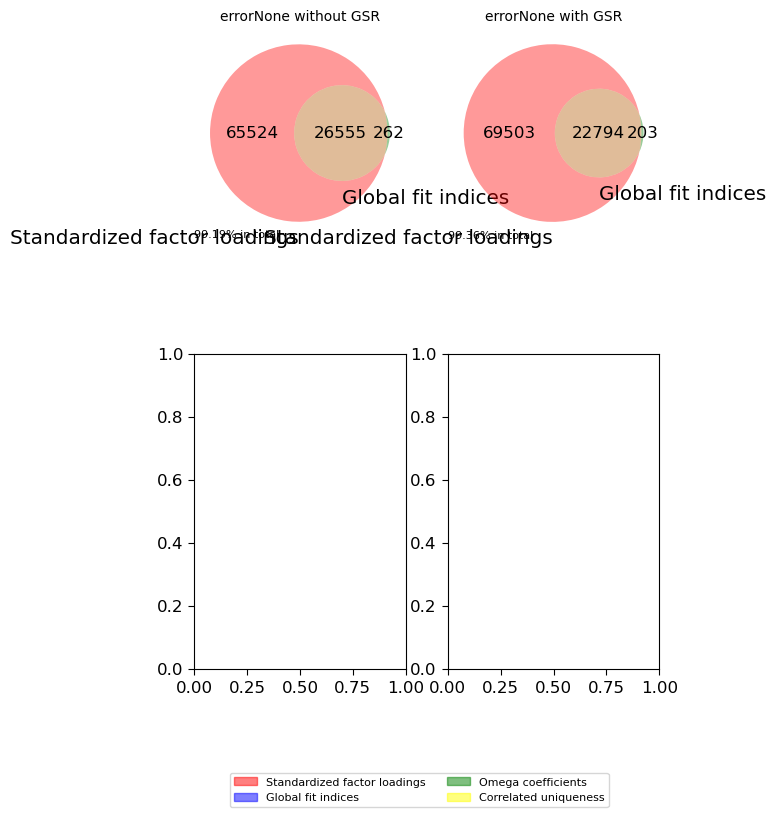

In [61]:
wrapper_of_select_edges_model_onlyFC(
    {
        'Fold_0': [
            'fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_203_Fold_0_nogs_edgeN_93096_Est_MLR_z_OutStd_lavaan_session_split_half_family_seed0_2025-05-22 17:57:08_combined.npy',
            'fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_203_Fold_0_gs_edgeN_93096_Est_MLR_z_OutStd_lavaan_session_split_half_family_seed0_2025-05-22 18:03:37_combined.npy'
        ],
#         'Fold_1': [
#             'fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_204_Fold_1_nogs_edgeN_93096_Est_MLR_z_controlling_none_CovCor_MSSTDL_OutStd_lavaan_session_split_half_family_2024-11-13 11:04:22_combined.npy',
#             'fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_204_Fold_1_gs_edgeN_93096_Est_MLR_z_controlling_none_CovCor_MSSTDL_OutStd_lavaan_session_split_half_family_2024-11-13 11:05:44_combined.npy'
#         ]
    },
    fit_indices_thresholds_dict={'SRMR': 0.08, 'RMSEA': 0.08, 'CFI': 0.90},
    loading_minimum=0.4,
    loading_maximum=0.9,
#     loading_tf_minimum=0.7,
#     loading_tf_maximum=1,
    omega_minimum=None,
    method_cor_max=None,
    method_cor_min=None,
    fig_size=(6, 9),
    save_filename='bifactor_fold0',
    msst_list=[False],
    param_order_filename_list=['model_onlyFC_controlling_None_CovCor_lavaan_session.csv'],
    nrow_fig=2,
    family_cv=True
)

### Results of fit indices (SRMR, RMSEA, CFI)

### Combine output files of multistate single-trait model with method factors

In [21]:
create_combined_files_from_slurm_array(
    multistate_single_trait=True,
    controls=None,
    data_type_list=['fit_indices', 'parameters'],
    family_fold=0,
    order_in_day=True,
    controls_before='',
    add_marker=True,
    random_seed=0,
    **{'sample_n': 203, 'edge_n': 93096},
)

Processing /home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices in _nogs_.
(93096, 15)
Saving fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_203_Fold_0_nogs_edgeN_93096_Est_MLR_z_controllingBefore__OrderInDay_MSST_OutStd_lavaan_addMarker_session_split_half_family_seed0_2025-02-01 17:11:37_combined.npy.
Saving completed.
Processing /home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/parameters in _nogs_.
(93096, 13, 5)
Saving params_Model_onlyFC_Trait_None_Scale_None_sampleN_203_Fold_0_nogs_edgeN_93096_Est_MLR_z_controllingBefore__OrderInDay_MSST_OutStd_lavaan_addMarker_session_split_half_family_seed0_2025-02-01 17:11:37_combined.npy.
Saving completed.
Processing /home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/fit_indices in _gs_.
(93096, 15)
Saving fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_203_Fold_0_gs_edgeN_93096_Est_MLR_z_controllingBefore__OrderI

### Select invalid edges in multistate single-trait model with method factors

fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_203_Fold_0_nogs_edgeN_93096_Est_MLR_z_controllingBefore__OrderInDay_MSST_OutStd_lavaan_addMarker_session_split_half_family_seed0_2025-02-01 17:11:37_combined.npy
Percentage of invalid edges is following
Total: 90540 (97.25%)
Parameter estimates: 89128 (95.74%)
Global fit indices: 35115 (37.72%)
fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_203_Fold_0_gs_edgeN_93096_Est_MLR_z_controllingBefore__OrderInDay_MSST_OutStd_lavaan_addMarker_session_split_half_family_seed0_2025-02-01 17:13:36_combined.npy
Percentage of invalid edges is following
Total: 90538 (97.25%)
Parameter estimates: 89108 (95.72%)
Global fit indices: 34435 (36.99%)


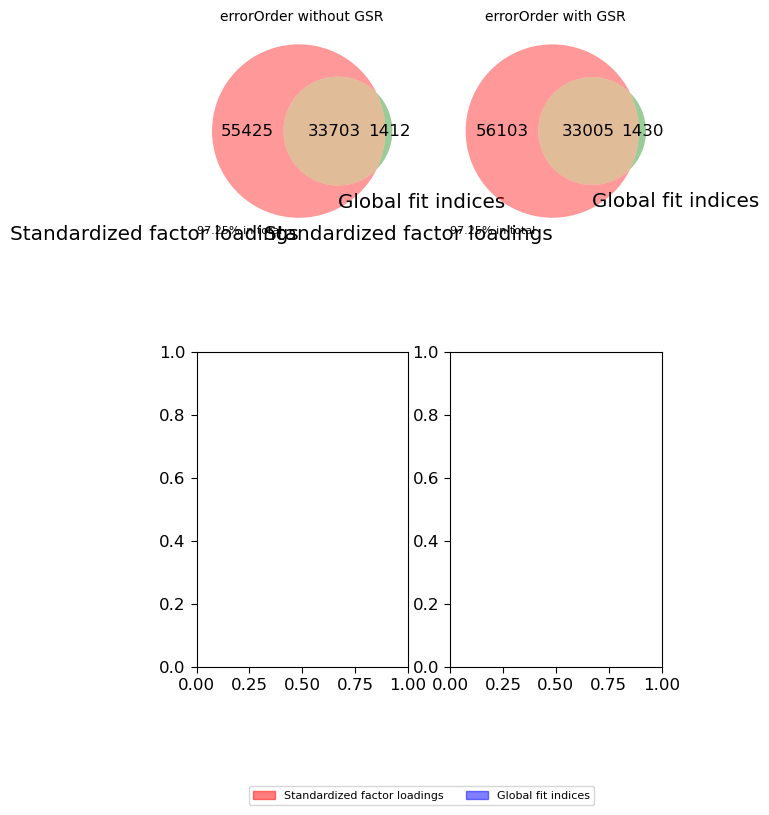

In [23]:
wrapper_of_select_edges_model_onlyFC(
    {
        'Fold_0': [
            'fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_203_Fold_0_nogs_edgeN_93096_Est_MLR_z_controllingBefore__OrderInDay_MSST_OutStd_lavaan_addMarker_session_split_half_family_seed0_2025-02-01 17:11:37_combined.npy',
            'fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_203_Fold_0_gs_edgeN_93096_Est_MLR_z_controllingBefore__OrderInDay_MSST_OutStd_lavaan_addMarker_session_split_half_family_seed0_2025-02-01 17:13:36_combined.npy'
        ],
#         'Fold_1': [
#             'fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_204_Fold_1_nogs_edgeN_93096_Est_MLR_z_controlling_none_CovCor_MSSTDL_OutStd_lavaan_session_split_half_family_2024-11-13 11:04:22_combined.npy',
#             'fit_indices_Model_onlyFC_Trait_None_Scale_None_sampleN_204_Fold_1_gs_edgeN_93096_Est_MLR_z_controlling_none_CovCor_MSSTDL_OutStd_lavaan_session_split_half_family_2024-11-13 11:05:44_combined.npy'
#         ]
    },
    fit_indices_thresholds_dict={'SRMR': 0.08, 'RMSEA': 0.08, 'CFI': 0.90},
    loading_minimum=0.4,
    loading_maximum=0.9,
    loading_tf_minimum=0.7,
    loading_tf_maximum=1,
    omega_minimum=None,
    method_cor_max=None,
    method_cor_min=None,
    fig_size=(6, 9),
#     save_filename='venn_summary_msst_add_day_covs',
    msst_list=[True],
    param_order_filename_list=['model_onlyFC_controlling_None_CovCor_lavaan_addMarker_MSST_OrderFactor_session.csv'],
    nrow_fig=2,
    family_cv=False
)

In [456]:
np.loadtxt(
    '/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/invalid_edges/Fold_1/errorNone_nogs_invalid_edges_SRMR_0.08_RMSEA_0.08_CFI_0.9_loadings_from_0.4_to_0.9_2ndLoadings_from_0.7_to_1_controlling__seed0.csv'
).shape

(30094,)

In [457]:
np.loadtxt(
    '/home/cezanne/t-haitani/hcp_data/derivatives/Python/parcellation/Schaefer/reliability/invalid_edges/Fold_1/errorOrder_nogs_invalid_edges_SRMR_0.08_RMSEA_0.08_CFI_0.9_loadings_from_0.4_to_0.9_2ndLoadings_from_0.7_to_1_controlling__.csv'
).shape

(28507,)

In [464]:
reload(postprocess)
from postprocess import *

### Visualize invalid eges in multistate single-trait model with method factors

Getting df of nodes.
Ploting left lateral in nogs condition.
Ploting left medial in nogs condition.
Ploting right lateral in nogs condition.
Ploting right medial in nogs condition.
Ploting left lateral in gs condition.
Ploting left medial in gs condition.
Ploting right lateral in gs condition.
Ploting right medial in gs condition.
Drawing heatmap of edges.
Saving file.
Saving completed.


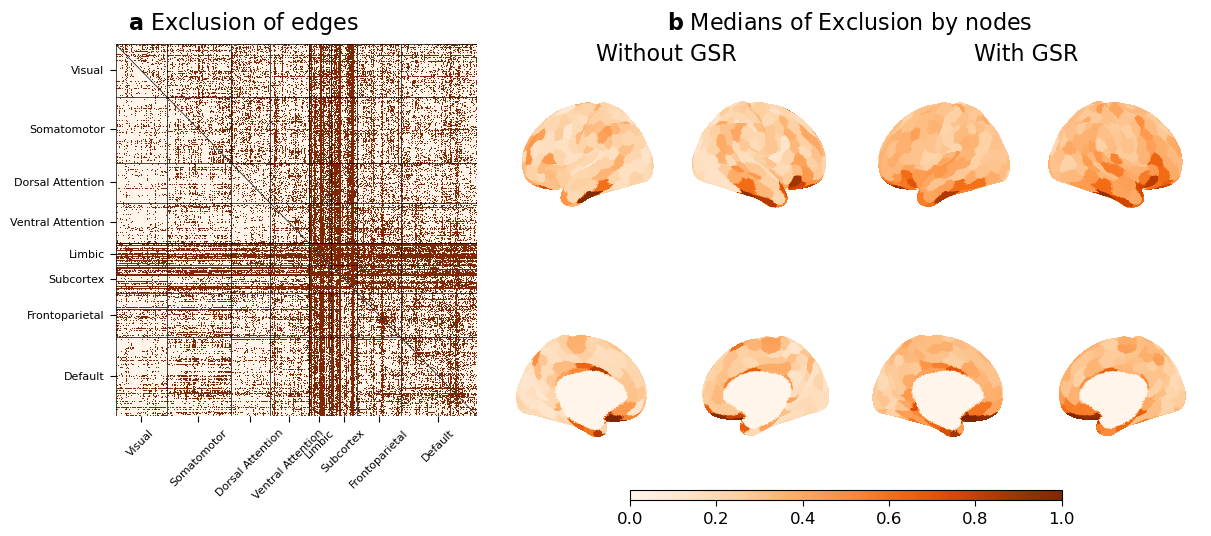

In [465]:
vis_stats_on_brain(
    save_filename='msst_method_factor_exclusion_validation',
    parcellation='Schaefer',
    fig_size=(12, 5),
    prefix_col_name='',
    fig_direction='horizontal',
    add_fig_suptitle='',
    cbar_min=0,
    cbar_max=1,
    hmap_width=0.4,
    cbar_width_ratio=0.5,
    value_name='exclusion',
#     edges_validity_df=df,
    fold=1,
    invalid_edge_file_list=[
        'errorOrder_nogs_invalid_edges_SRMR_0.08_RMSEA_0.08_CFI_0.9_loadings_from_0.4_to_0.9_2ndLoadings_from_0.7_to_1_controlling__.csv',
        'errorOrder_gs_invalid_edges_SRMR_0.08_RMSEA_0.08_CFI_0.9_loadings_from_0.4_to_0.9_2ndLoadings_from_0.7_to_1_controlling__.csv'
    ]
)

Getting df of nodes.
Ploting left lateral in nogs condition.
Ploting left medial in nogs condition.
Ploting right lateral in nogs condition.
Ploting right medial in nogs condition.
Ploting left lateral in gs condition.
Ploting left medial in gs condition.
Ploting right lateral in gs condition.
Ploting right medial in gs condition.
Drawing heatmap of edges.
Saving file.
Saving completed.


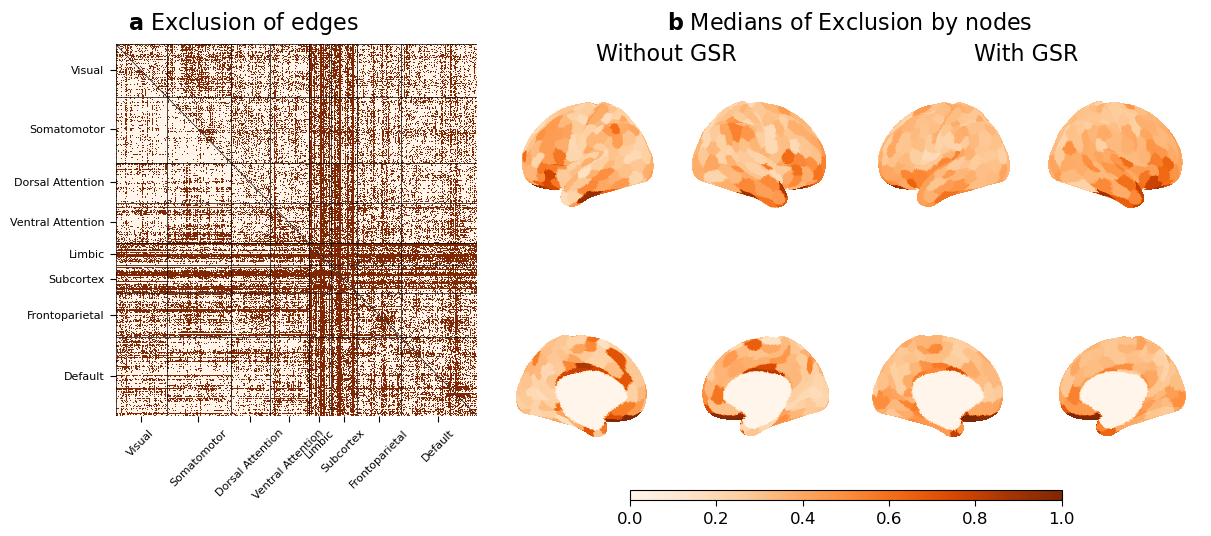

In [466]:
vis_stats_on_brain(
    save_filename='msst_method_factor_exclusion',
    parcellation='Schaefer',
    fig_size=(12, 5),
    prefix_col_name='',
    fig_direction='horizontal',
    add_fig_suptitle='',
    cbar_min=0,
    cbar_max=1,
    hmap_width=0.4,
    cbar_width_ratio=0.5,
    value_name='exclusion',
#     edges_validity_df=df,
    fold=0,
    invalid_edge_file_list=[
        'errorOrder_nogs_invalid_edges_SRMR_0.08_RMSEA_0.08_CFI_0.9_loadings_from_0.4_to_0.9_2ndLoadings_from_0.7_to_1_controlling__.csv',
        'errorOrder_gs_invalid_edges_SRMR_0.08_RMSEA_0.08_CFI_0.9_loadings_from_0.4_to_0.9_2ndLoadings_from_0.7_to_1_controlling__.csv'
    ]
)